## ⚙️ Import Libraries

In [32]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/cleeean-data/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

In [34]:
X_train_images = np.array([x.reshape(64, 128) for x in X_train])
y_train_masks = np.array([y.reshape(64, 128) for y in y_train])

In [35]:
X_val_images = np.array([x.reshape(64, 128) for x in X_val])
y_val_masks = np.array([y.reshape(64, 128) for y in y_val])

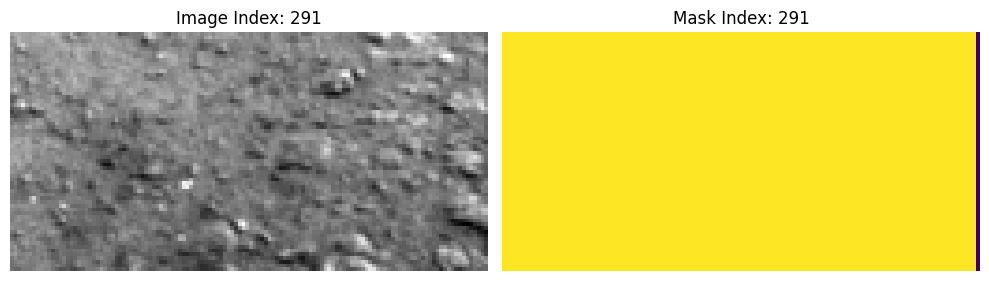

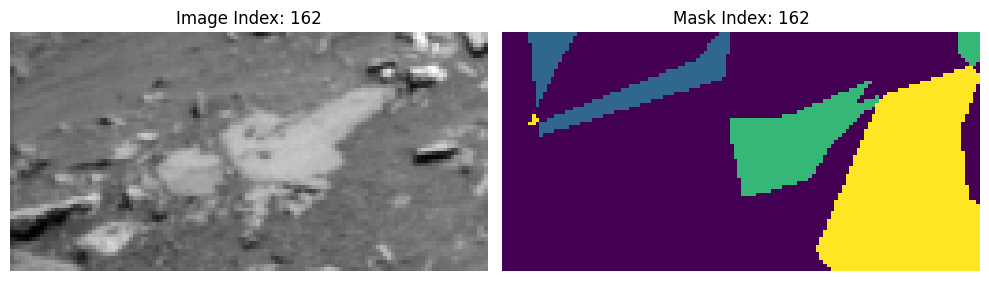

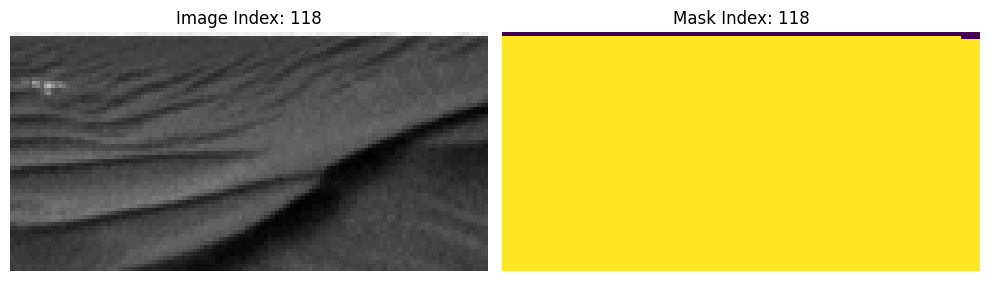

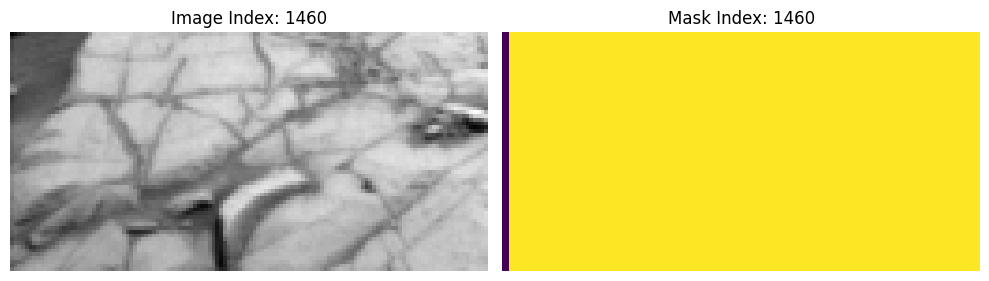

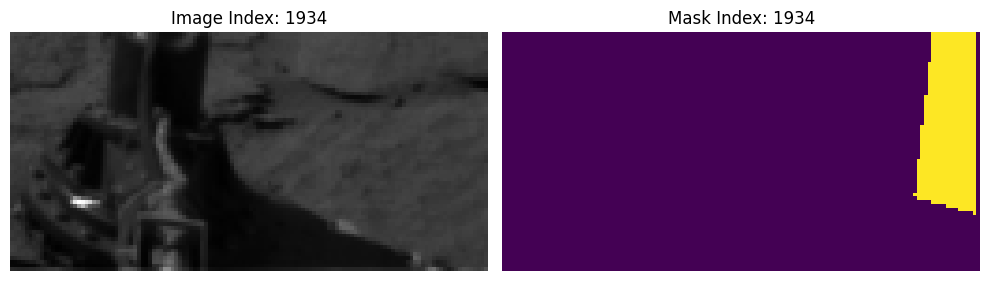

In [36]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## 🛠️ Train and Save the Model

In [37]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [38]:
X_val = X_val[..., np.newaxis] / 255.0

In [39]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (2004, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (2004, 64, 128)


In [40]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis")
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis")
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [41]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (2004, 64, 128, 1)
Shape of y_train after reshaping: (2004, 64, 128, 1)


In [42]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Data Augmentation for Images and Masks
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
)

# Masks should only be flipped or translated without interpolation
mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Ensure y_train has the correct shape for augmentation
y_train = np.expand_dims(y_train, axis=-1)  # Add channel dimension to masks

# Fit augmentations to the data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

# Create the generators
image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=32, seed=42)

train_generator = zip(image_generator, mask_generator)

# Weighted Loss Function for Class Imbalance
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Remove the extra dimension from y_true using tf.squeeze
        y_true = tf.squeeze(y_true, axis=-1)

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)

    return loss

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Use the calculated weights in the loss function
loss = weighted_categorical_crossentropy(class_weights)

# Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c2)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation="softmax")(c3)
    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
model = unet_model(input_shape, num_classes)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.summary()

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=15,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)

# Custom Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_datagen, mask_datagen, X_train, y_train, batch_size):
        self.image_datagen = image_datagen
        self.mask_datagen = mask_datagen
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.X_train) / float(self.batch_size)))

    def __getitem__(self, idx):
      # Get the batch indices
      batch_x = self.X_train[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y_train[idx * self.batch_size:(idx + 1) * self.batch_size]

      # Apply augmentation
      # Use __next__() instead of next() for NumpyArrayIterator
      image_batch = self.image_datagen.flow(batch_x, batch_size=self.batch_size, shuffle=False).__next__()
      mask_batch = self.mask_datagen.flow(batch_y, batch_size=self.batch_size, shuffle=False).__next__()

      return image_batch, mask_batch  # Return image and mask batches


Shape of X_train after reshaping: (2004, 64, 128, 1)
Shape of y_train after reshaping: (2004, 64, 128)
Class pixel counts: [3979893 5532162 3924593 2958791   21329]
Calculated class weights: [0.00524455 0.00377298 0.00531845 0.00705449 0.97860952]


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 128,   │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_58[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 64,    │          0 │ conv2d_59[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_60[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 128,   │     32,832 │ conv2d_61[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64, 128,   │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 128,   │     73,792 │ concatenate_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_62[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 128,   │        325 │ conv2d_63[0][0]   │
│                     │ 5)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 402,885 (1.54 MB)

 Trainable params: 402,885 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 128,   │        640 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 64, 128,   │        128 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 128,   │          0 │ conv2d_66[0][0],  │
│                     │ 64)               │            │ conv2d_67[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 64,    │          0 │ add_14[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 64,    │    147,584 │ conv2d_68[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 64,    │      8,320 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 32, 64,    │          0 │ conv2d_69[0][0],  │
│                     │ 128)              │            │ conv2d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 32,    │          0 │ add_15[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 16, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 16, 32,    │    590,080 │ conv2d_71[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 16, 32,    │     33,024 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 16, 32,    │          0 │ conv2d_72[0][0],  │
│                     │ 256)              │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 16,     │          0 │ add_16[0][0]      │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_14

 Total params: 8,041,989 (30.68 MB)

 Trainable params: 8,041,989 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


W0000 00:00:1733083945.672587      98 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.3211 - loss: 1.4630 - mean_io_u_2: 0.0990

W0000 00:00:1733083959.278305     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3212 - loss: 1.4622 - mean_io_u_2: 0.0991

W0000 00:00:1733083962.622858      99 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733083963.849295     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.37480, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


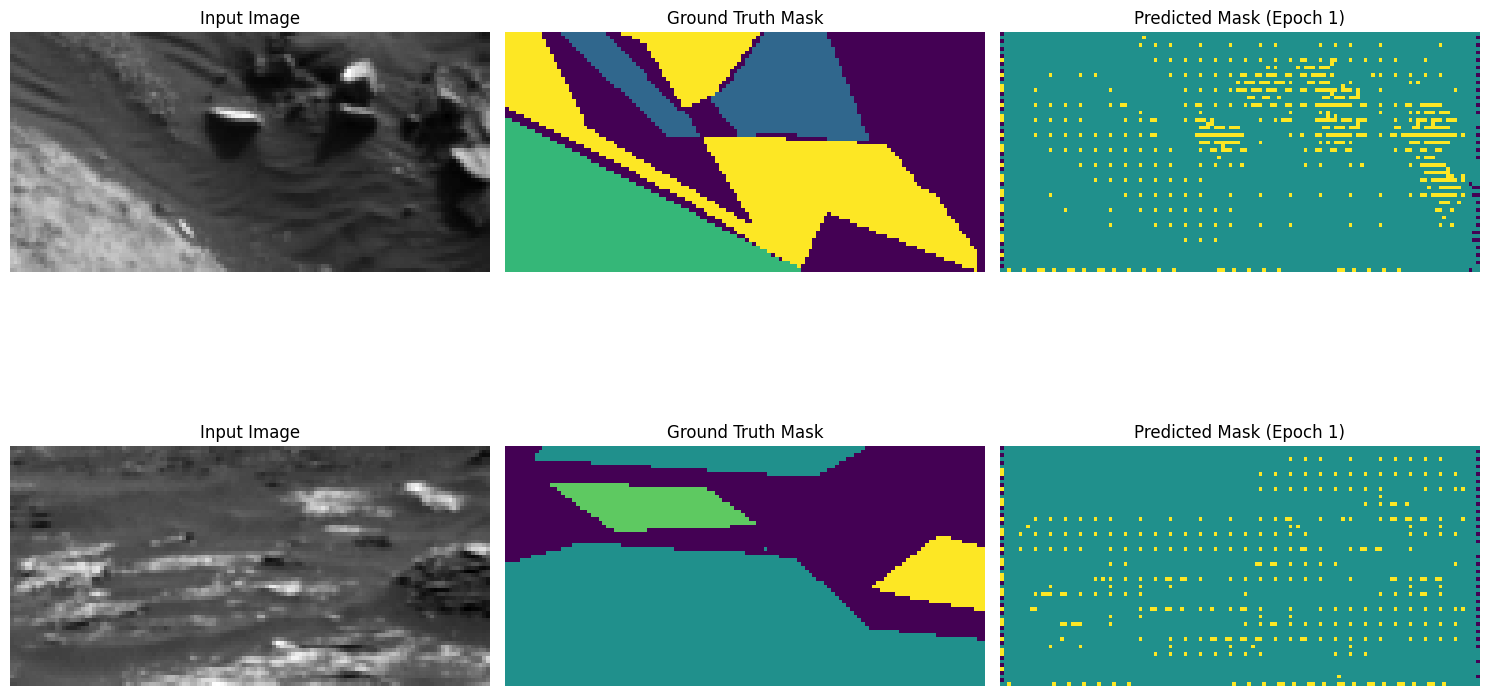

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 282ms/step - accuracy: 0.3212 - loss: 1.4614 - mean_io_u_2: 0.0992 - val_accuracy: 0.3498 - val_loss: 1.3748 - val_mean_io_u_2: 0.0987 - learning_rate: 1.0000e-04
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.3231 - loss: 1.3601 - mean_io_u_2: 0.1003
Epoch 2: val_loss improved from 1.37480 to 1.31896, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


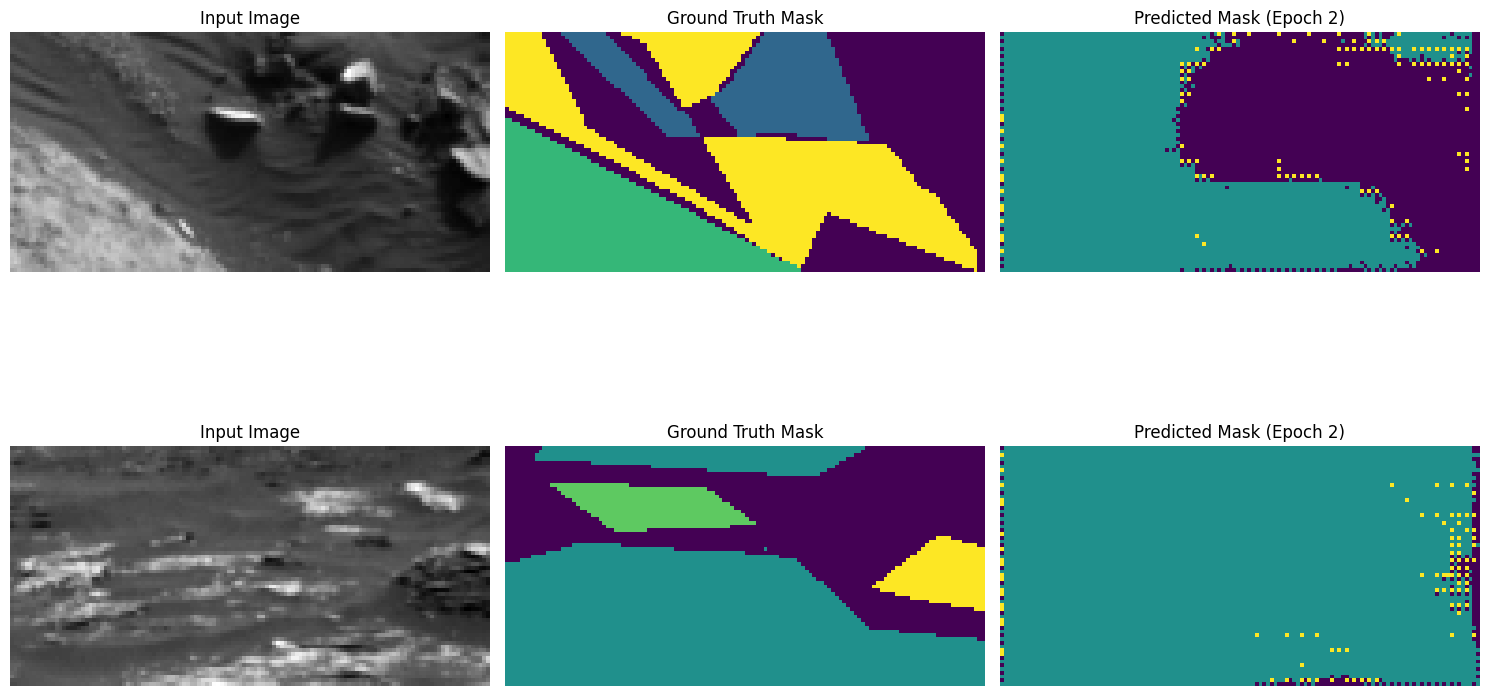

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.3234 - loss: 1.3600 - mean_io_u_2: 0.1003 - val_accuracy: 0.3923 - val_loss: 1.3190 - val_mean_io_u_2: 0.0941 - learning_rate: 1.0000e-04
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3853 - loss: 1.2937 - mean_io_u_2: 0.1182
Epoch 3: val_loss improved from 1.31896 to 1.19107, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


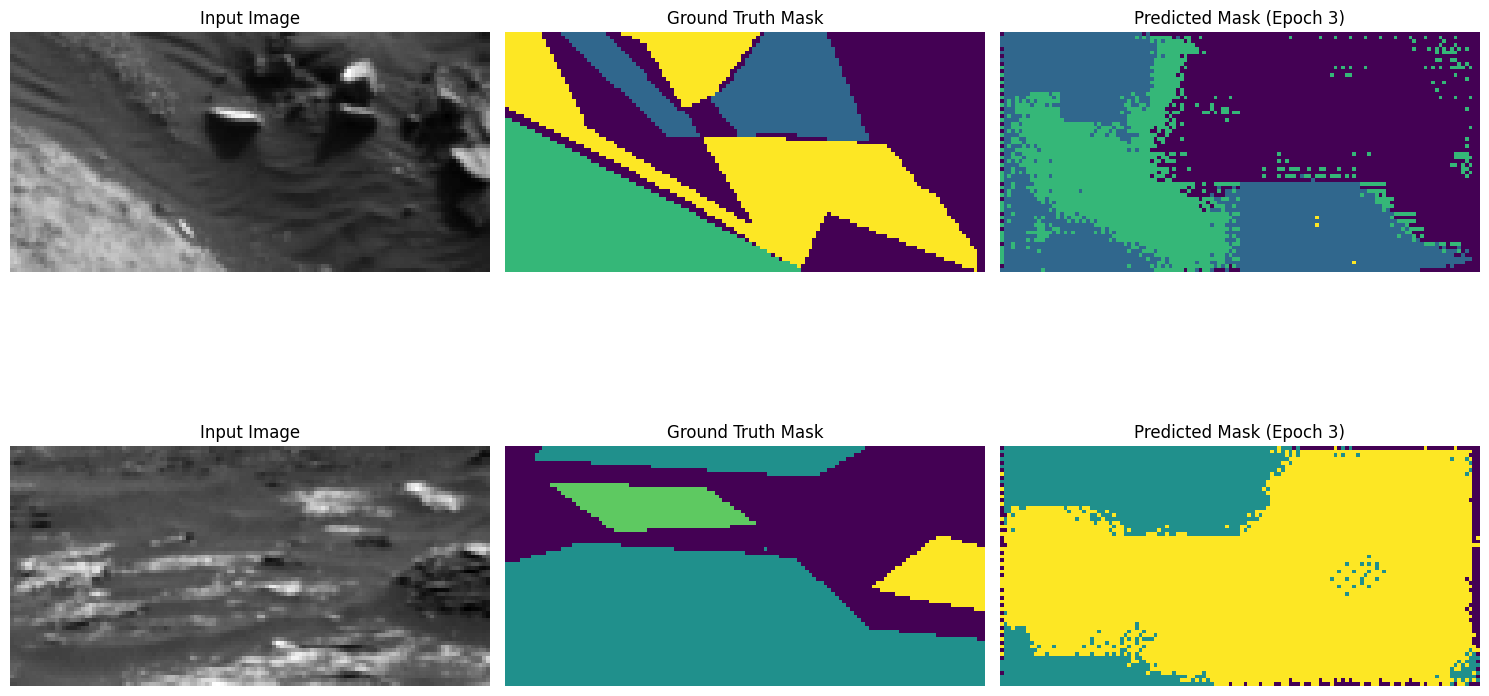

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.3856 - loss: 1.2932 - mean_io_u_2: 0.1187 - val_accuracy: 0.4551 - val_loss: 1.1911 - val_mean_io_u_2: 0.2262 - learning_rate: 1.0000e-04
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4233 - loss: 1.2248 - mean_io_u_2: 0.1882
Epoch 4: val_loss did not improve from 1.19107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


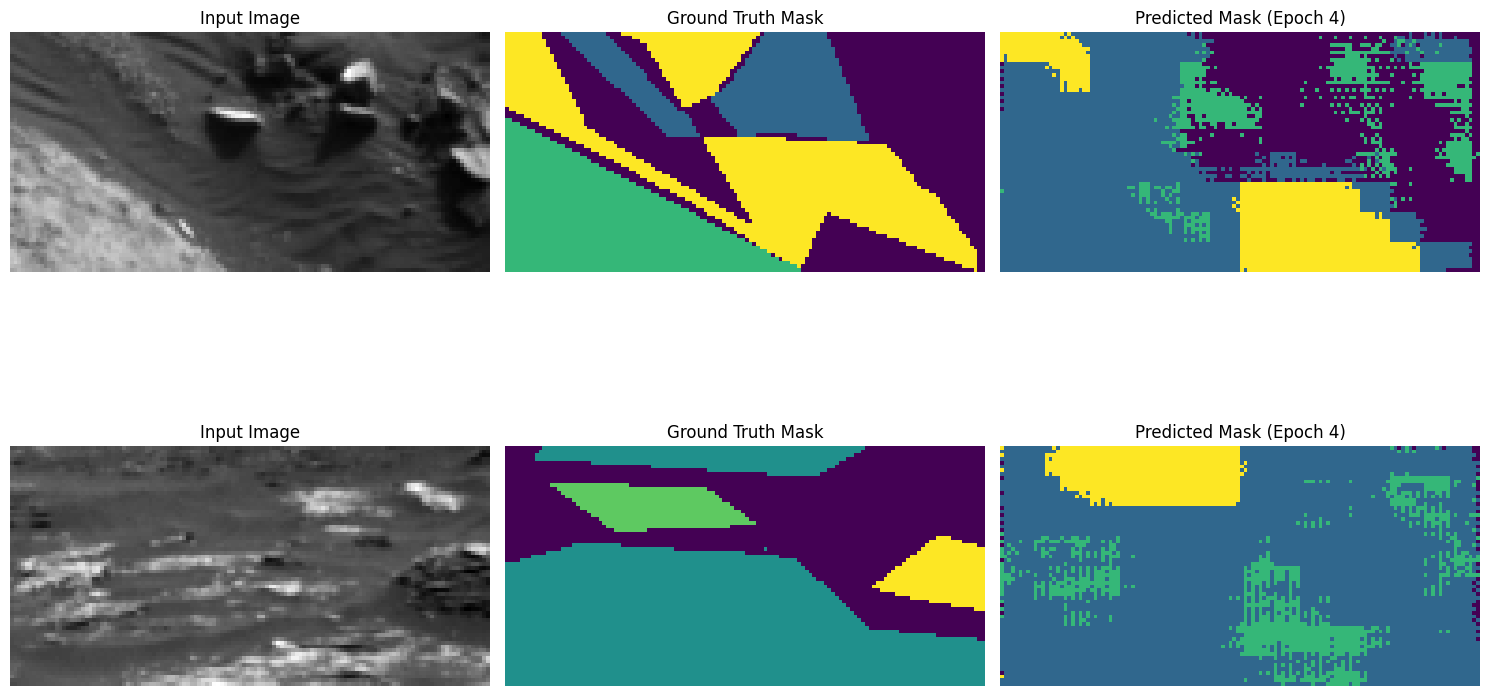

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.4234 - loss: 1.2245 - mean_io_u_2: 0.1883 - val_accuracy: 0.4508 - val_loss: 1.2071 - val_mean_io_u_2: 0.2168 - learning_rate: 1.0000e-04
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4463 - loss: 1.1846 - mean_io_u_2: 0.2156
Epoch 5: val_loss improved from 1.19107 to 1.13115, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


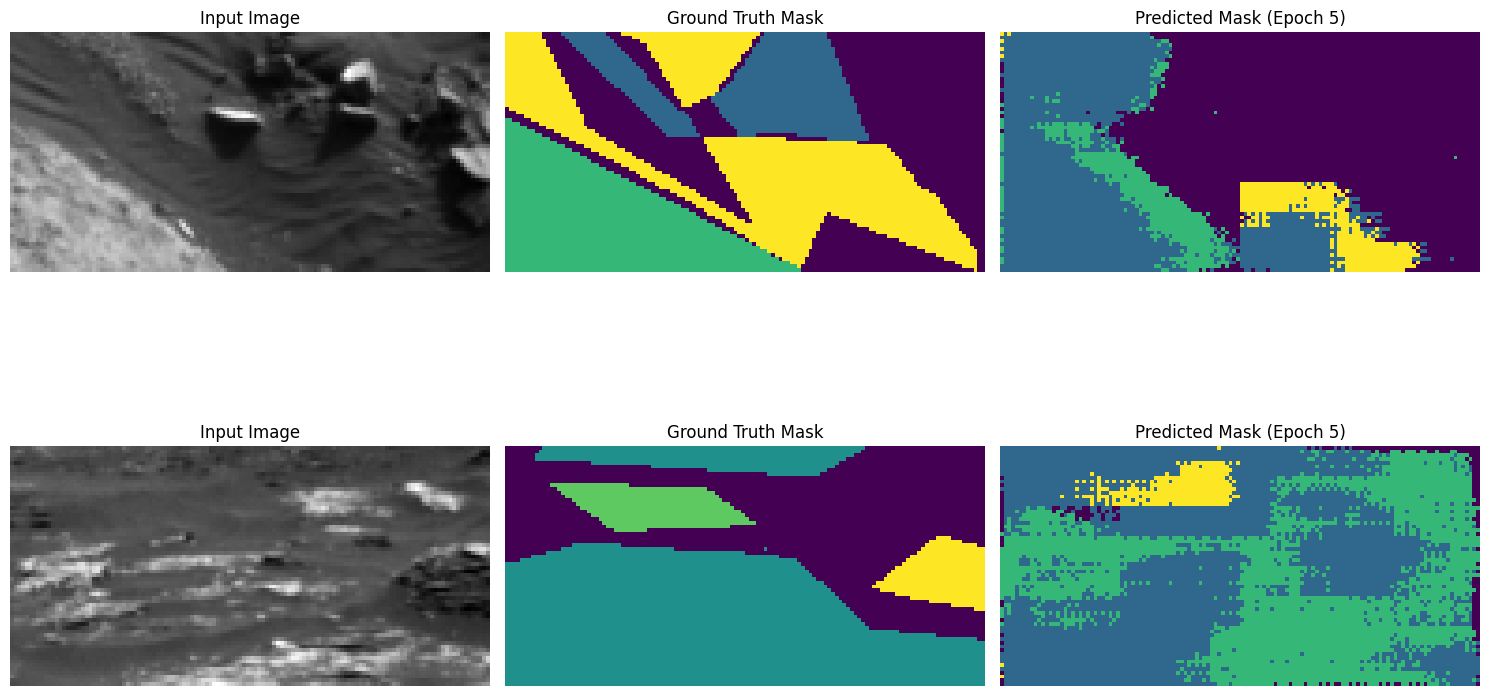

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.4466 - loss: 1.1842 - mean_io_u_2: 0.2157 - val_accuracy: 0.4960 - val_loss: 1.1311 - val_mean_io_u_2: 0.2399 - learning_rate: 1.0000e-04
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4822 - loss: 1.1384 - mean_io_u_2: 0.2275
Epoch 6: val_loss improved from 1.13115 to 1.10135, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


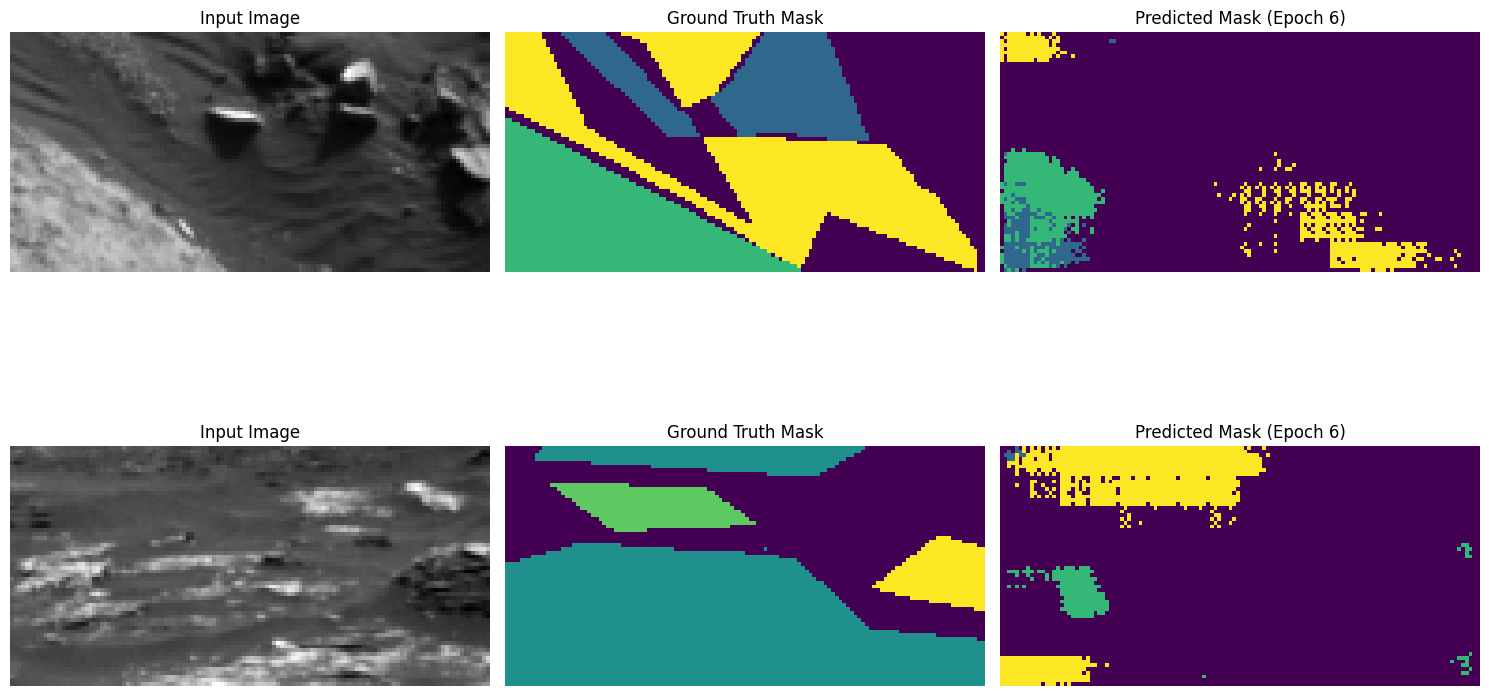

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.4825 - loss: 1.1381 - mean_io_u_2: 0.2276 - val_accuracy: 0.5121 - val_loss: 1.1014 - val_mean_io_u_2: 0.2214 - learning_rate: 1.0000e-04
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5243 - loss: 1.0797 - mean_io_u_2: 0.2472
Epoch 7: val_loss improved from 1.10135 to 1.08636, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


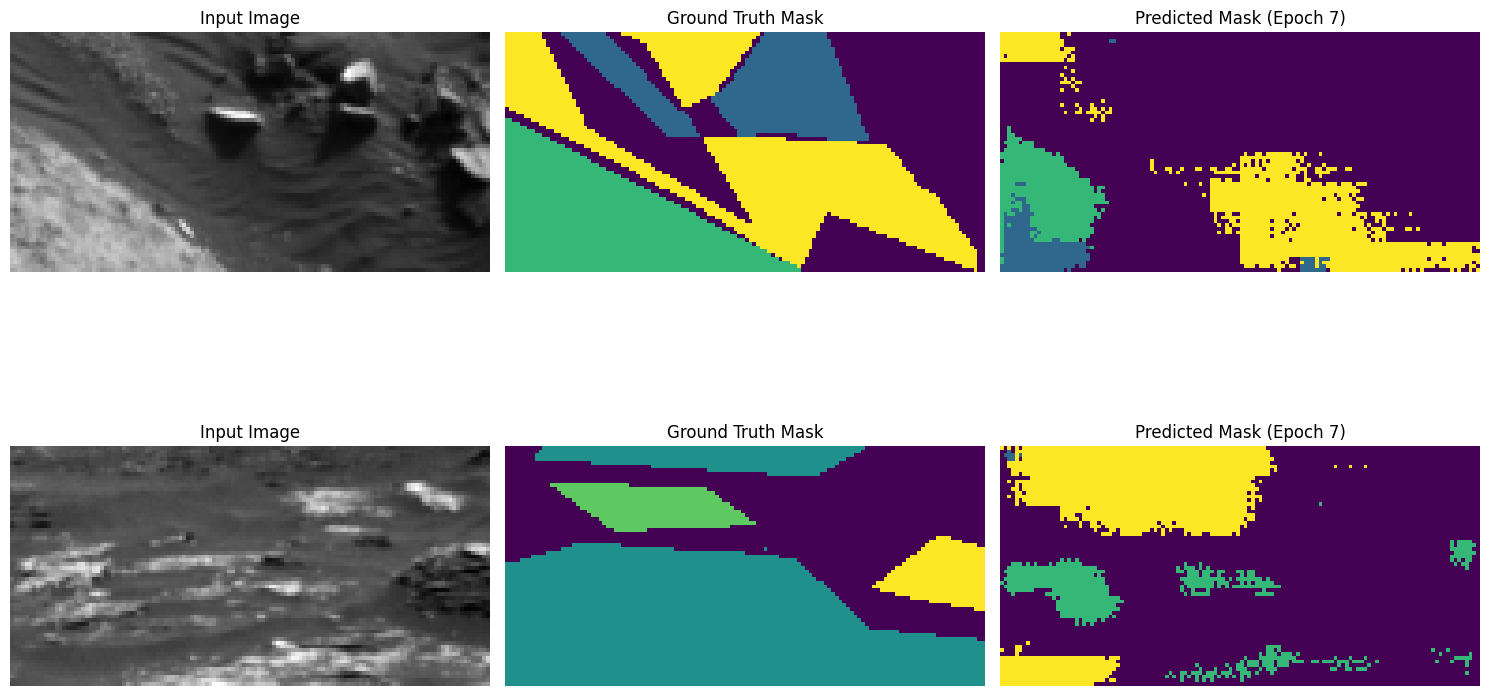

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.5245 - loss: 1.0794 - mean_io_u_2: 0.2473 - val_accuracy: 0.5560 - val_loss: 1.0864 - val_mean_io_u_2: 0.2580 - learning_rate: 1.0000e-04
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5508 - loss: 1.0488 - mean_io_u_2: 0.2640
Epoch 8: val_loss improved from 1.08636 to 1.04174, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


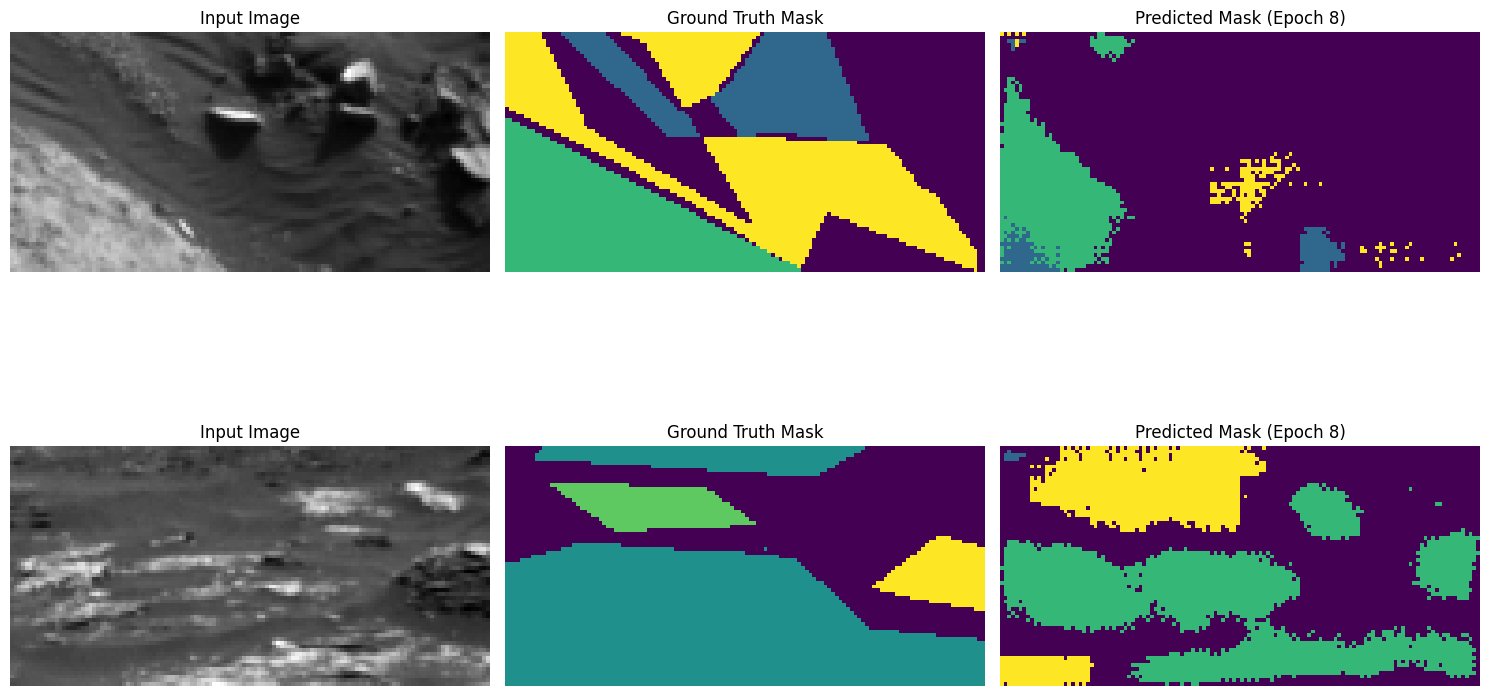

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.5507 - loss: 1.0489 - mean_io_u_2: 0.2639 - val_accuracy: 0.5729 - val_loss: 1.0417 - val_mean_io_u_2: 0.2914 - learning_rate: 1.0000e-04
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5555 - loss: 1.0404 - mean_io_u_2: 0.2731
Epoch 9: val_loss did not improve from 1.04174
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


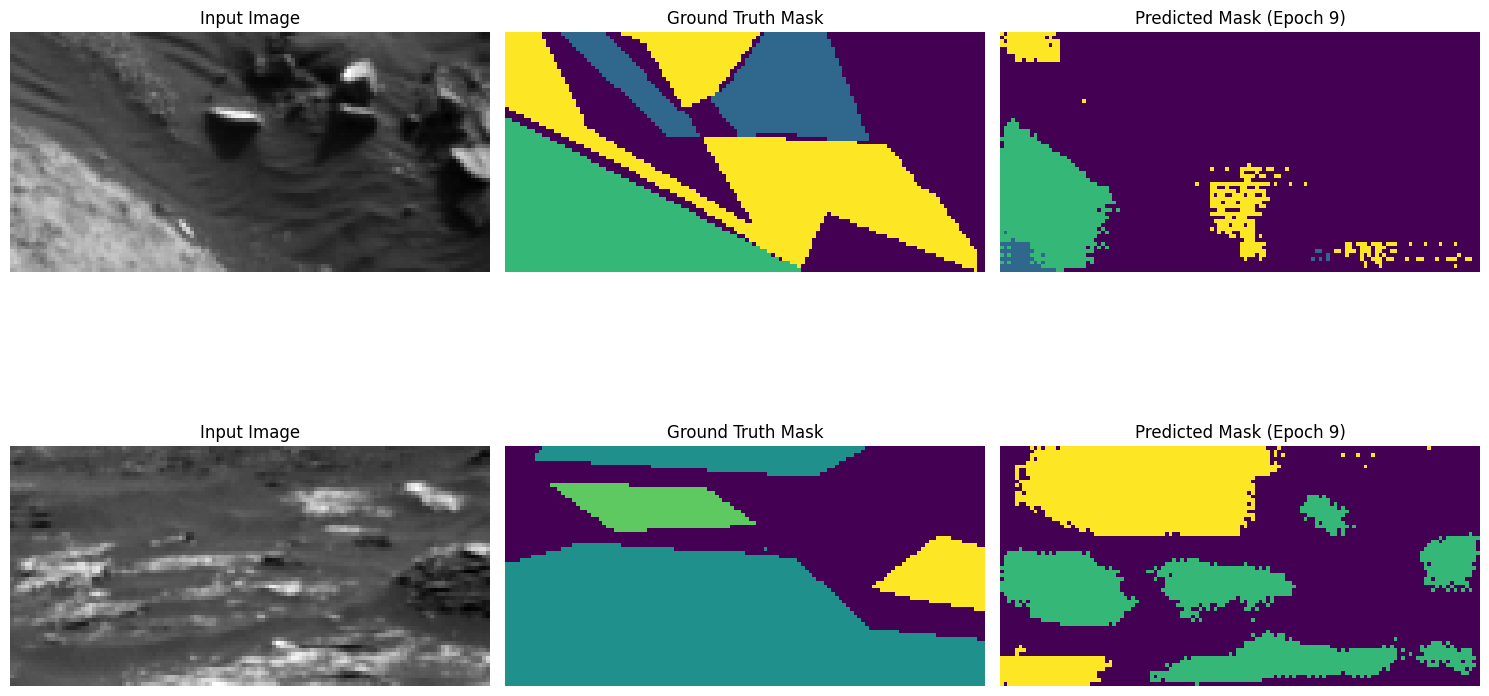

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.5556 - loss: 1.0402 - mean_io_u_2: 0.2731 - val_accuracy: 0.5791 - val_loss: 1.0632 - val_mean_io_u_2: 0.2926 - learning_rate: 1.0000e-04
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5707 - loss: 1.0166 - mean_io_u_2: 0.2851
Epoch 10: val_loss improved from 1.04174 to 1.04091, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


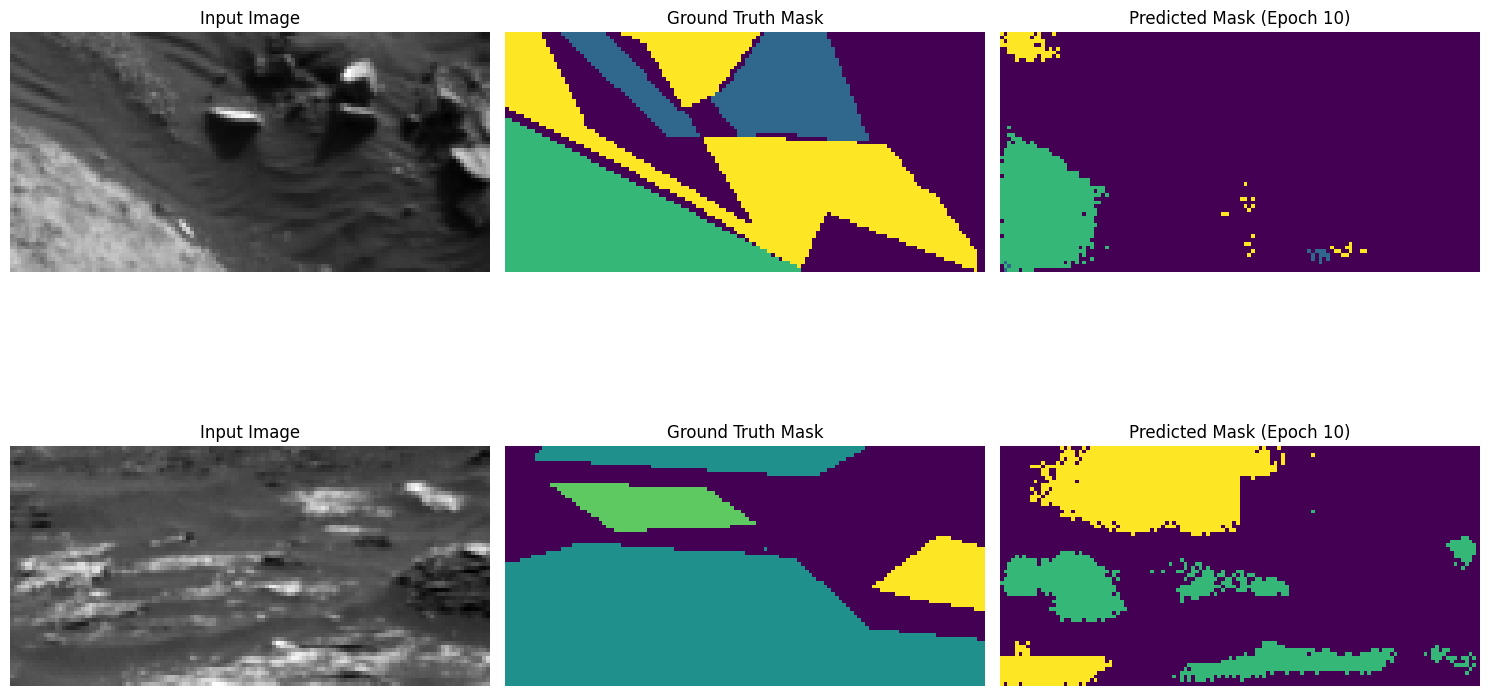

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.5709 - loss: 1.0164 - mean_io_u_2: 0.2852 - val_accuracy: 0.5644 - val_loss: 1.0409 - val_mean_io_u_2: 0.2744 - learning_rate: 1.0000e-04
Epoch 11/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5867 - loss: 0.9888 - mean_io_u_2: 0.2985
Epoch 11: val_loss improved from 1.04091 to 0.97639, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


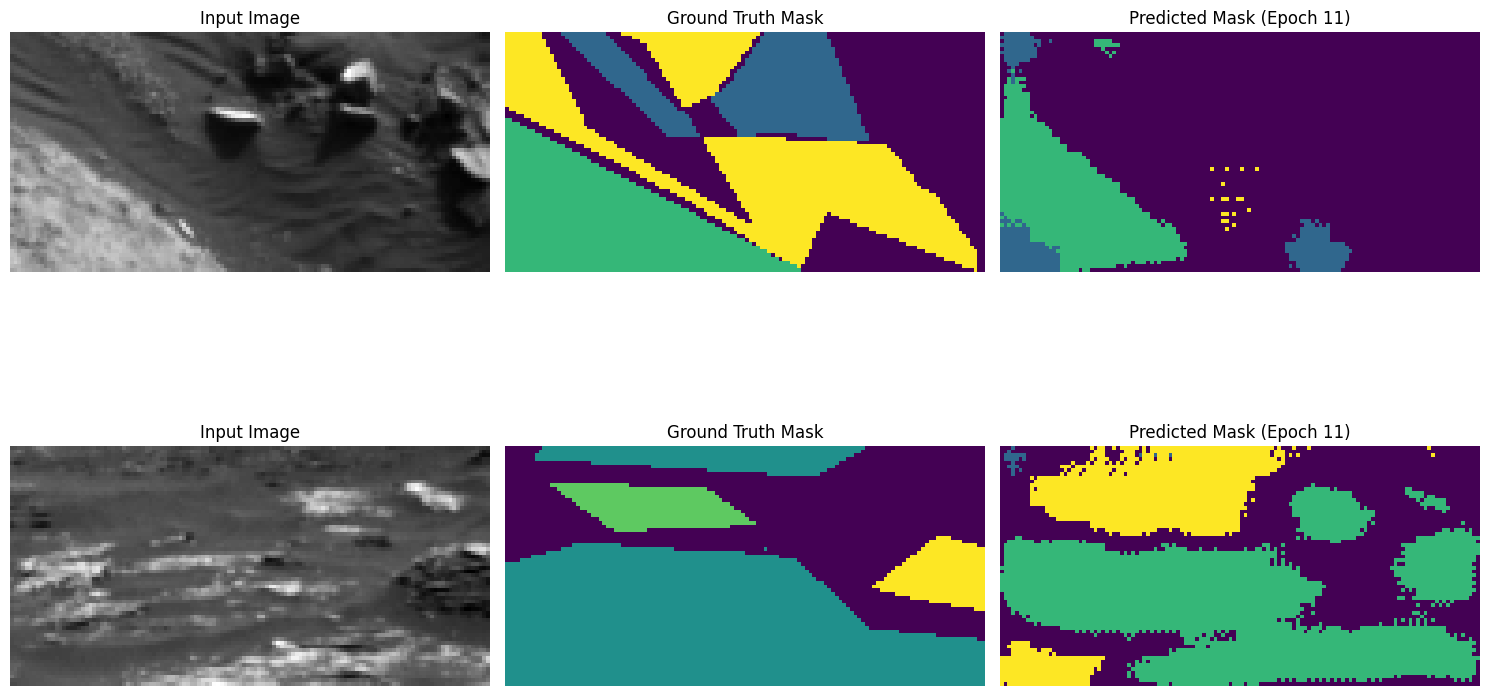

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.5866 - loss: 0.9887 - mean_io_u_2: 0.2984 - val_accuracy: 0.6022 - val_loss: 0.9764 - val_mean_io_u_2: 0.3057 - learning_rate: 1.0000e-04
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5710 - loss: 1.0033 - mean_io_u_2: 0.2869
Epoch 12: val_loss did not improve from 0.97639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


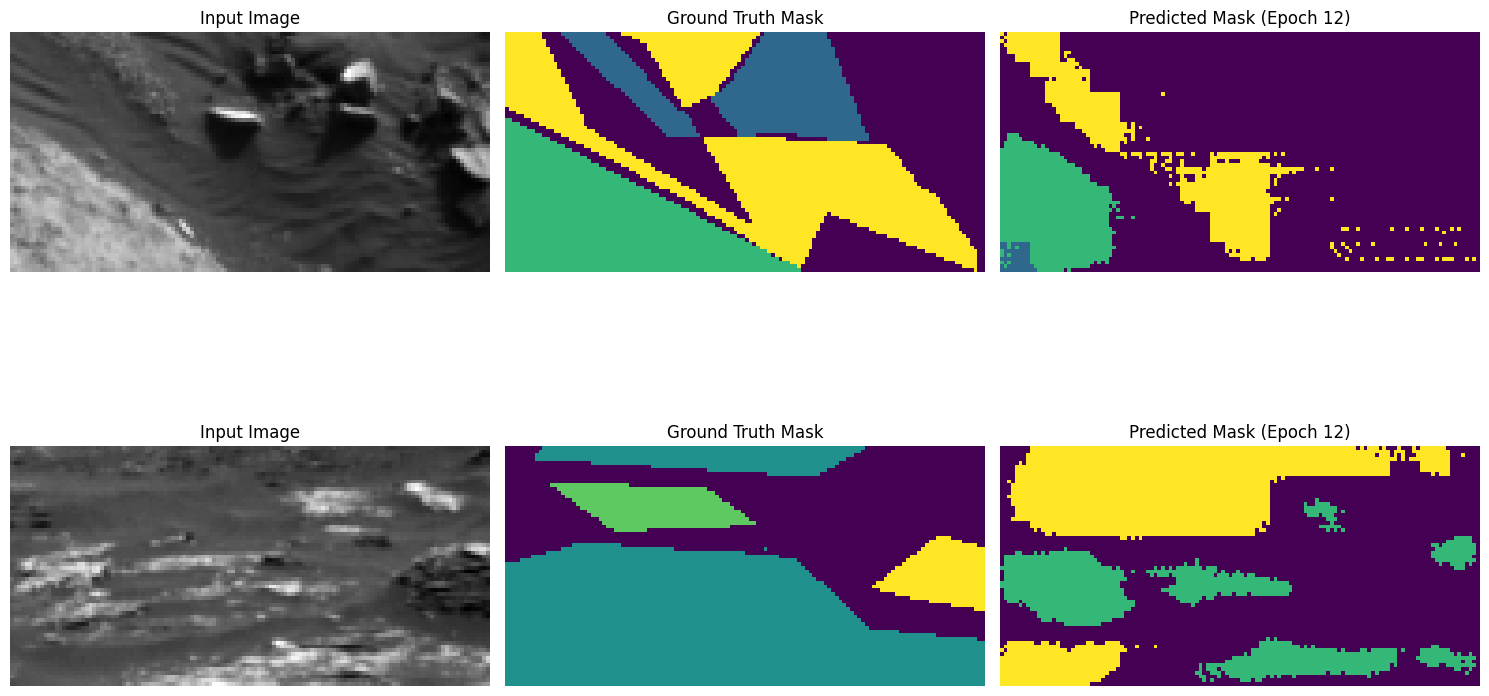

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.5712 - loss: 1.0031 - mean_io_u_2: 0.2870 - val_accuracy: 0.5824 - val_loss: 1.0629 - val_mean_io_u_2: 0.3014 - learning_rate: 1.0000e-04
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5937 - loss: 0.9793 - mean_io_u_2: 0.3043
Epoch 13: val_loss did not improve from 0.97639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


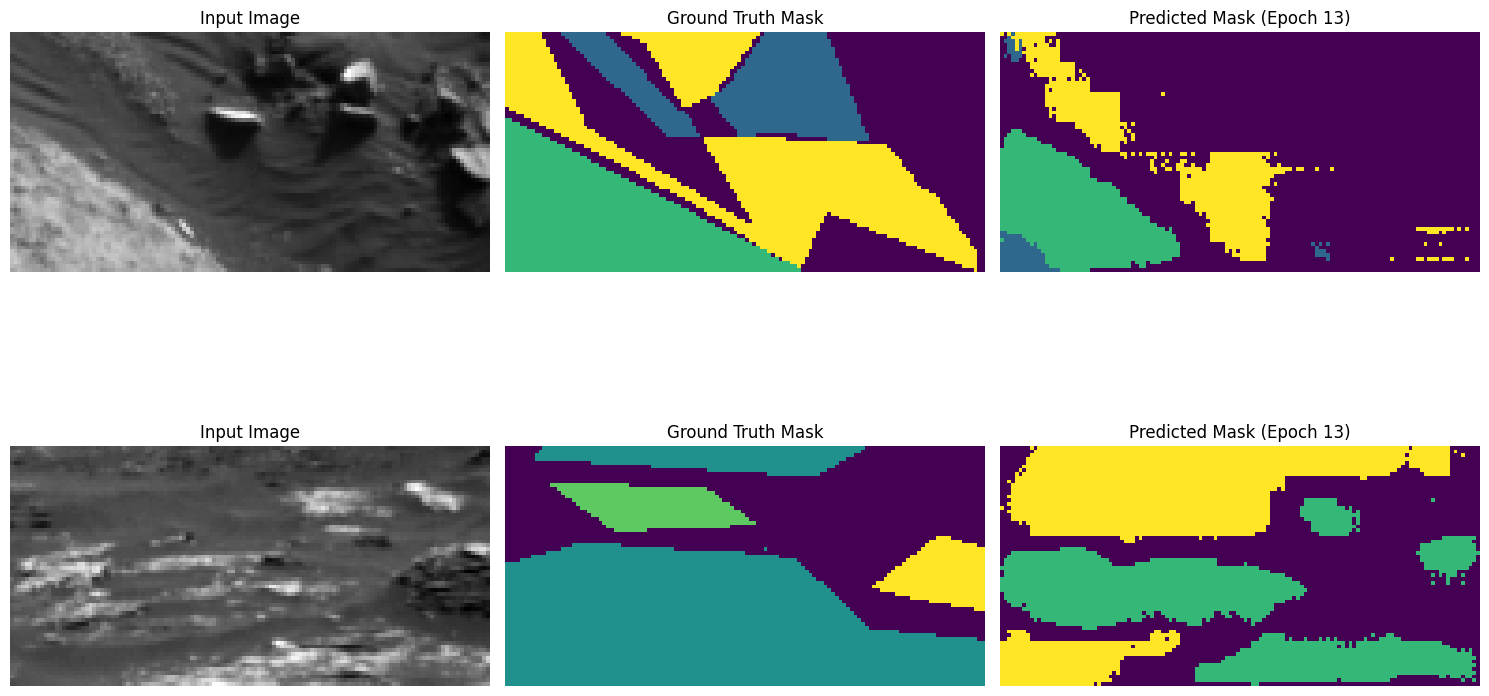

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.5938 - loss: 0.9791 - mean_io_u_2: 0.3043 - val_accuracy: 0.6104 - val_loss: 0.9873 - val_mean_io_u_2: 0.3234 - learning_rate: 1.0000e-04
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5922 - loss: 0.9761 - mean_io_u_2: 0.3028
Epoch 14: val_loss improved from 0.97639 to 0.97106, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


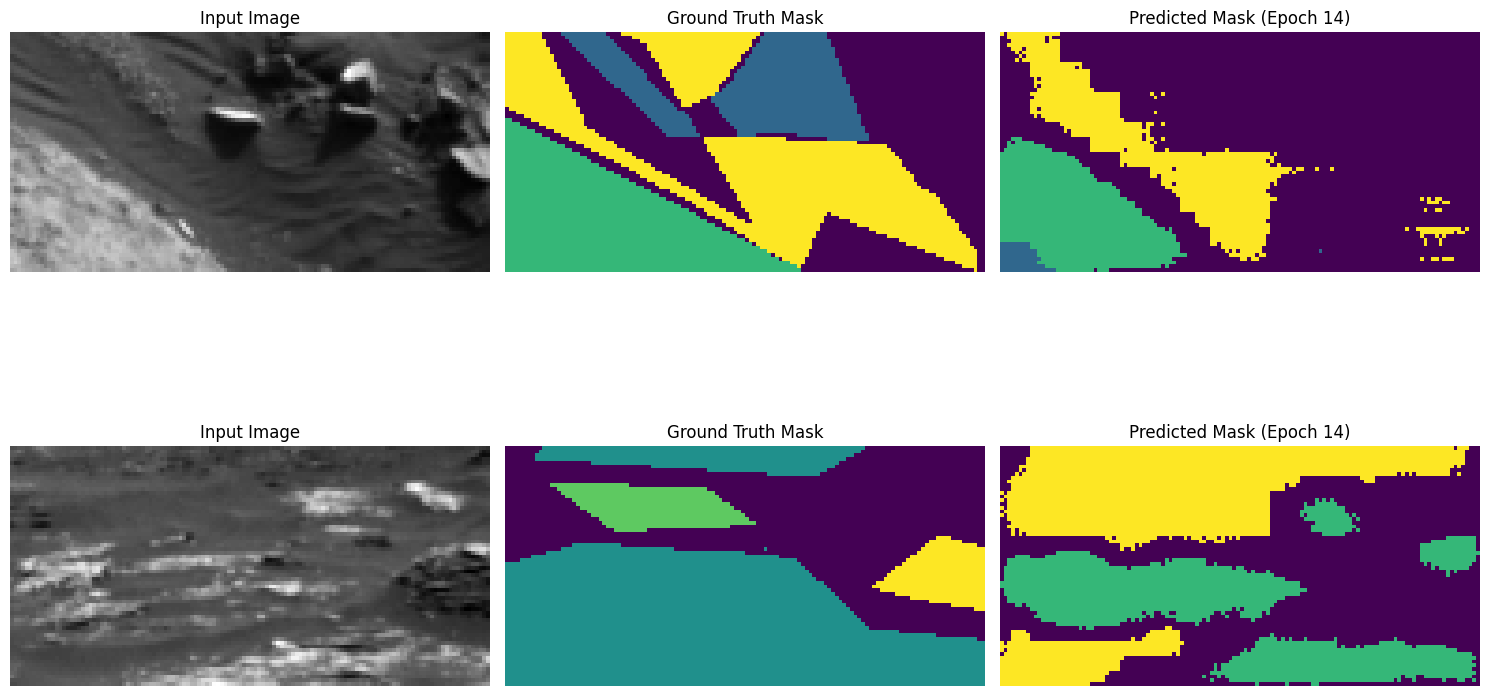

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.5924 - loss: 0.9758 - mean_io_u_2: 0.3029 - val_accuracy: 0.6222 - val_loss: 0.9711 - val_mean_io_u_2: 0.3345 - learning_rate: 1.0000e-04
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6062 - loss: 0.9638 - mean_io_u_2: 0.3145
Epoch 15: val_loss improved from 0.97106 to 0.95147, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


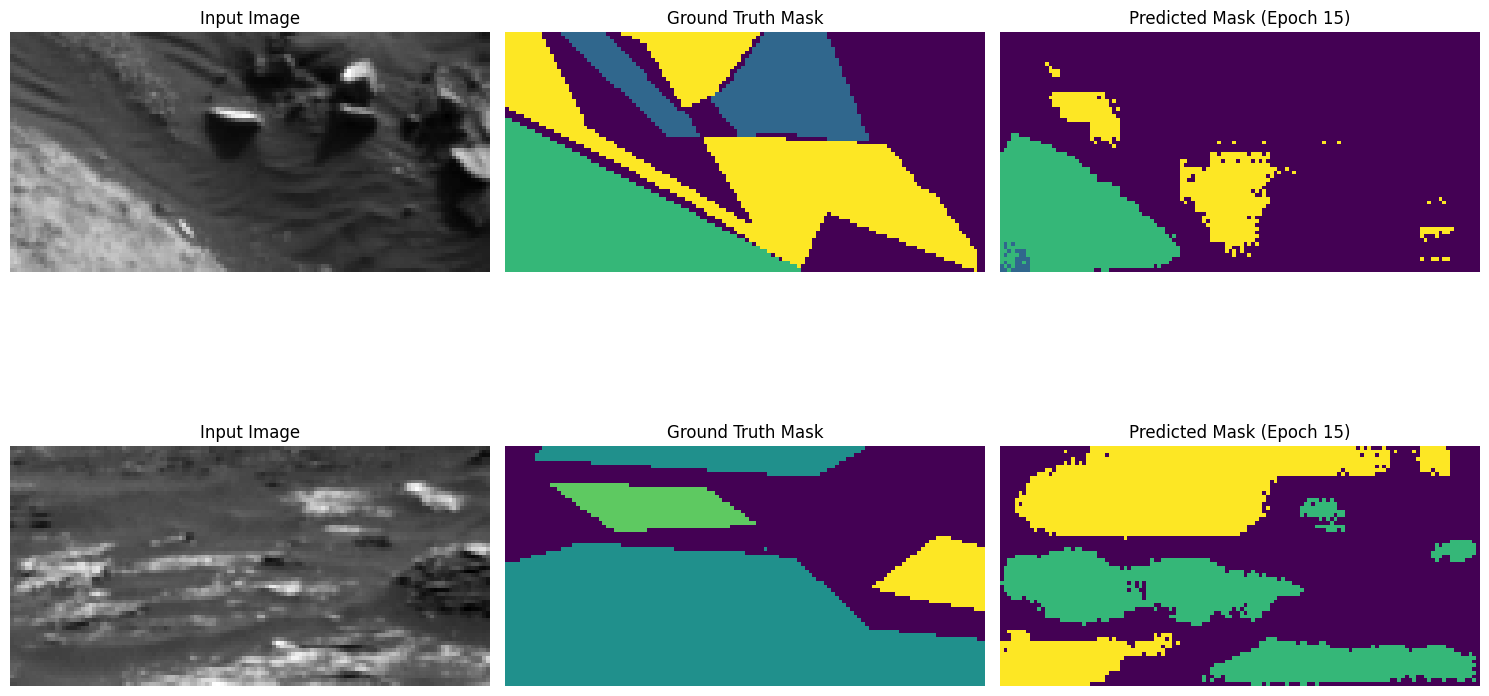

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6063 - loss: 0.9635 - mean_io_u_2: 0.3146 - val_accuracy: 0.6341 - val_loss: 0.9515 - val_mean_io_u_2: 0.3401 - learning_rate: 1.0000e-04
Epoch 16/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6175 - loss: 0.9405 - mean_io_u_2: 0.3255
Epoch 16: val_loss improved from 0.95147 to 0.91688, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


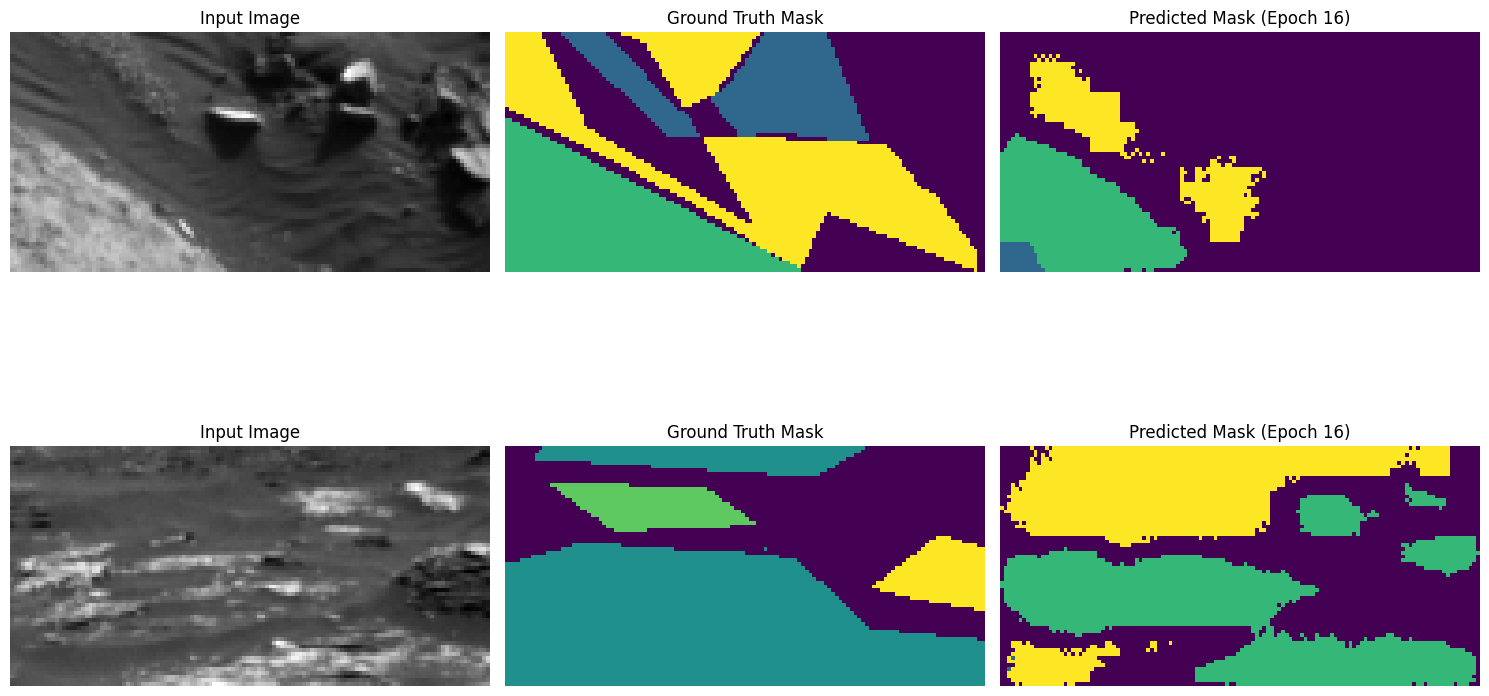

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.6176 - loss: 0.9403 - mean_io_u_2: 0.3256 - val_accuracy: 0.6407 - val_loss: 0.9169 - val_mean_io_u_2: 0.3487 - learning_rate: 1.0000e-04
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6299 - loss: 0.9339 - mean_io_u_2: 0.3335
Epoch 17: val_loss did not improve from 0.91688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


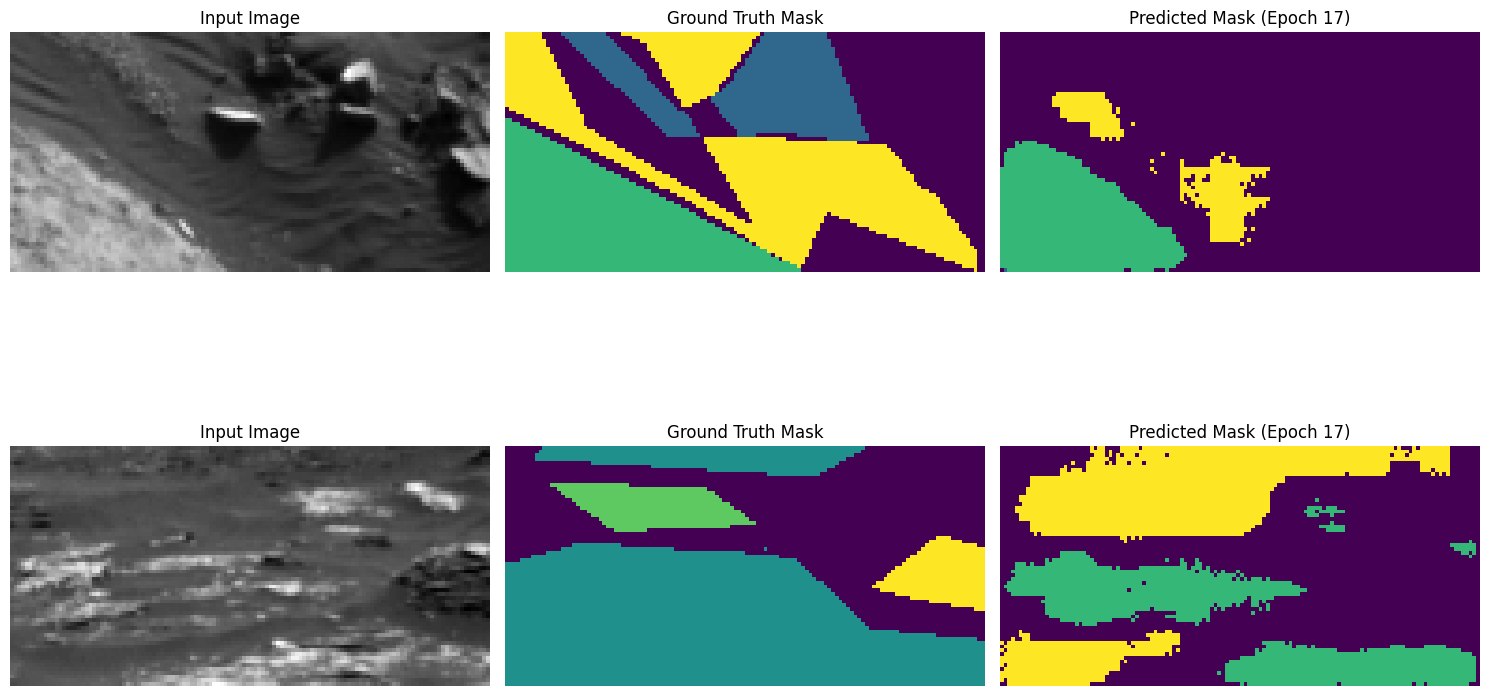

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.6300 - loss: 0.9336 - mean_io_u_2: 0.3335 - val_accuracy: 0.6431 - val_loss: 0.9308 - val_mean_io_u_2: 0.3446 - learning_rate: 1.0000e-04
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6354 - loss: 0.9118 - mean_io_u_2: 0.3407
Epoch 18: val_loss improved from 0.91688 to 0.90230, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


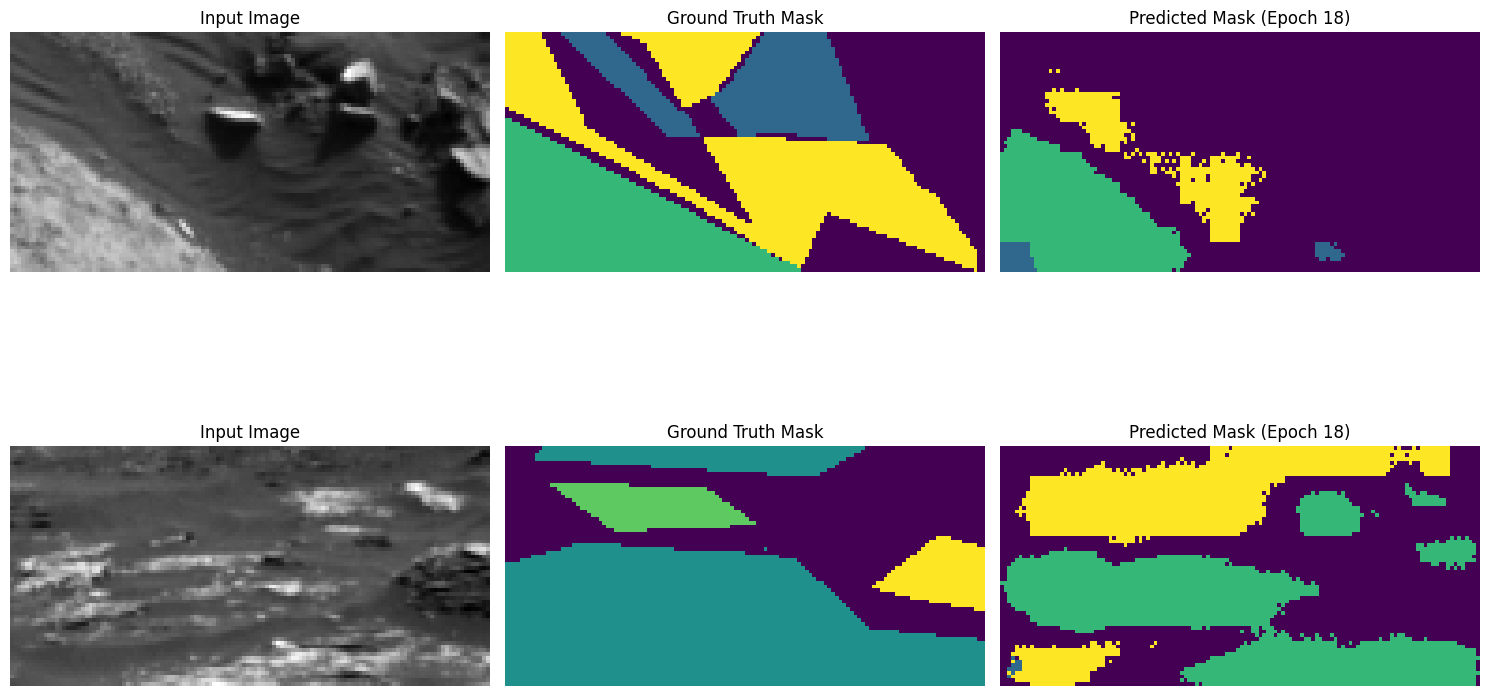

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6355 - loss: 0.9117 - mean_io_u_2: 0.3407 - val_accuracy: 0.6413 - val_loss: 0.9023 - val_mean_io_u_2: 0.3398 - learning_rate: 1.0000e-04
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6388 - loss: 0.9099 - mean_io_u_2: 0.3398
Epoch 19: val_loss improved from 0.90230 to 0.86786, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


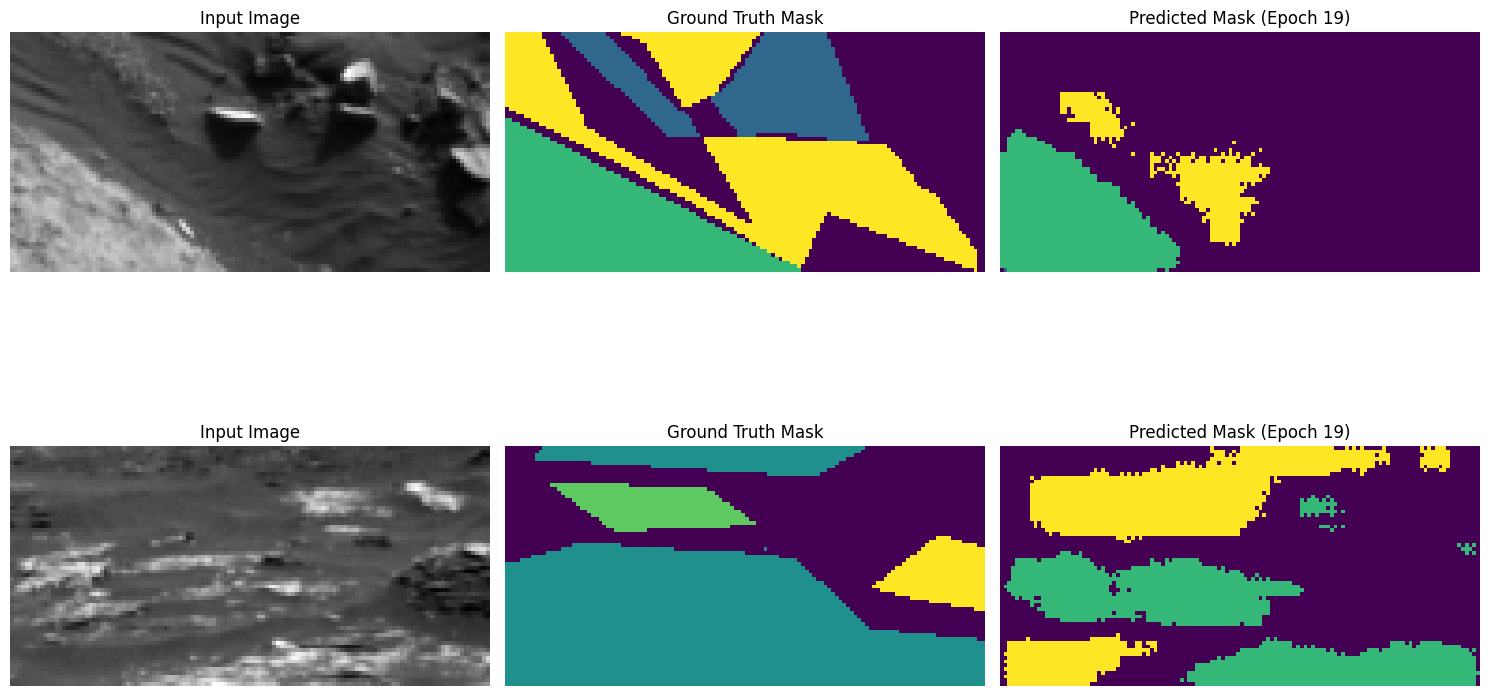

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6390 - loss: 0.9095 - mean_io_u_2: 0.3399 - val_accuracy: 0.6702 - val_loss: 0.8679 - val_mean_io_u_2: 0.3679 - learning_rate: 1.0000e-04
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6455 - loss: 0.8918 - mean_io_u_2: 0.3469
Epoch 20: val_loss improved from 0.86786 to 0.86079, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


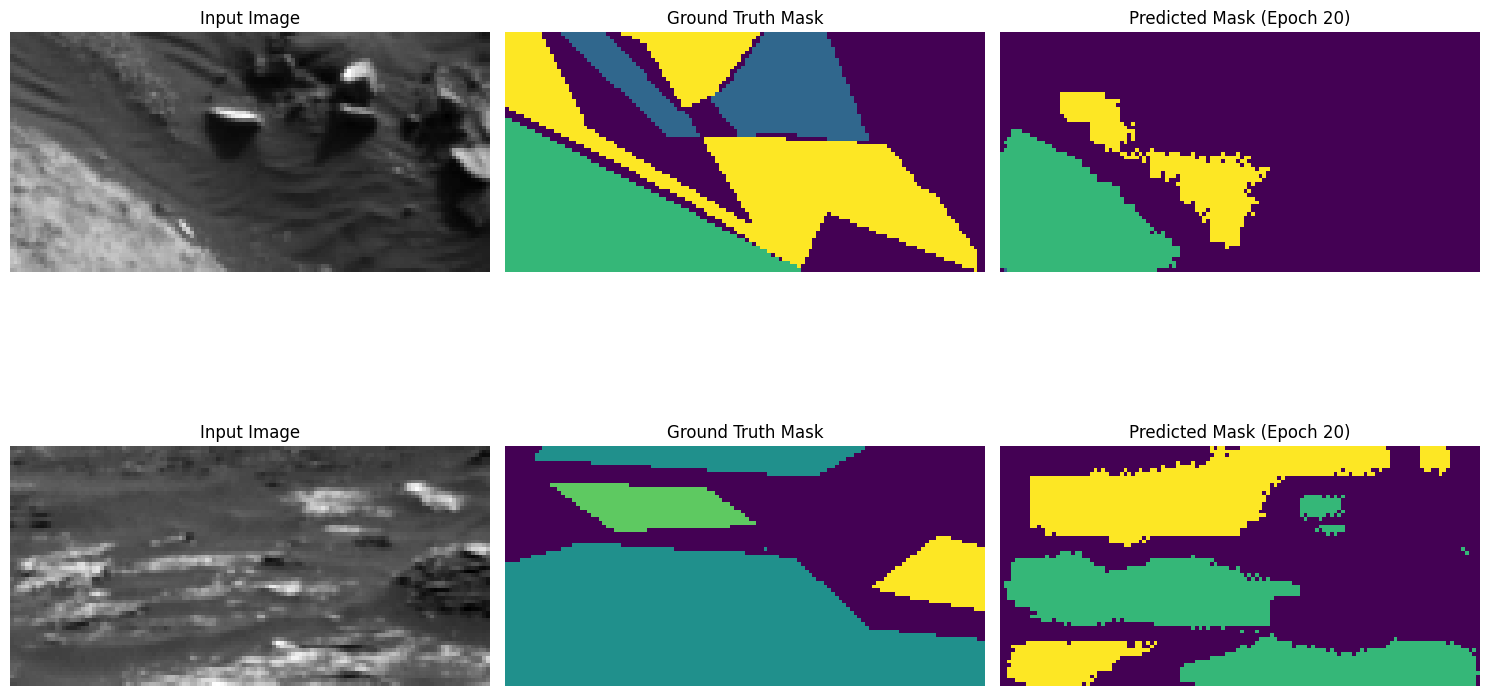

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6456 - loss: 0.8915 - mean_io_u_2: 0.3470 - val_accuracy: 0.6638 - val_loss: 0.8608 - val_mean_io_u_2: 0.3584 - learning_rate: 1.0000e-04
Epoch 21/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6515 - loss: 0.8818 - mean_io_u_2: 0.3505
Epoch 21: val_loss improved from 0.86079 to 0.84093, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


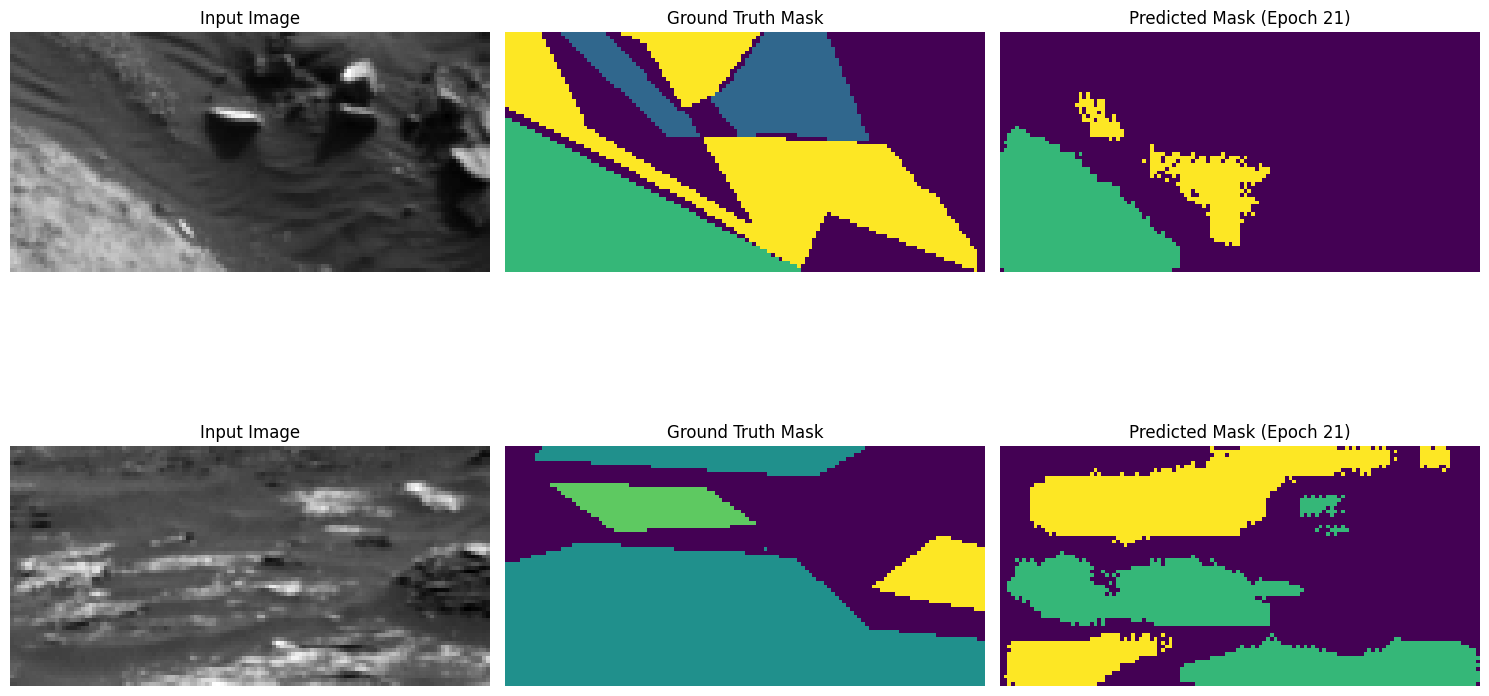

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6517 - loss: 0.8814 - mean_io_u_2: 0.3506 - val_accuracy: 0.6809 - val_loss: 0.8409 - val_mean_io_u_2: 0.3760 - learning_rate: 1.0000e-04
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6577 - loss: 0.8656 - mean_io_u_2: 0.3573
Epoch 22: val_loss improved from 0.84093 to 0.83181, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


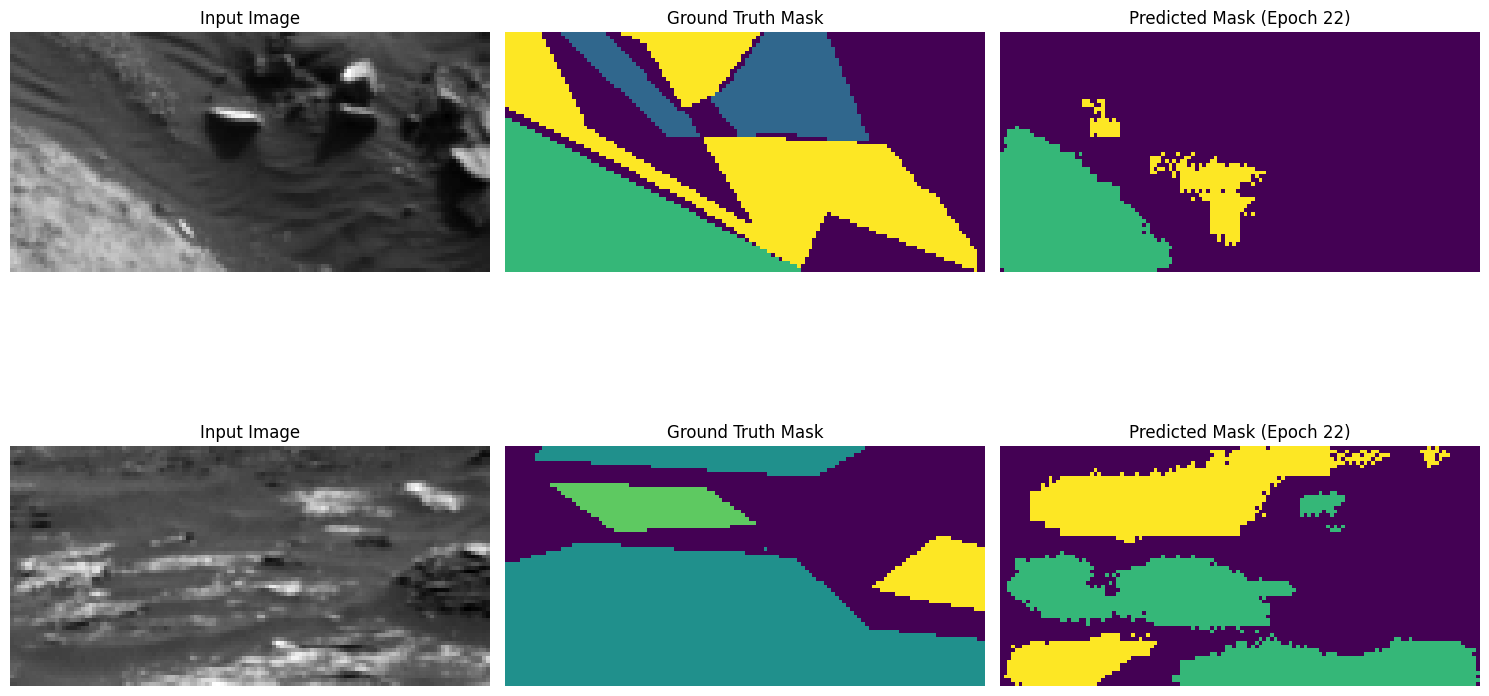

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6579 - loss: 0.8653 - mean_io_u_2: 0.3574 - val_accuracy: 0.6828 - val_loss: 0.8318 - val_mean_io_u_2: 0.3756 - learning_rate: 1.0000e-04
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6595 - loss: 0.8600 - mean_io_u_2: 0.3578
Epoch 23: val_loss improved from 0.83181 to 0.82350, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


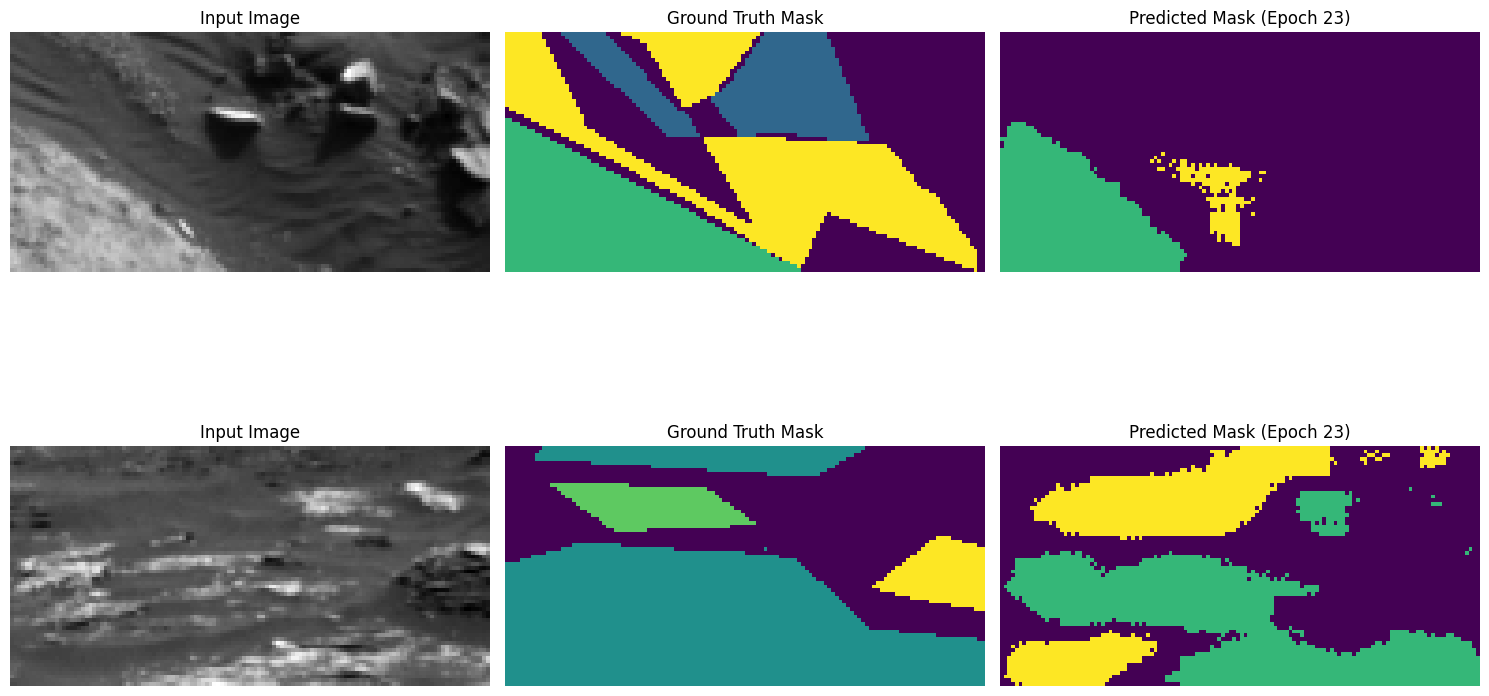

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6597 - loss: 0.8595 - mean_io_u_2: 0.3580 - val_accuracy: 0.6887 - val_loss: 0.8235 - val_mean_io_u_2: 0.3823 - learning_rate: 1.0000e-04
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6695 - loss: 0.8386 - mean_io_u_2: 0.3673
Epoch 24: val_loss improved from 0.82350 to 0.81178, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


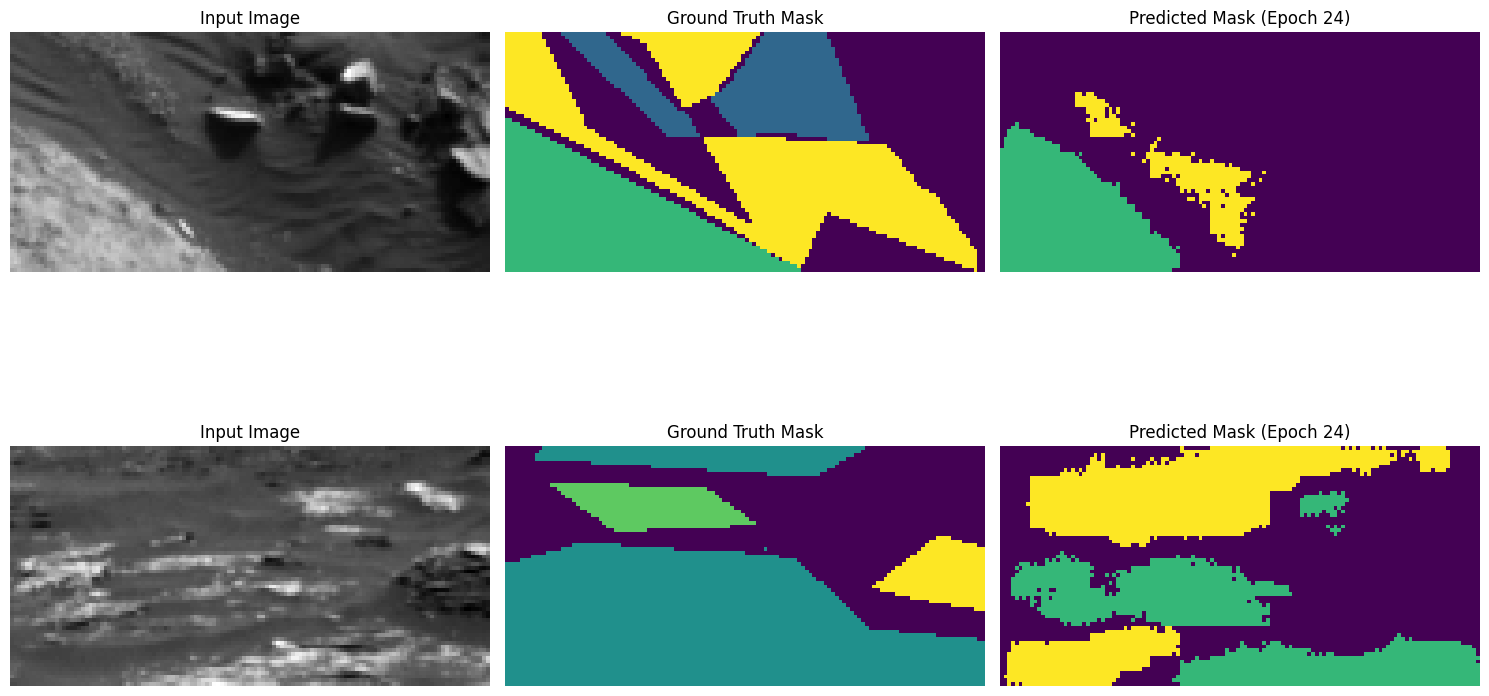

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6697 - loss: 0.8383 - mean_io_u_2: 0.3674 - val_accuracy: 0.6943 - val_loss: 0.8118 - val_mean_io_u_2: 0.3872 - learning_rate: 1.0000e-04
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6685 - loss: 0.8393 - mean_io_u_2: 0.3661
Epoch 25: val_loss improved from 0.81178 to 0.80617, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


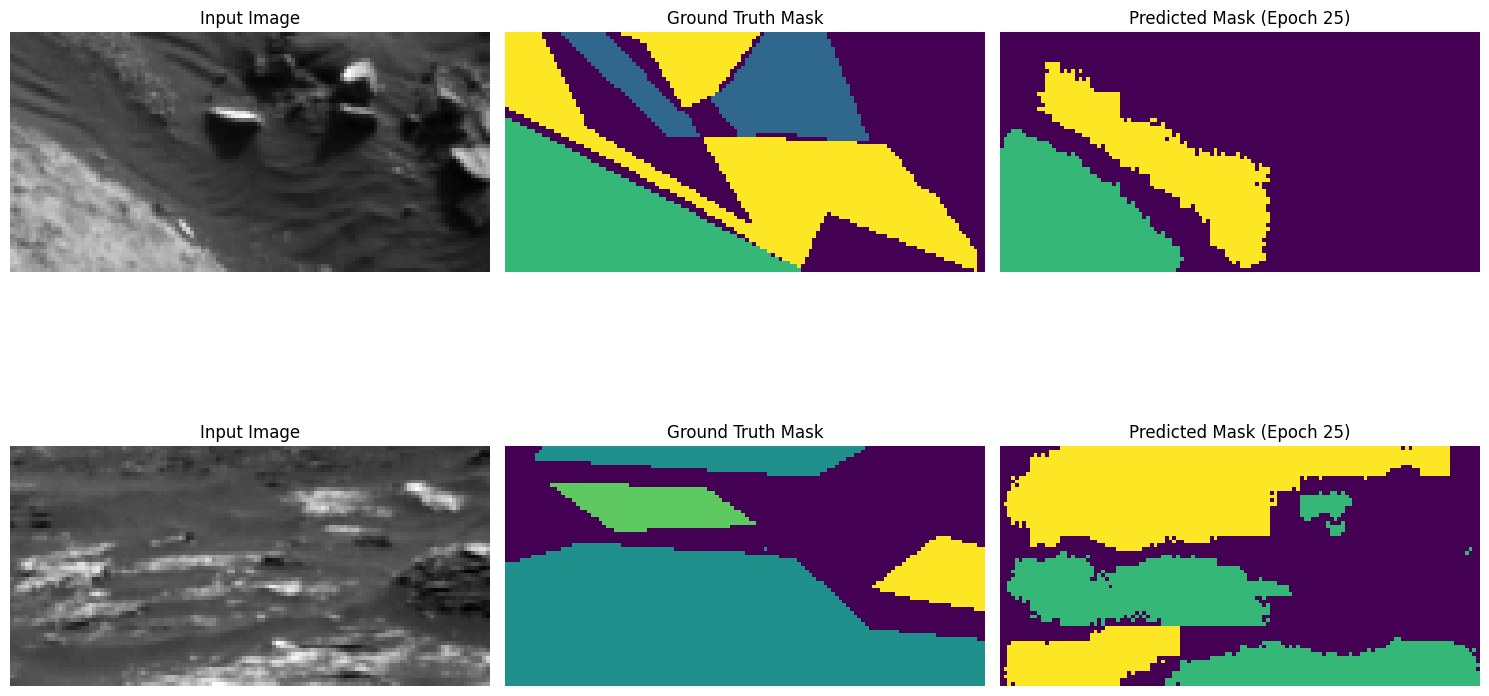

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6687 - loss: 0.8389 - mean_io_u_2: 0.3662 - val_accuracy: 0.6969 - val_loss: 0.8062 - val_mean_io_u_2: 0.3970 - learning_rate: 1.0000e-04
Epoch 26/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6771 - loss: 0.8306 - mean_io_u_2: 0.3739
Epoch 26: val_loss improved from 0.80617 to 0.79424, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


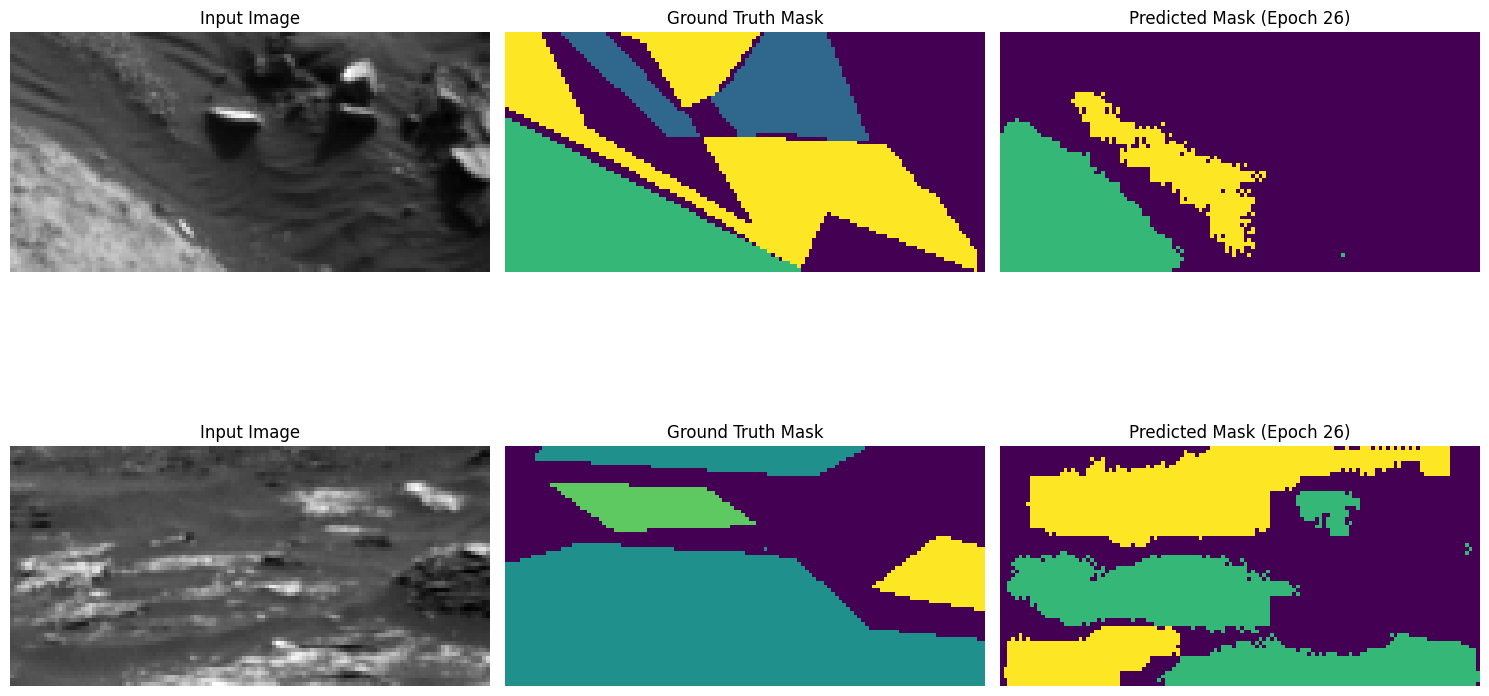

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6772 - loss: 0.8302 - mean_io_u_2: 0.3740 - val_accuracy: 0.6996 - val_loss: 0.7942 - val_mean_io_u_2: 0.3957 - learning_rate: 1.0000e-04
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6777 - loss: 0.8196 - mean_io_u_2: 0.3744
Epoch 27: val_loss improved from 0.79424 to 0.78583, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


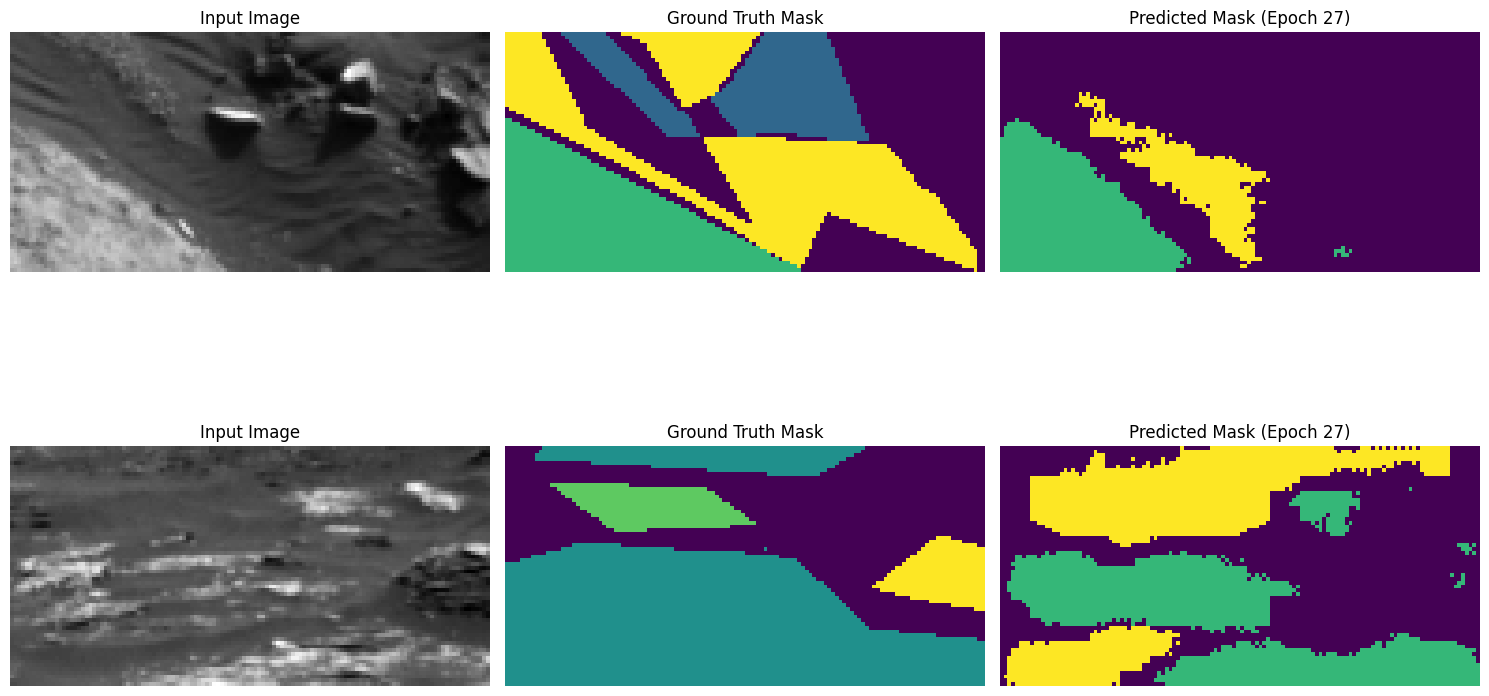

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.6779 - loss: 0.8192 - mean_io_u_2: 0.3745 - val_accuracy: 0.7028 - val_loss: 0.7858 - val_mean_io_u_2: 0.3989 - learning_rate: 1.0000e-04
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6817 - loss: 0.8137 - mean_io_u_2: 0.3775
Epoch 28: val_loss improved from 0.78583 to 0.77808, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


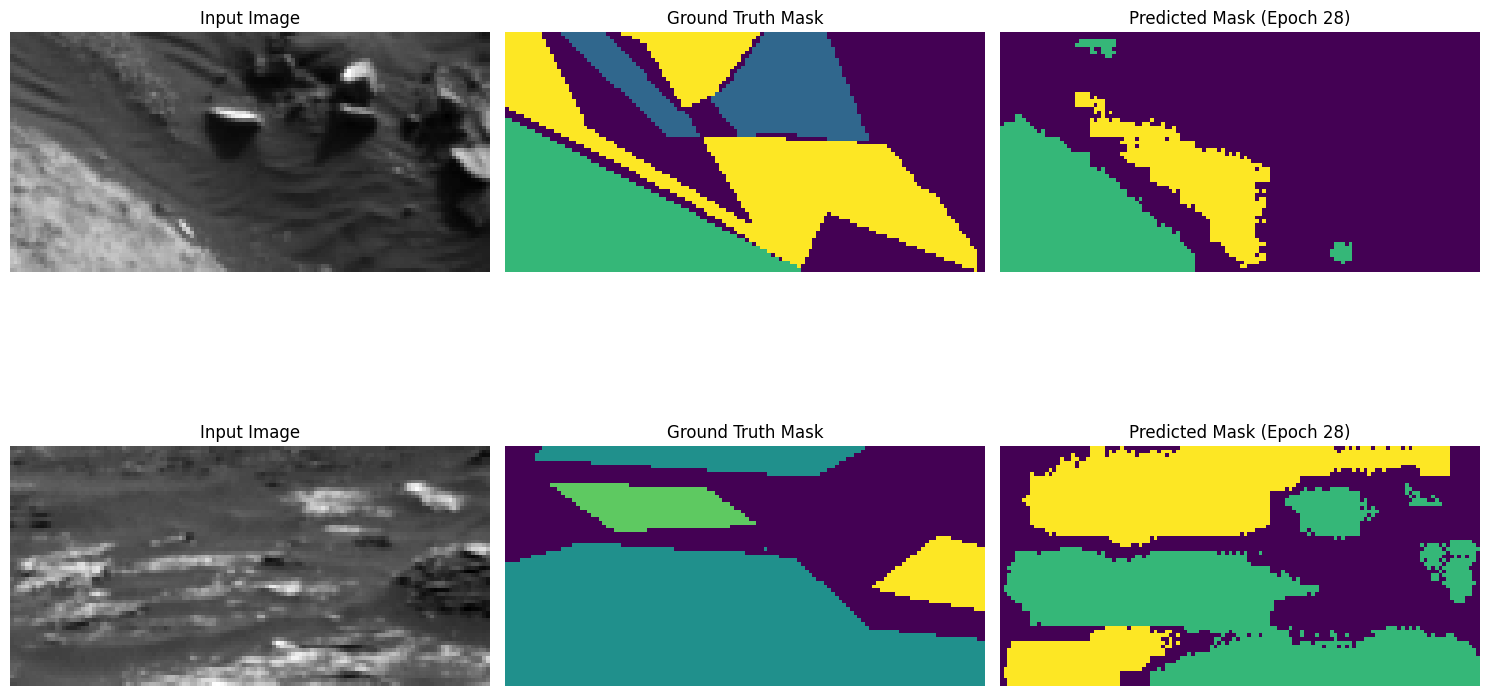

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.6819 - loss: 0.8132 - mean_io_u_2: 0.3776 - val_accuracy: 0.7073 - val_loss: 0.7781 - val_mean_io_u_2: 0.4096 - learning_rate: 1.0000e-04
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6886 - loss: 0.8010 - mean_io_u_2: 0.3850
Epoch 29: val_loss improved from 0.77808 to 0.77286, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


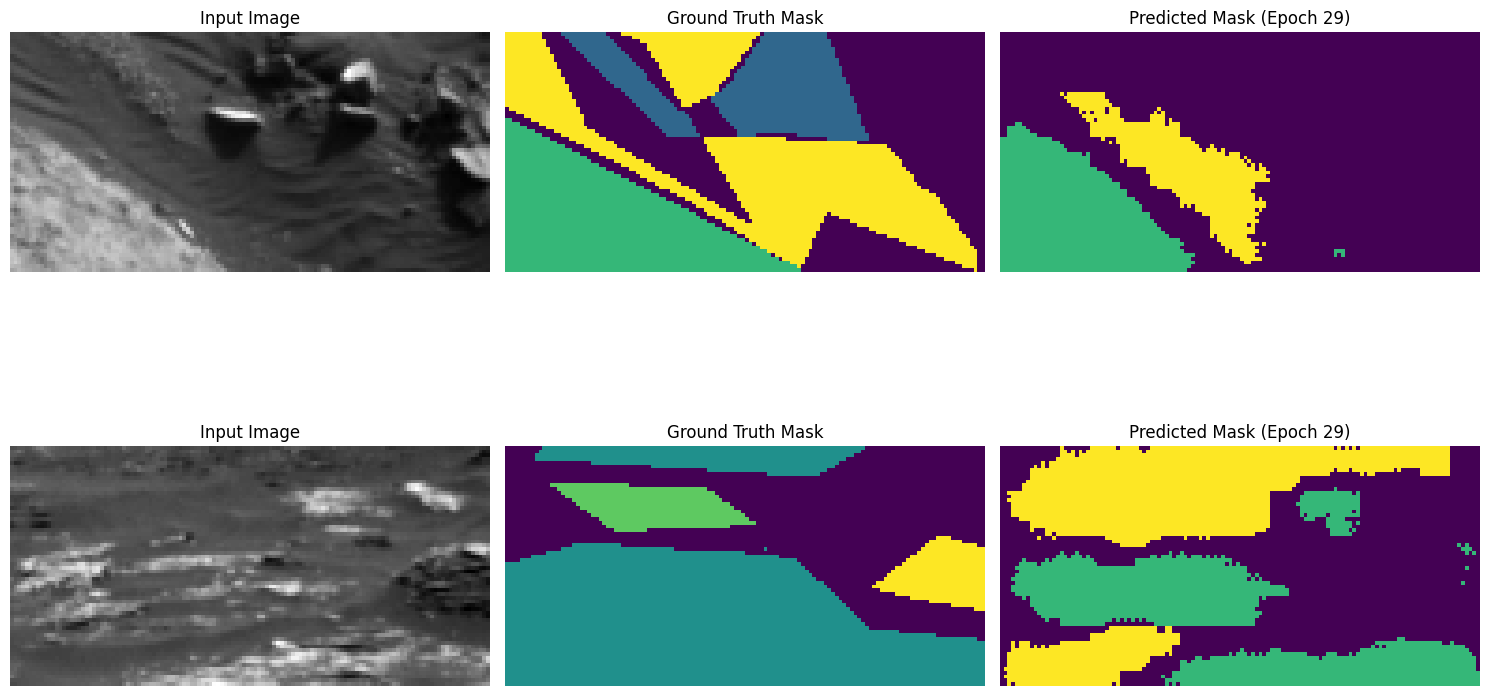

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6887 - loss: 0.8006 - mean_io_u_2: 0.3851 - val_accuracy: 0.7087 - val_loss: 0.7729 - val_mean_io_u_2: 0.4065 - learning_rate: 1.0000e-04
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6947 - loss: 0.7833 - mean_io_u_2: 0.3910
Epoch 30: val_loss improved from 0.77286 to 0.76249, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


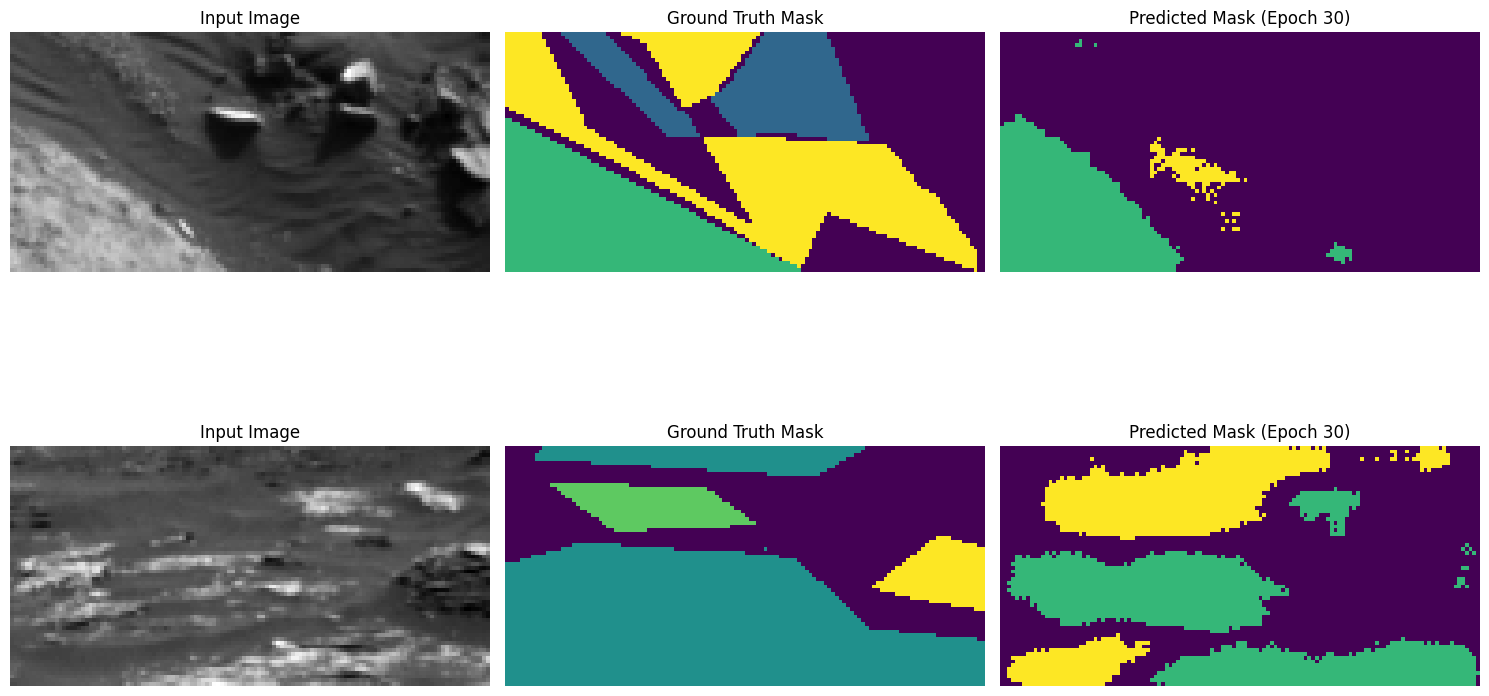

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.6948 - loss: 0.7831 - mean_io_u_2: 0.3910 - val_accuracy: 0.7106 - val_loss: 0.7625 - val_mean_io_u_2: 0.4029 - learning_rate: 1.0000e-04
Epoch 31/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6942 - loss: 0.7852 - mean_io_u_2: 0.3889
Epoch 31: val_loss did not improve from 0.76249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


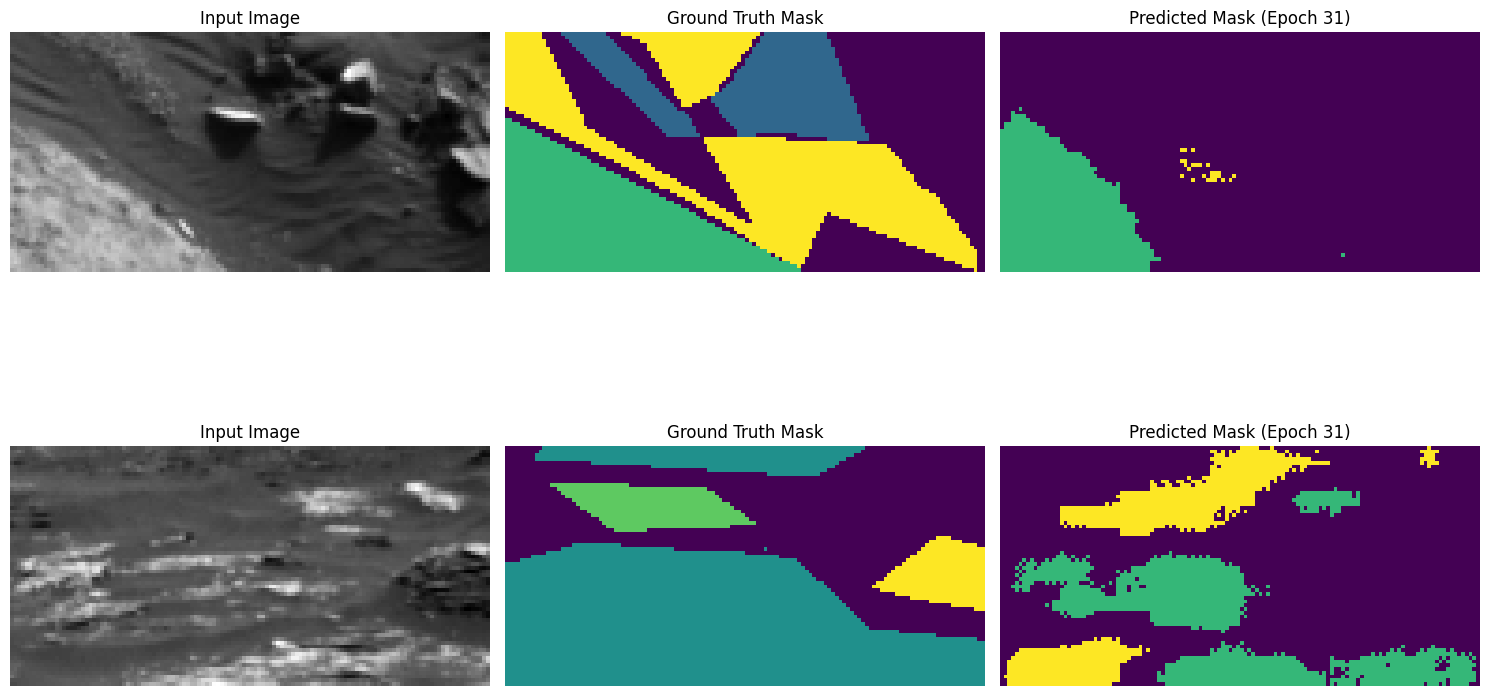

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.6944 - loss: 0.7847 - mean_io_u_2: 0.3891 - val_accuracy: 0.7035 - val_loss: 0.7756 - val_mean_io_u_2: 0.3888 - learning_rate: 1.0000e-04
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7050 - loss: 0.7608 - mean_io_u_2: 0.4029
Epoch 32: val_loss improved from 0.76249 to 0.75212, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


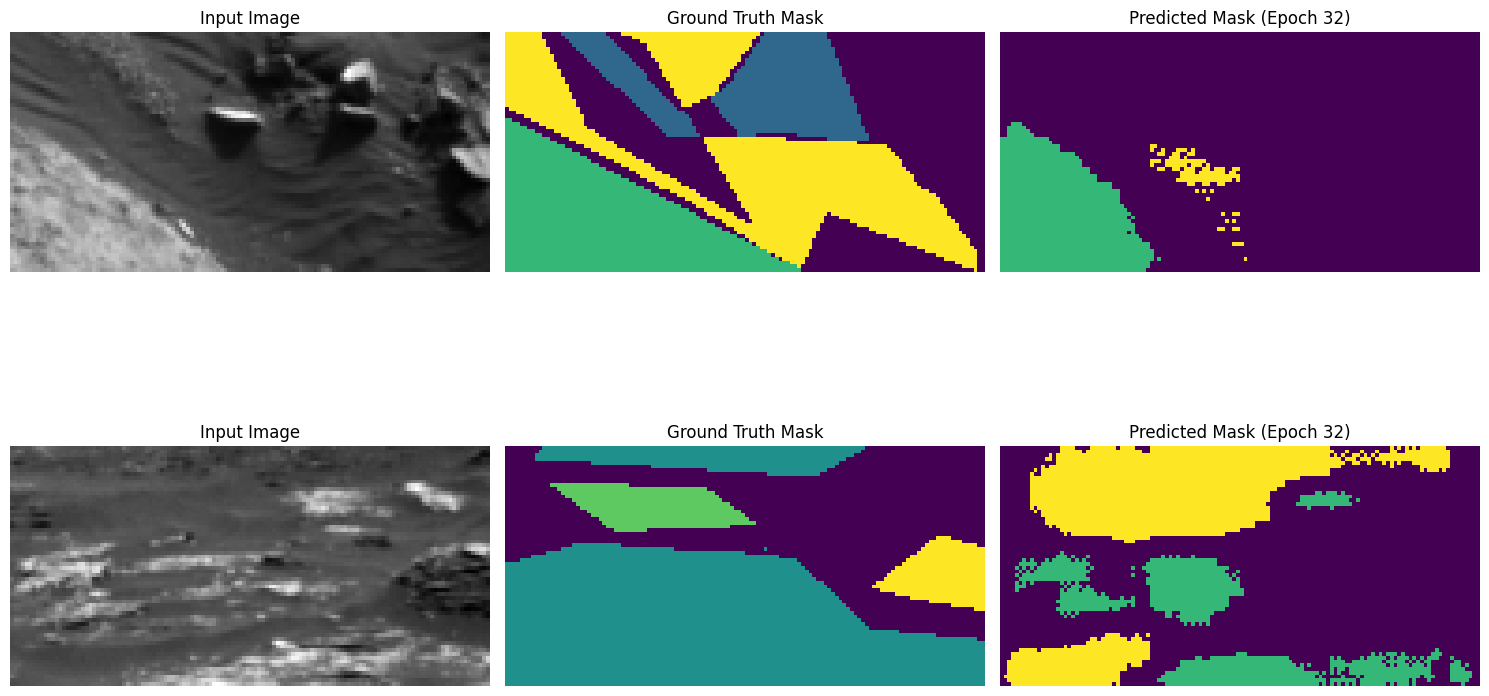

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.7052 - loss: 0.7605 - mean_io_u_2: 0.4030 - val_accuracy: 0.7133 - val_loss: 0.7521 - val_mean_io_u_2: 0.4039 - learning_rate: 1.0000e-04
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7028 - loss: 0.7608 - mean_io_u_2: 0.3967
Epoch 33: val_loss improved from 0.75212 to 0.75189, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


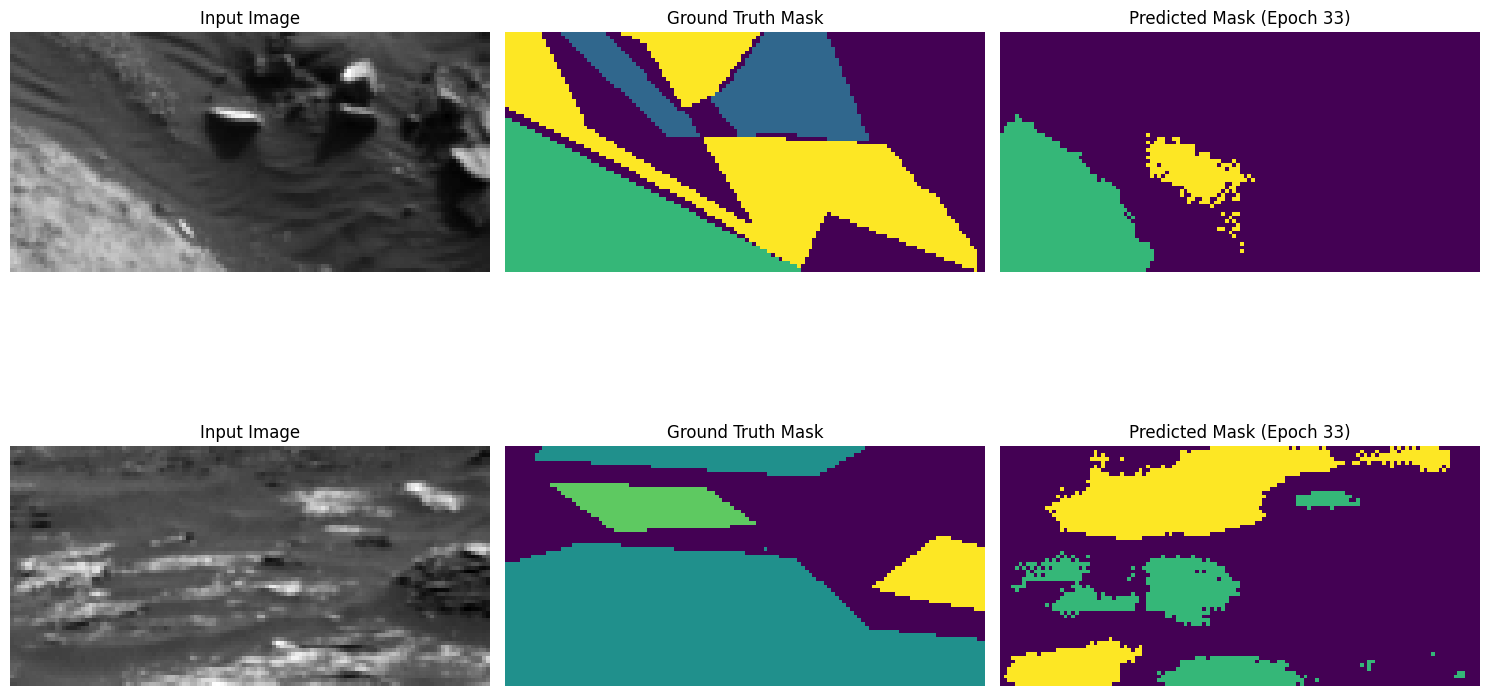

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.7030 - loss: 0.7604 - mean_io_u_2: 0.3969 - val_accuracy: 0.7123 - val_loss: 0.7519 - val_mean_io_u_2: 0.4003 - learning_rate: 1.0000e-04
Epoch 34/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7050 - loss: 0.7524 - mean_io_u_2: 0.3992
Epoch 34: val_loss improved from 0.75189 to 0.74191, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


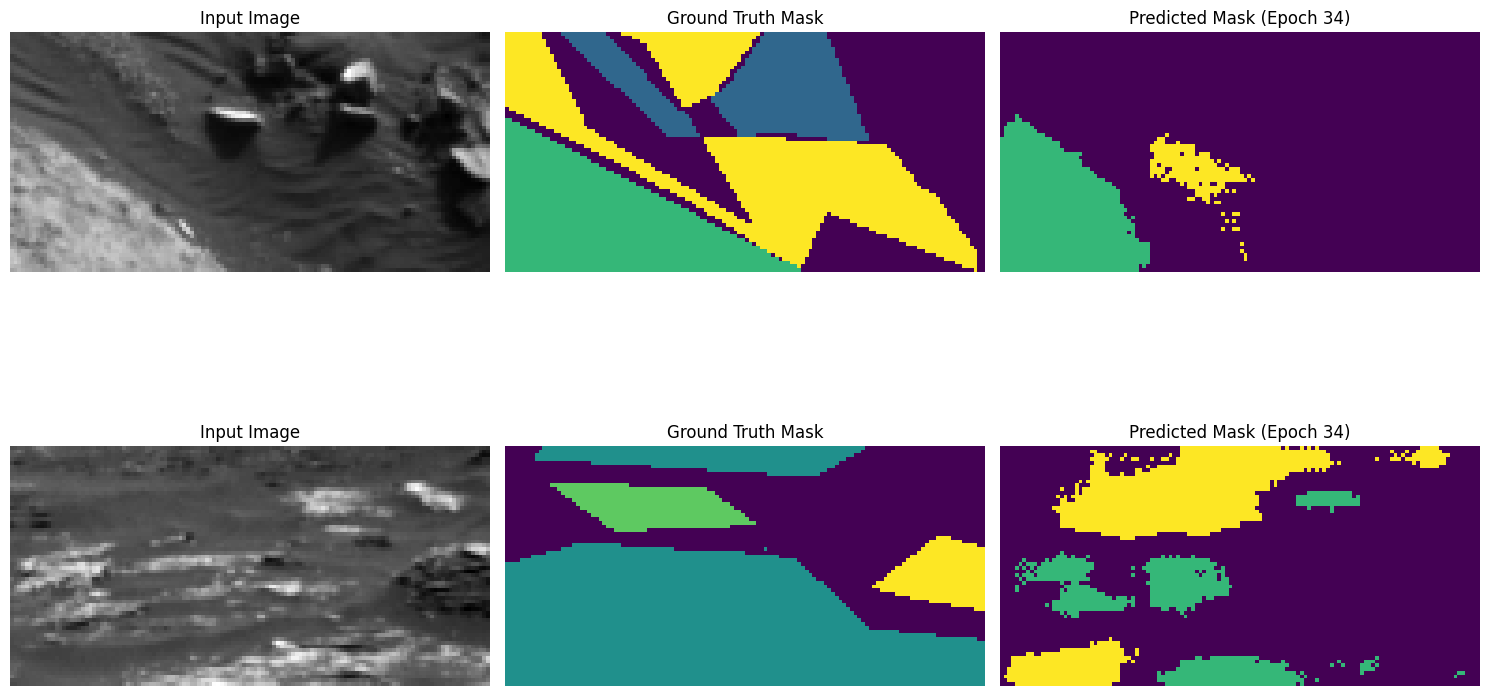

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.7052 - loss: 0.7519 - mean_io_u_2: 0.3994 - val_accuracy: 0.7178 - val_loss: 0.7419 - val_mean_io_u_2: 0.4053 - learning_rate: 1.0000e-04
Epoch 35/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7090 - loss: 0.7426 - mean_io_u_2: 0.4028
Epoch 35: val_loss improved from 0.74191 to 0.73702, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


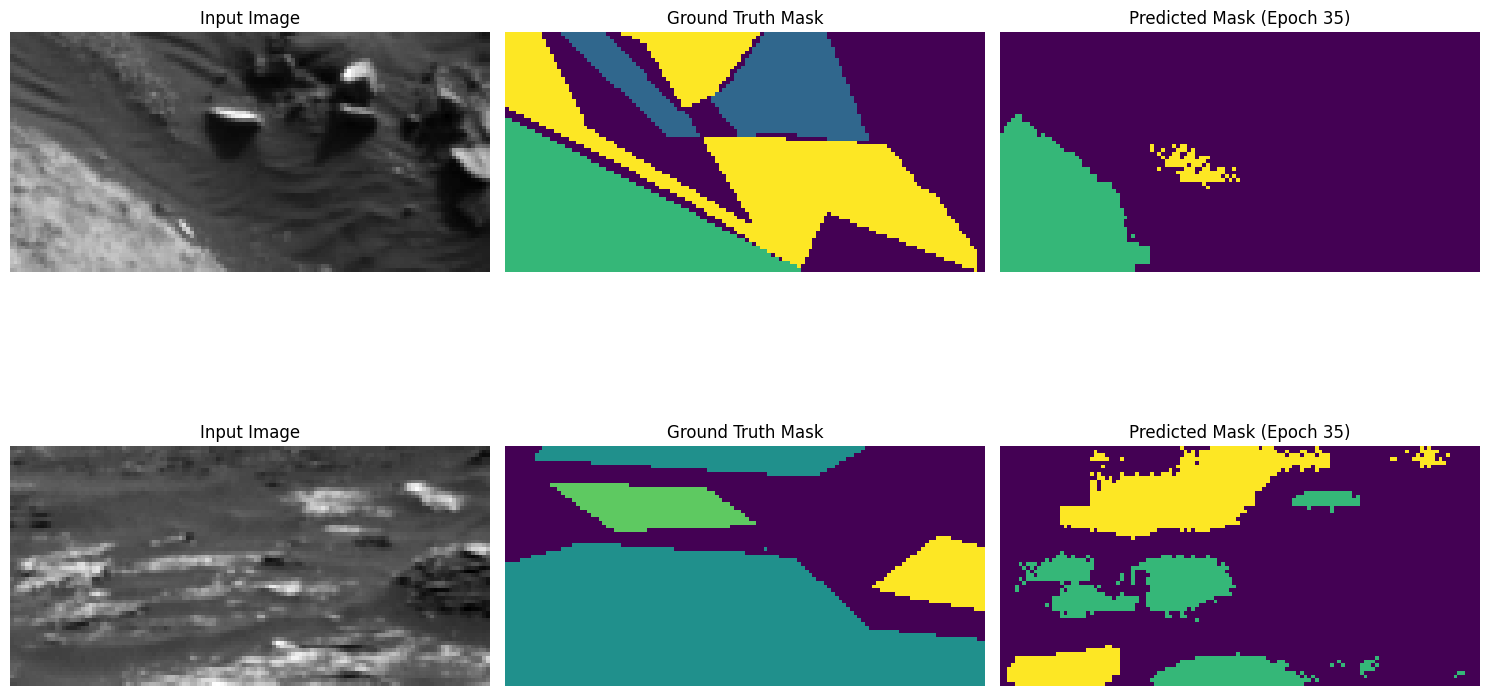

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.7093 - loss: 0.7421 - mean_io_u_2: 0.4030 - val_accuracy: 0.7189 - val_loss: 0.7370 - val_mean_io_u_2: 0.4044 - learning_rate: 1.0000e-04
Epoch 36/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7164 - loss: 0.7259 - mean_io_u_2: 0.4091
Epoch 36: val_loss did not improve from 0.73702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


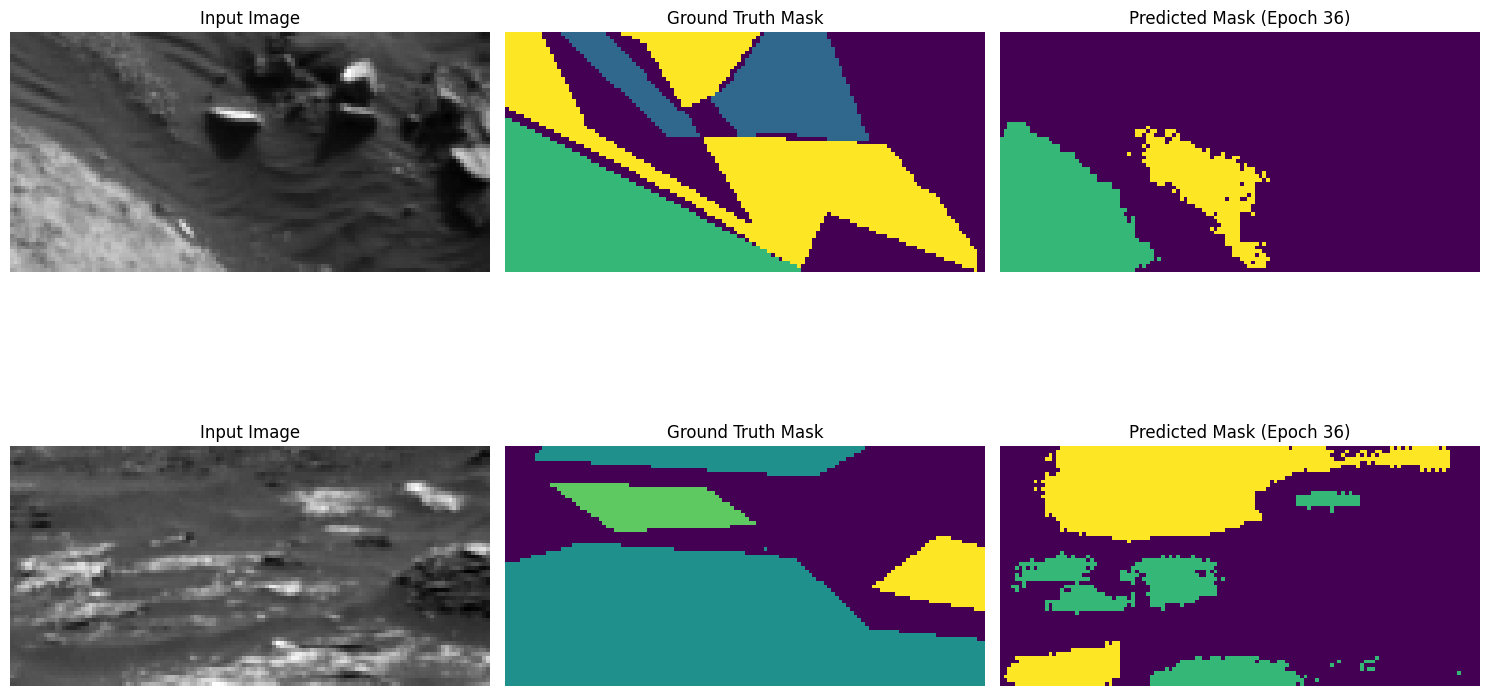

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.7166 - loss: 0.7255 - mean_io_u_2: 0.4093 - val_accuracy: 0.7185 - val_loss: 0.7409 - val_mean_io_u_2: 0.4102 - learning_rate: 1.0000e-04
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7177 - loss: 0.7248 - mean_io_u_2: 0.4102
Epoch 37: val_loss did not improve from 0.73702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


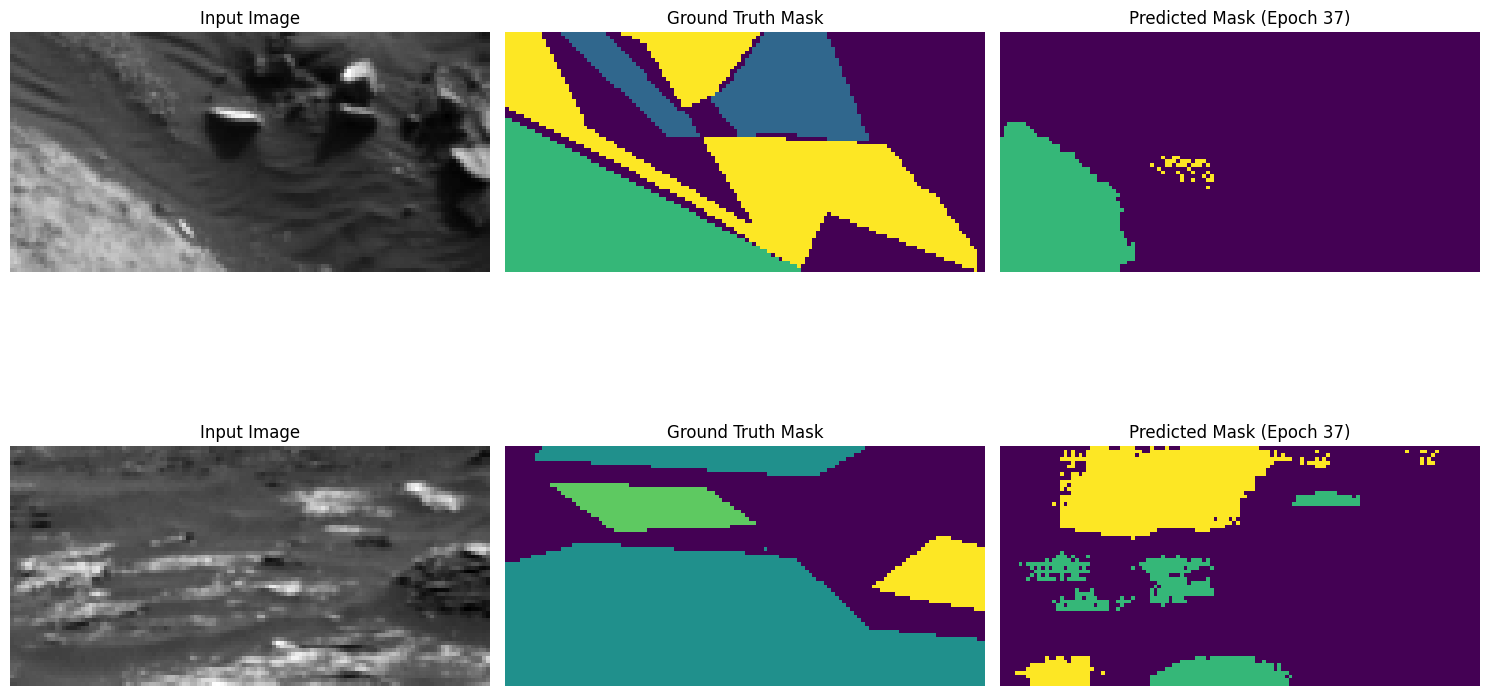

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7179 - loss: 0.7245 - mean_io_u_2: 0.4103 - val_accuracy: 0.7203 - val_loss: 0.7385 - val_mean_io_u_2: 0.4065 - learning_rate: 1.0000e-04
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7178 - loss: 0.7243 - mean_io_u_2: 0.4104
Epoch 38: val_loss did not improve from 0.73702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


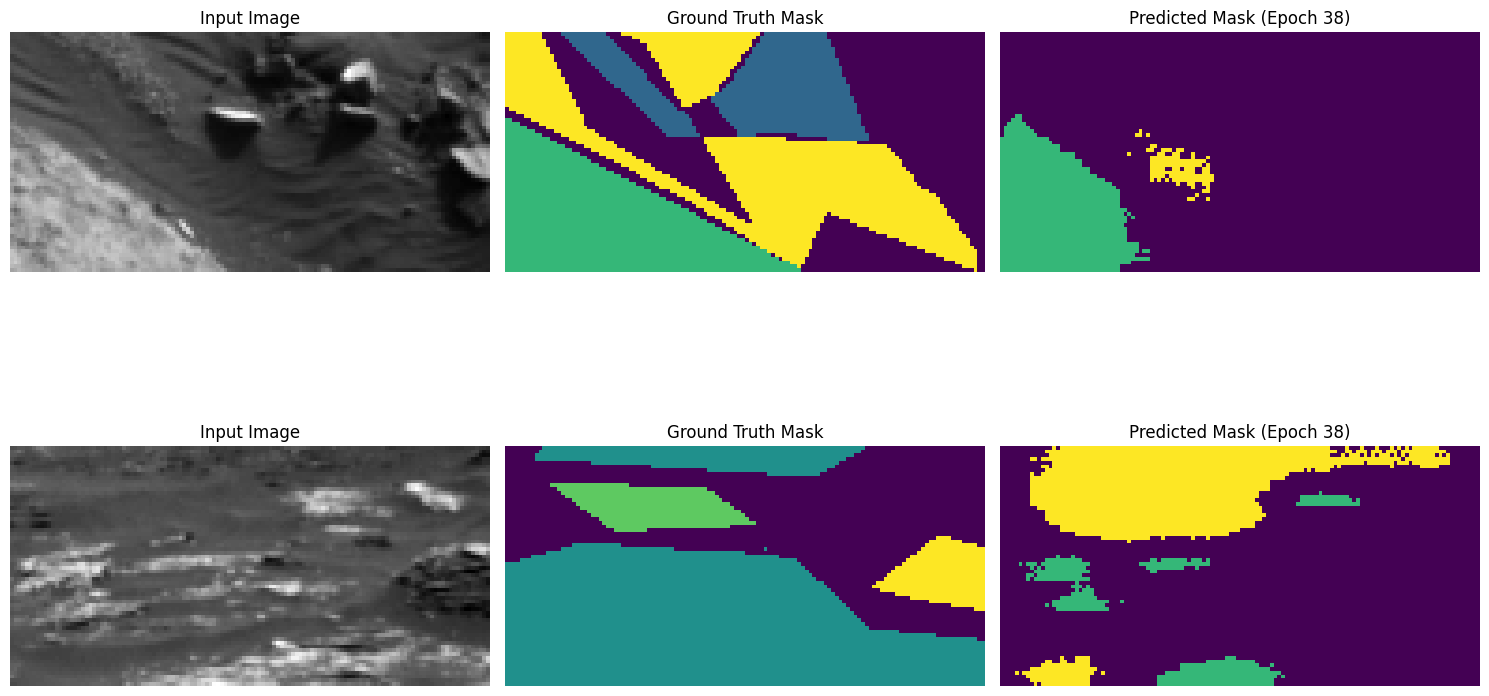

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7180 - loss: 0.7239 - mean_io_u_2: 0.4106 - val_accuracy: 0.7186 - val_loss: 0.7431 - val_mean_io_u_2: 0.4050 - learning_rate: 1.0000e-04
Epoch 39/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7189 - loss: 0.7221 - mean_io_u_2: 0.4127
Epoch 39: val_loss improved from 0.73702 to 0.72182, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


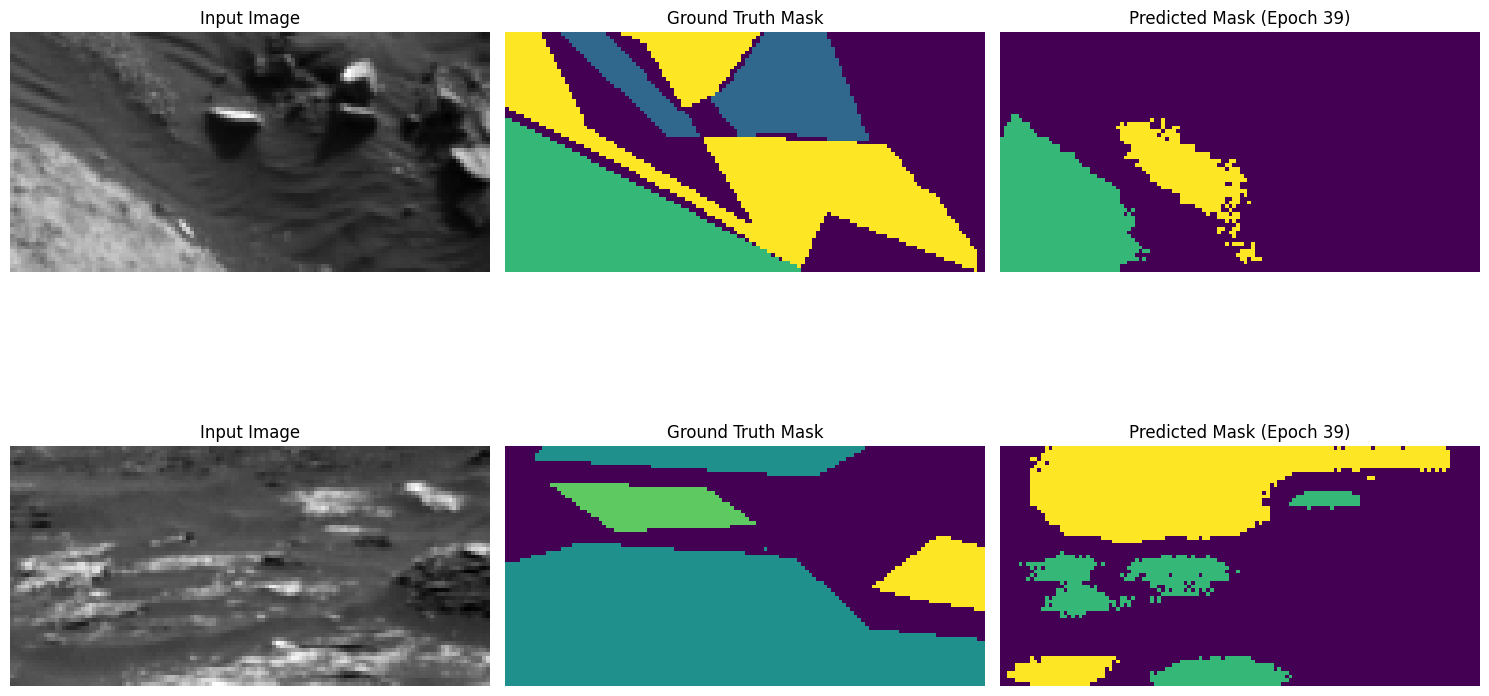

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.7192 - loss: 0.7216 - mean_io_u_2: 0.4129 - val_accuracy: 0.7247 - val_loss: 0.7218 - val_mean_io_u_2: 0.4111 - learning_rate: 1.0000e-04
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7226 - loss: 0.7149 - mean_io_u_2: 0.4144
Epoch 40: val_loss did not improve from 0.72182
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


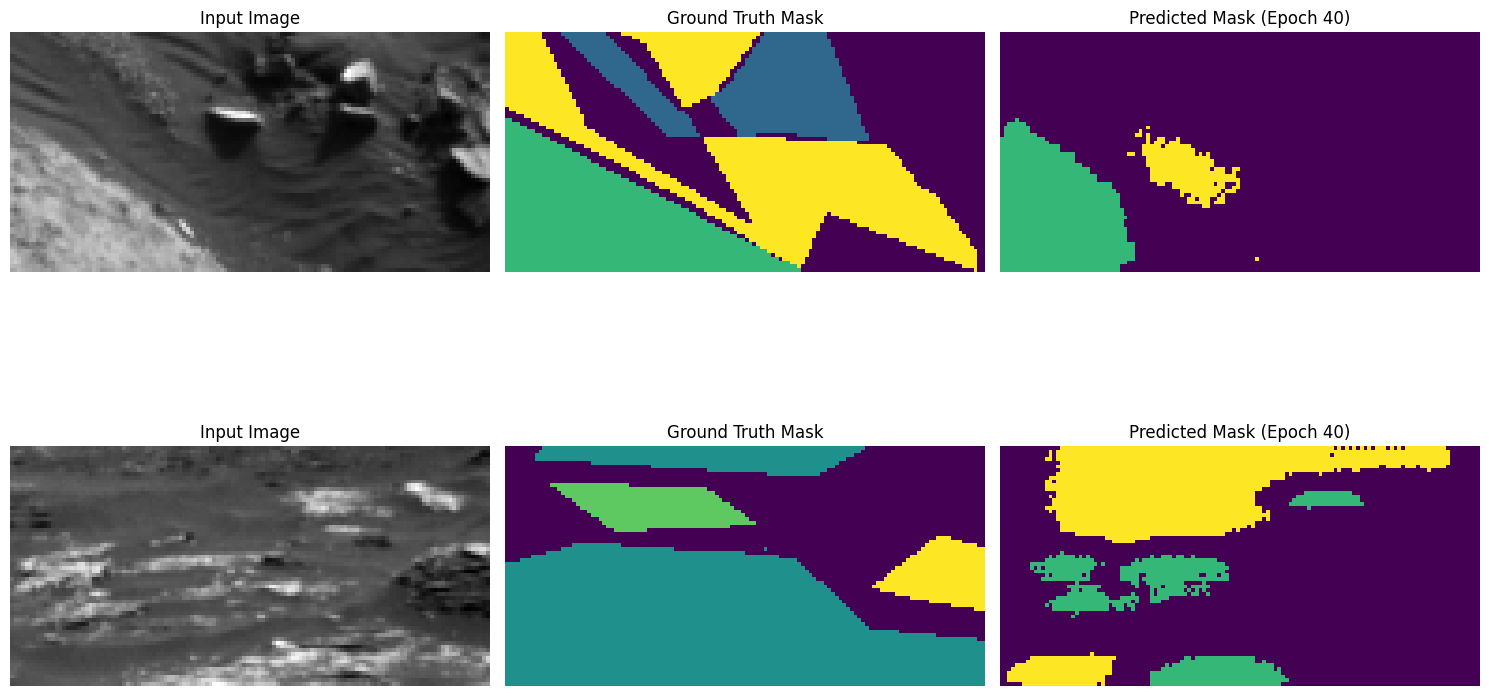

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.7229 - loss: 0.7144 - mean_io_u_2: 0.4146 - val_accuracy: 0.7203 - val_loss: 0.7342 - val_mean_io_u_2: 0.4040 - learning_rate: 1.0000e-04
Epoch 41/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7233 - loss: 0.7143 - mean_io_u_2: 0.4148
Epoch 41: val_loss improved from 0.72182 to 0.72137, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


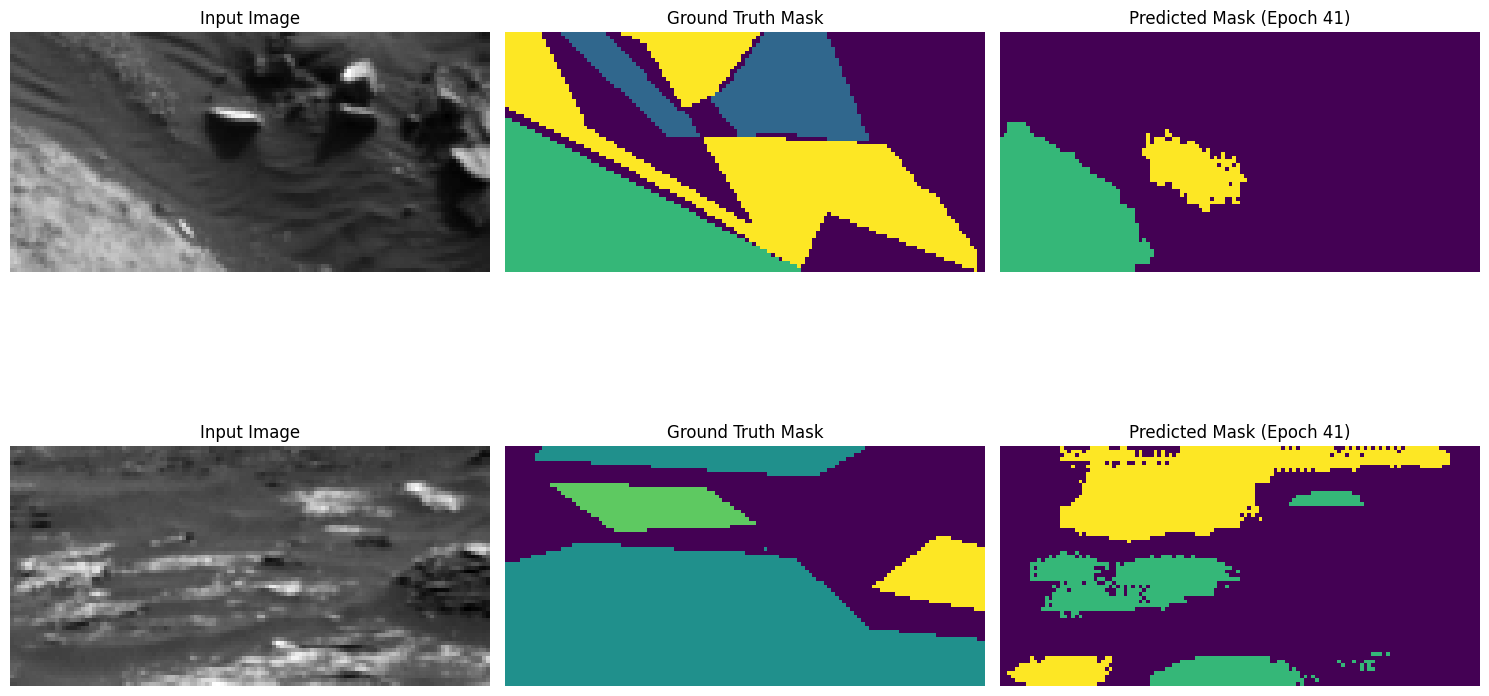

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.7235 - loss: 0.7137 - mean_io_u_2: 0.4150 - val_accuracy: 0.7274 - val_loss: 0.7214 - val_mean_io_u_2: 0.4116 - learning_rate: 1.0000e-04
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7346 - loss: 0.6846 - mean_io_u_2: 0.4244
Epoch 42: val_loss did not improve from 0.72137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


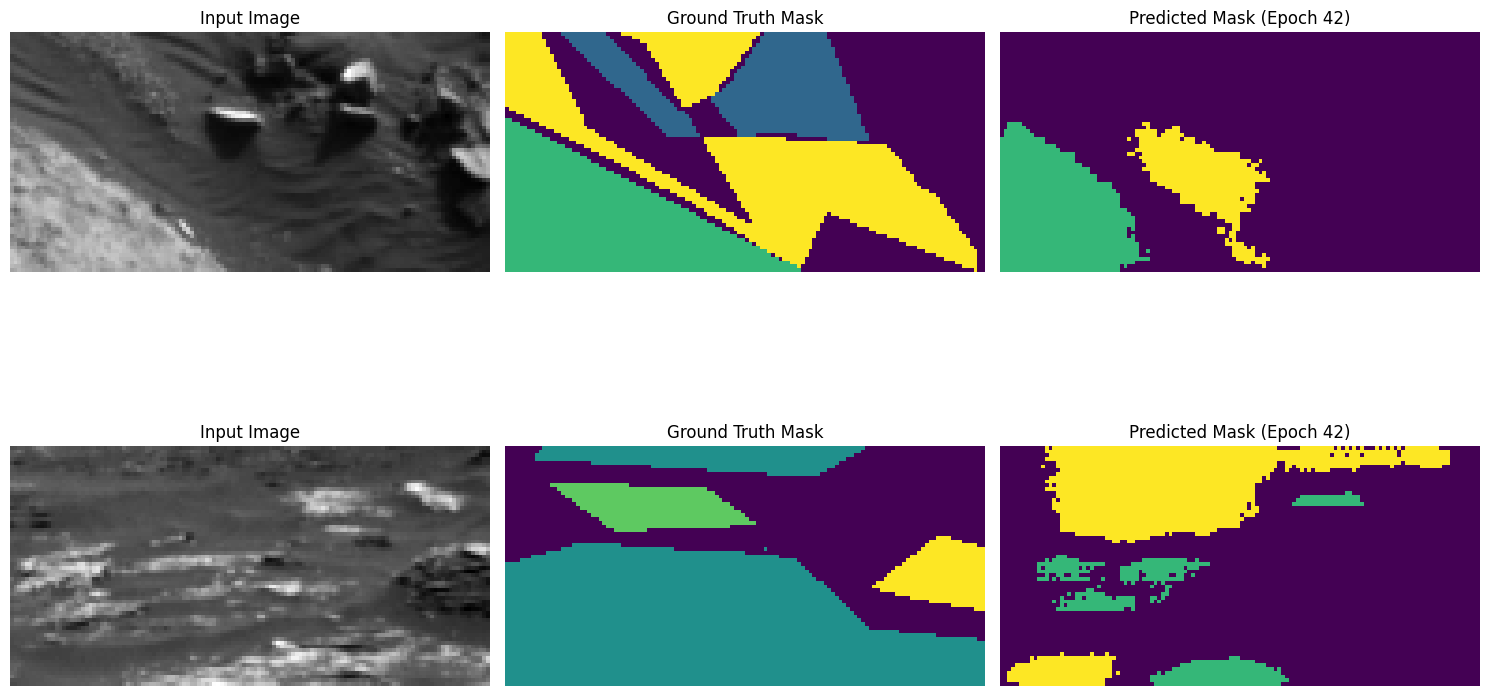

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7348 - loss: 0.6841 - mean_io_u_2: 0.4246 - val_accuracy: 0.7277 - val_loss: 0.7230 - val_mean_io_u_2: 0.4140 - learning_rate: 1.0000e-04
Epoch 43/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7389 - loss: 0.6756 - mean_io_u_2: 0.4320
Epoch 43: val_loss improved from 0.72137 to 0.72110, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


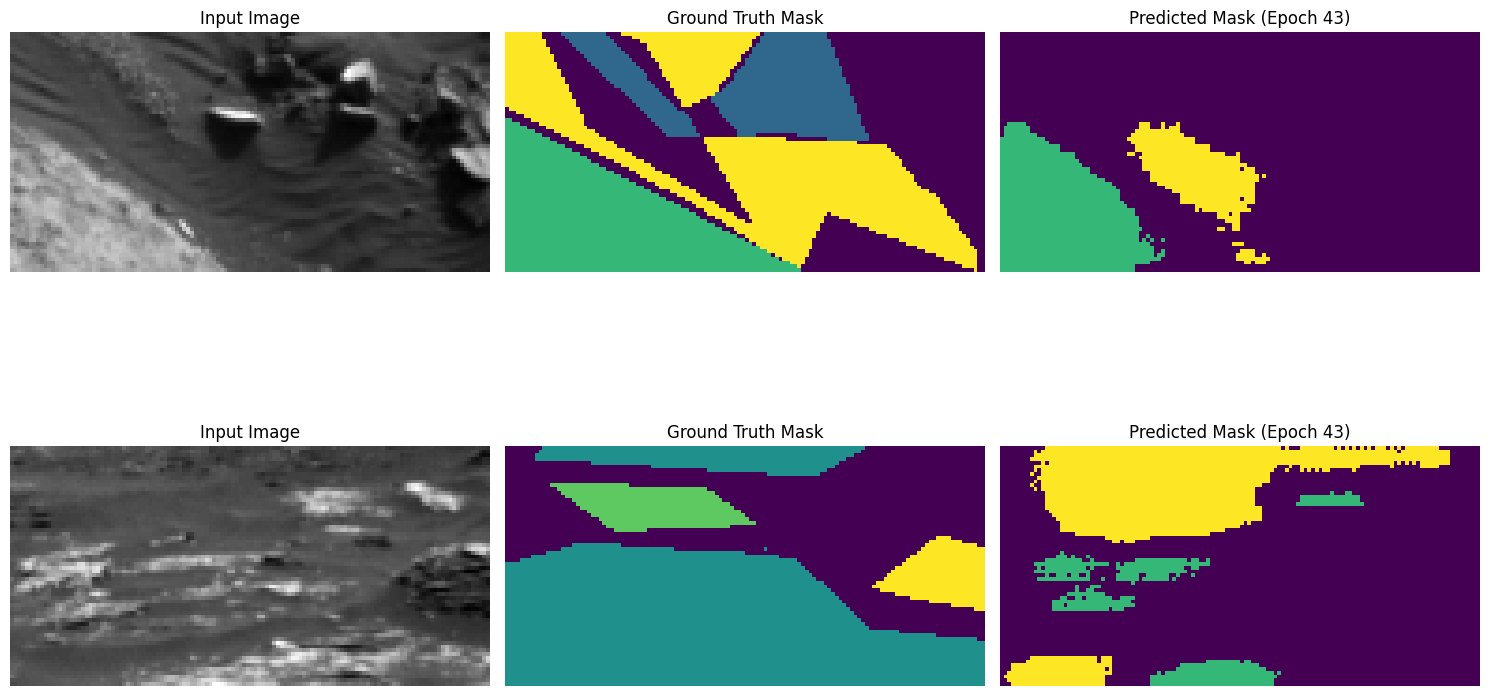

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.7391 - loss: 0.6752 - mean_io_u_2: 0.4321 - val_accuracy: 0.7284 - val_loss: 0.7211 - val_mean_io_u_2: 0.4156 - learning_rate: 1.0000e-04
Epoch 44/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7407 - loss: 0.6713 - mean_io_u_2: 0.4315
Epoch 44: val_loss did not improve from 0.72110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


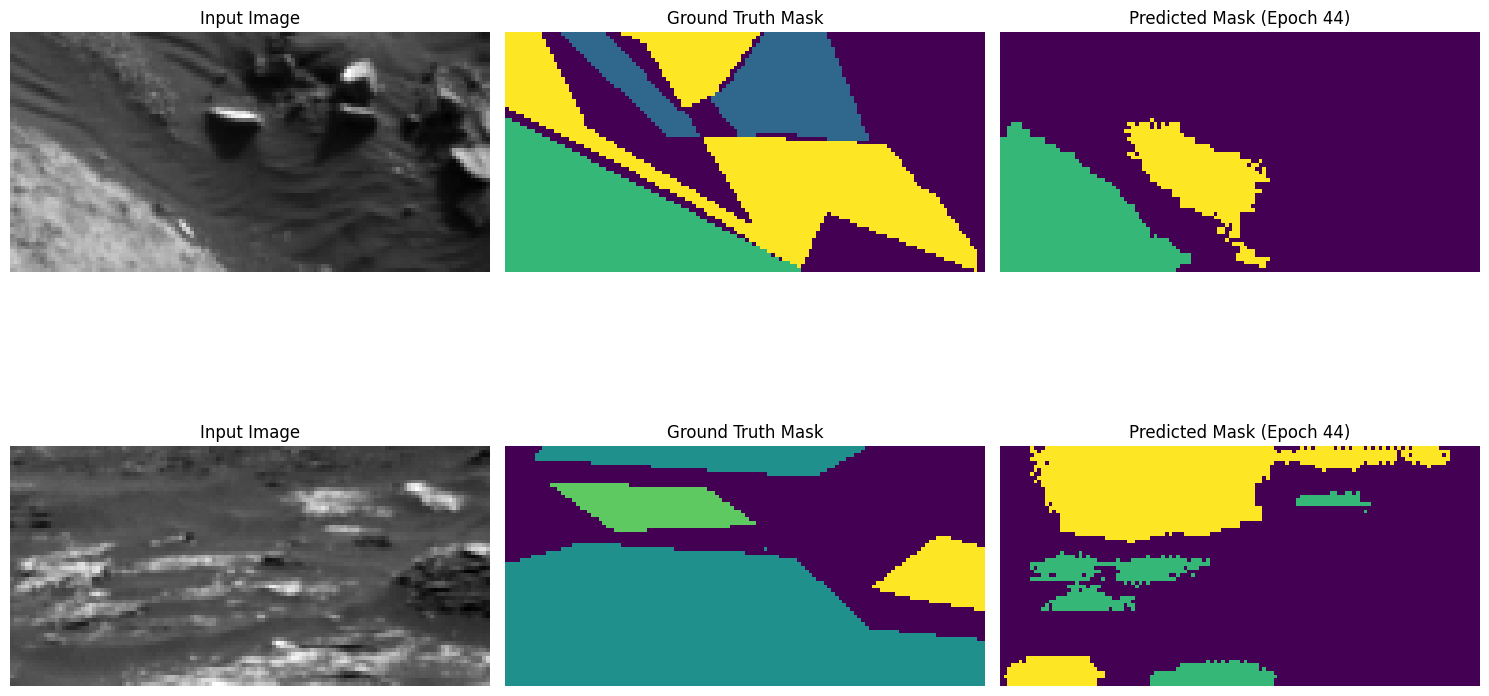

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7409 - loss: 0.6709 - mean_io_u_2: 0.4317 - val_accuracy: 0.7286 - val_loss: 0.7225 - val_mean_io_u_2: 0.4167 - learning_rate: 1.0000e-04
Epoch 45/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7466 - loss: 0.6617 - mean_io_u_2: 0.4374
Epoch 45: val_loss did not improve from 0.72110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


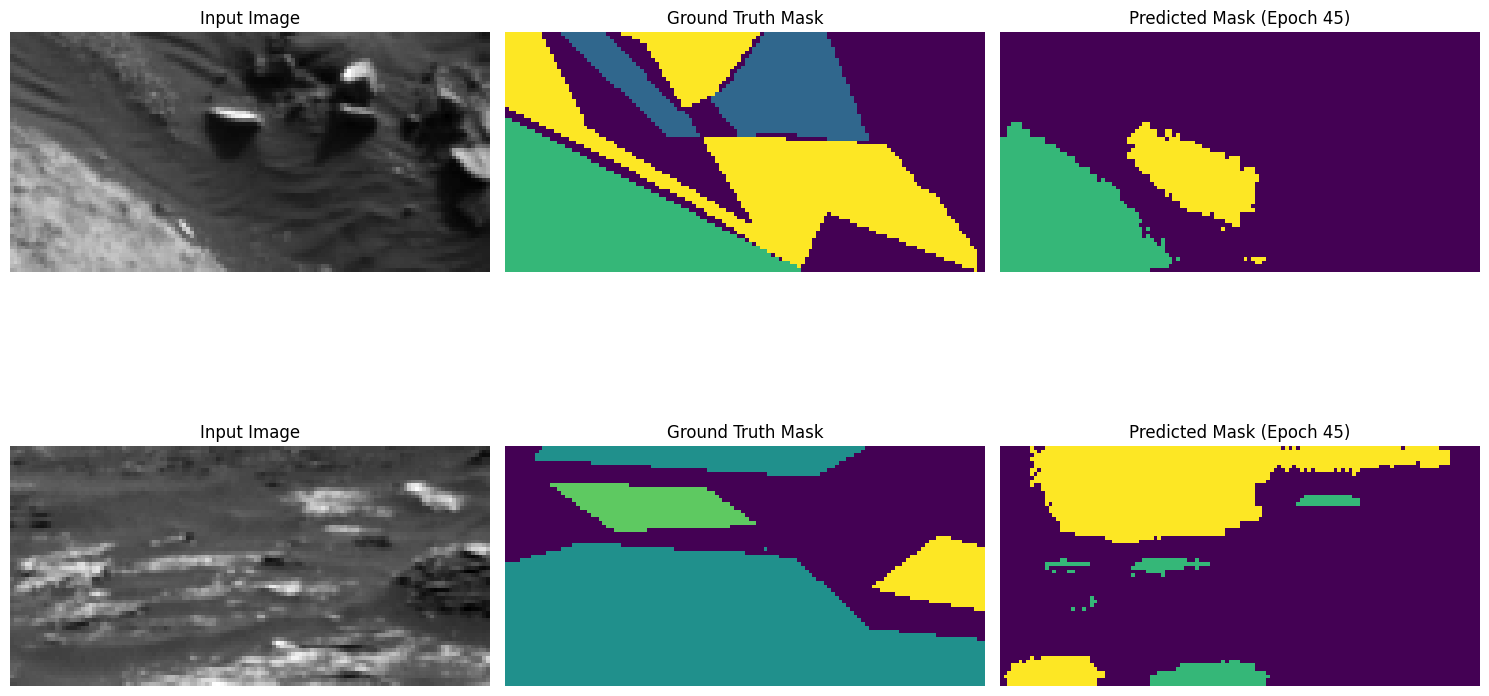

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.7468 - loss: 0.6613 - mean_io_u_2: 0.4375 - val_accuracy: 0.7252 - val_loss: 0.7251 - val_mean_io_u_2: 0.4115 - learning_rate: 1.0000e-04
Epoch 46/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7465 - loss: 0.6626 - mean_io_u_2: 0.4372
Epoch 46: val_loss did not improve from 0.72110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


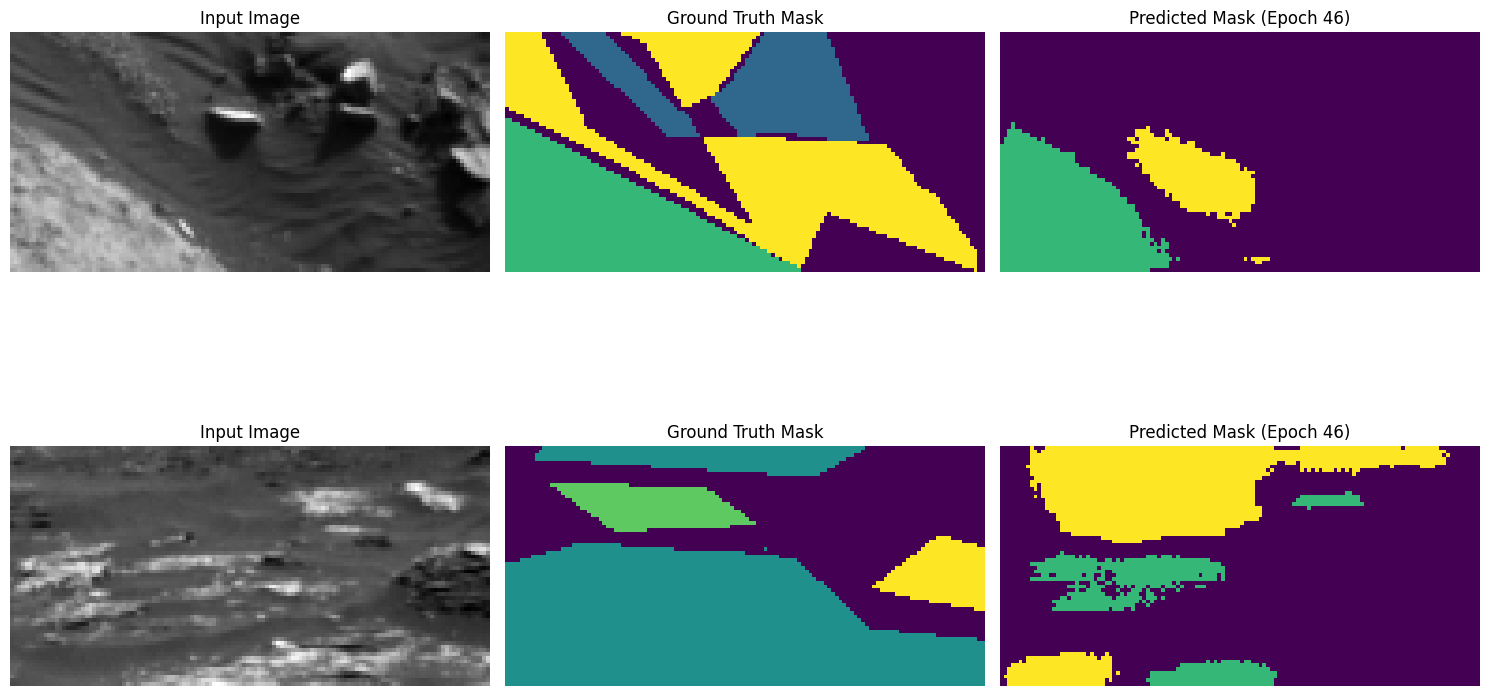

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.7467 - loss: 0.6621 - mean_io_u_2: 0.4374 - val_accuracy: 0.7270 - val_loss: 0.7234 - val_mean_io_u_2: 0.4118 - learning_rate: 1.0000e-04
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7469 - loss: 0.6603 - mean_io_u_2: 0.4379
Epoch 47: val_loss did not improve from 0.72110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


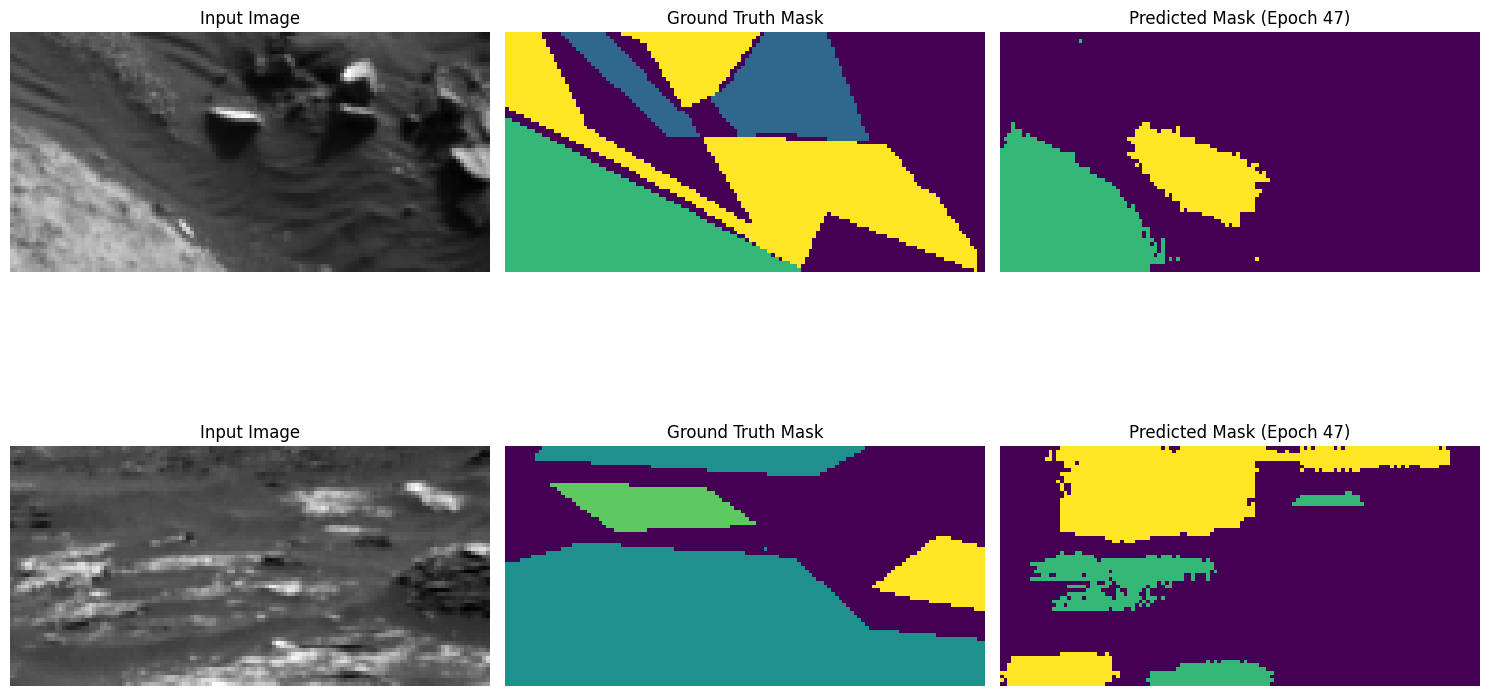

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7471 - loss: 0.6598 - mean_io_u_2: 0.4380 - val_accuracy: 0.7263 - val_loss: 0.7269 - val_mean_io_u_2: 0.4092 - learning_rate: 1.0000e-04
Epoch 48/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7471 - loss: 0.6589 - mean_io_u_2: 0.4379
Epoch 48: val_loss did not improve from 0.72110

Epoch 48: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


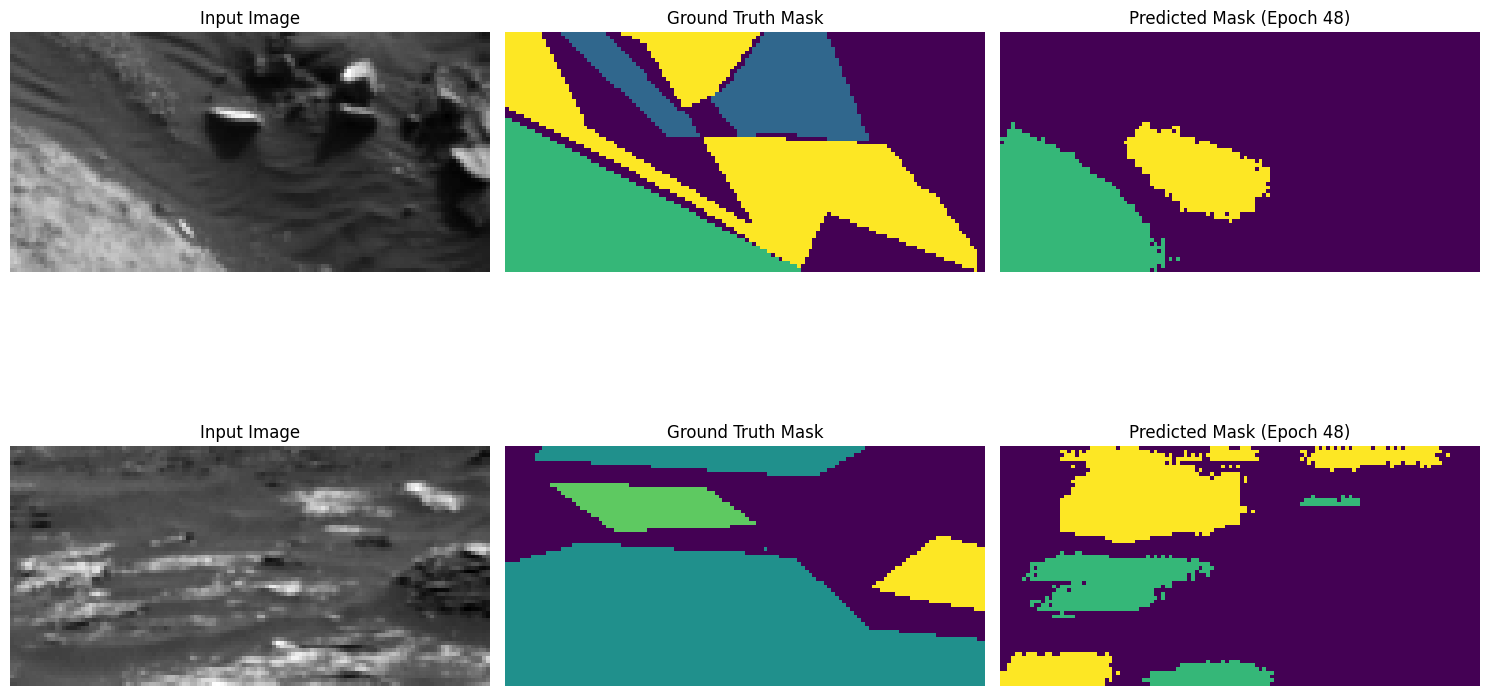

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.7473 - loss: 0.6584 - mean_io_u_2: 0.4380 - val_accuracy: 0.7277 - val_loss: 0.7309 - val_mean_io_u_2: 0.4082 - learning_rate: 1.0000e-04
Epoch 49/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7604 - loss: 0.6311 - mean_io_u_2: 0.4567
Epoch 49: val_loss improved from 0.72110 to 0.70859, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


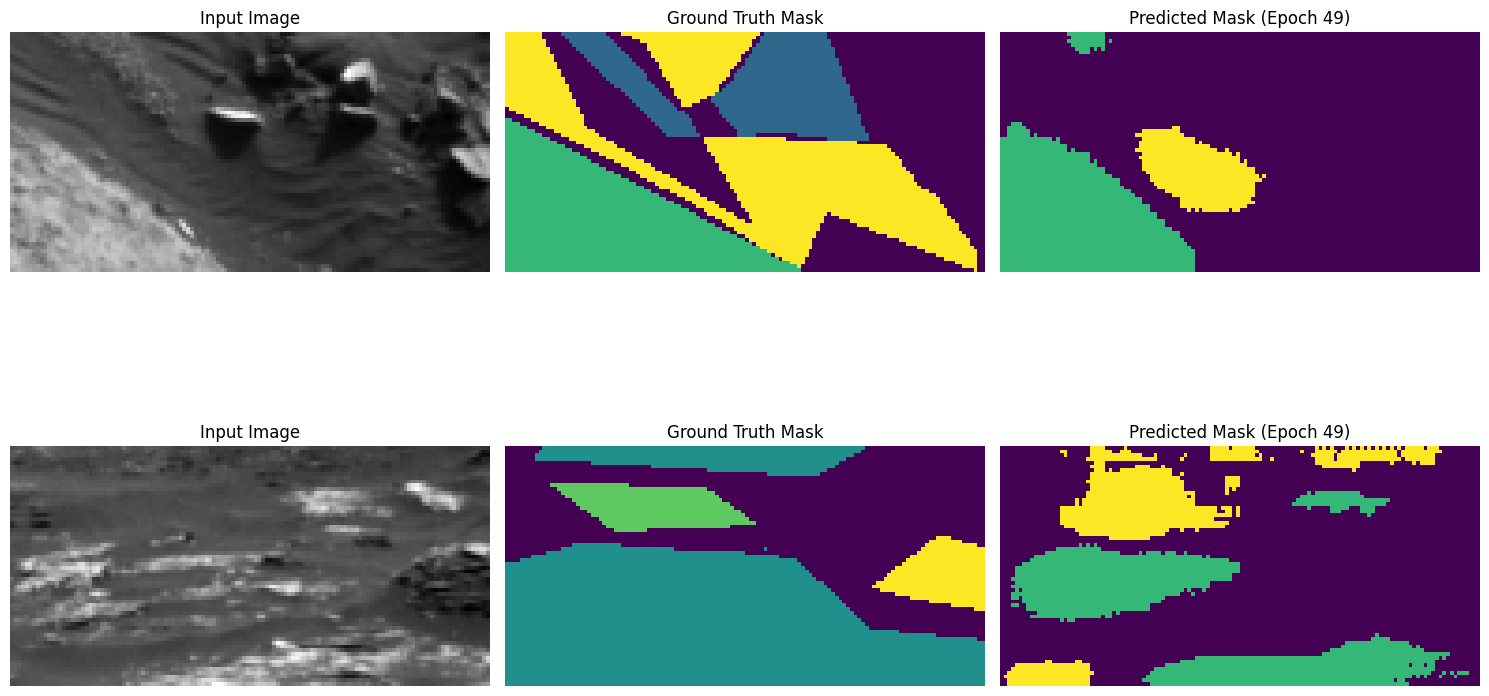

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.7606 - loss: 0.6305 - mean_io_u_2: 0.4569 - val_accuracy: 0.7394 - val_loss: 0.7086 - val_mean_io_u_2: 0.4179 - learning_rate: 5.0000e-05
Epoch 50/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7674 - loss: 0.6078 - mean_io_u_2: 0.4671
Epoch 50: val_loss did not improve from 0.70859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


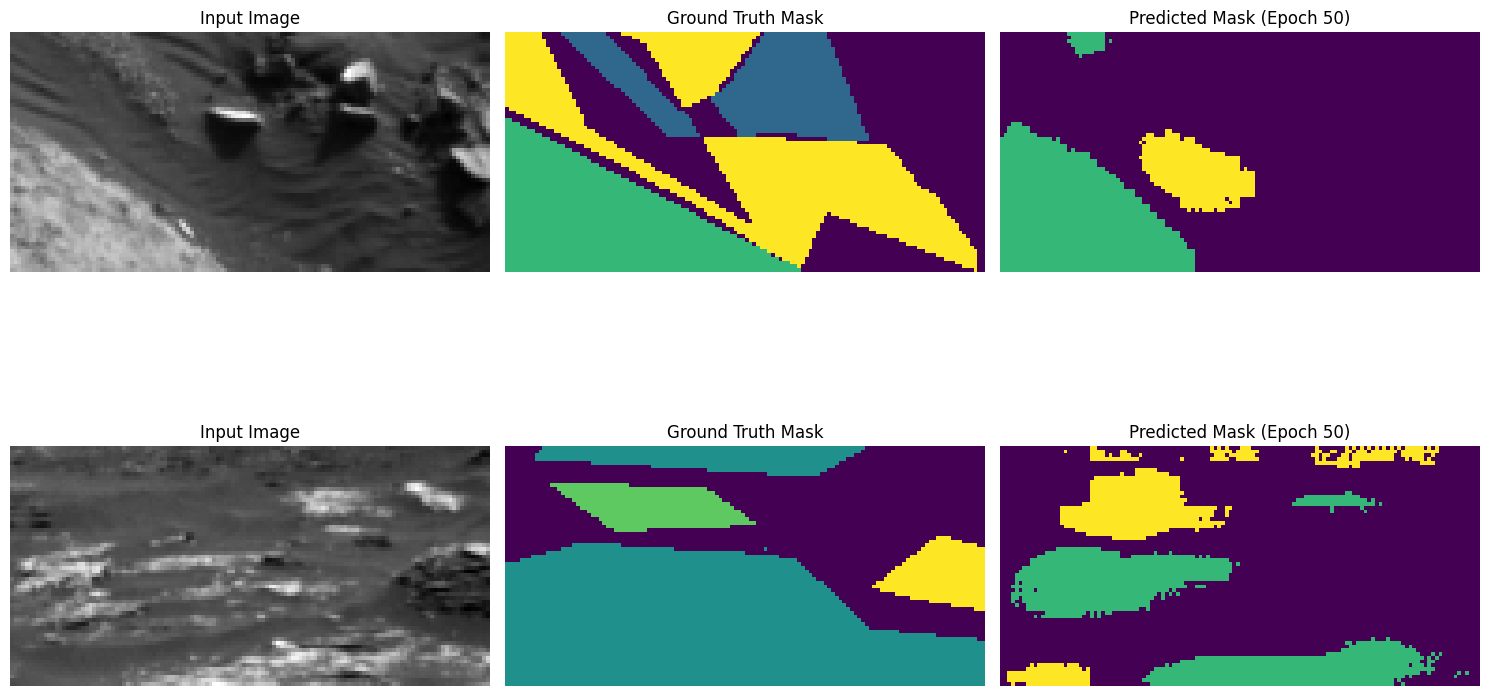

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7675 - loss: 0.6074 - mean_io_u_2: 0.4671 - val_accuracy: 0.7397 - val_loss: 0.7110 - val_mean_io_u_2: 0.4156 - learning_rate: 5.0000e-05
Epoch 51/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7716 - loss: 0.5975 - mean_io_u_2: 0.4703
Epoch 51: val_loss did not improve from 0.70859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


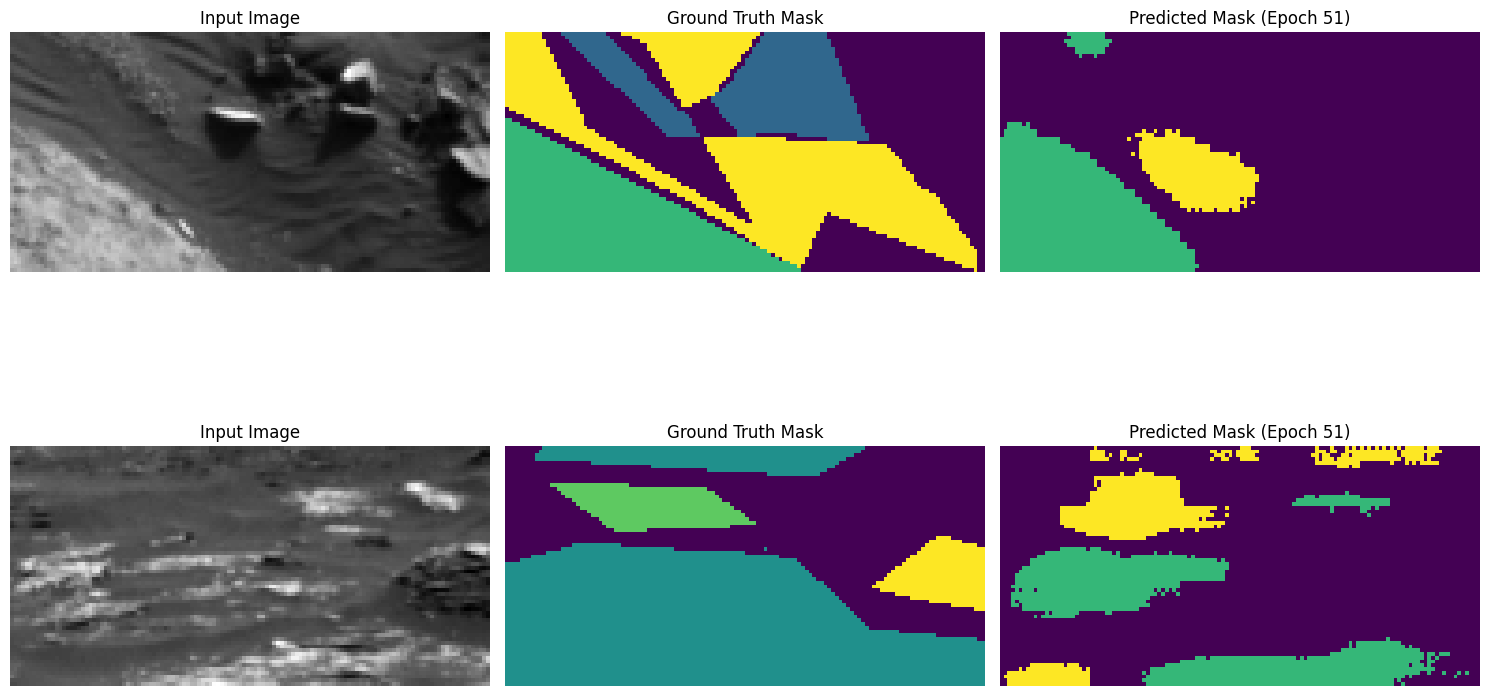

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7717 - loss: 0.5970 - mean_io_u_2: 0.4704 - val_accuracy: 0.7403 - val_loss: 0.7133 - val_mean_io_u_2: 0.4165 - learning_rate: 5.0000e-05
Epoch 52/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7750 - loss: 0.5894 - mean_io_u_2: 0.4727
Epoch 52: val_loss did not improve from 0.70859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


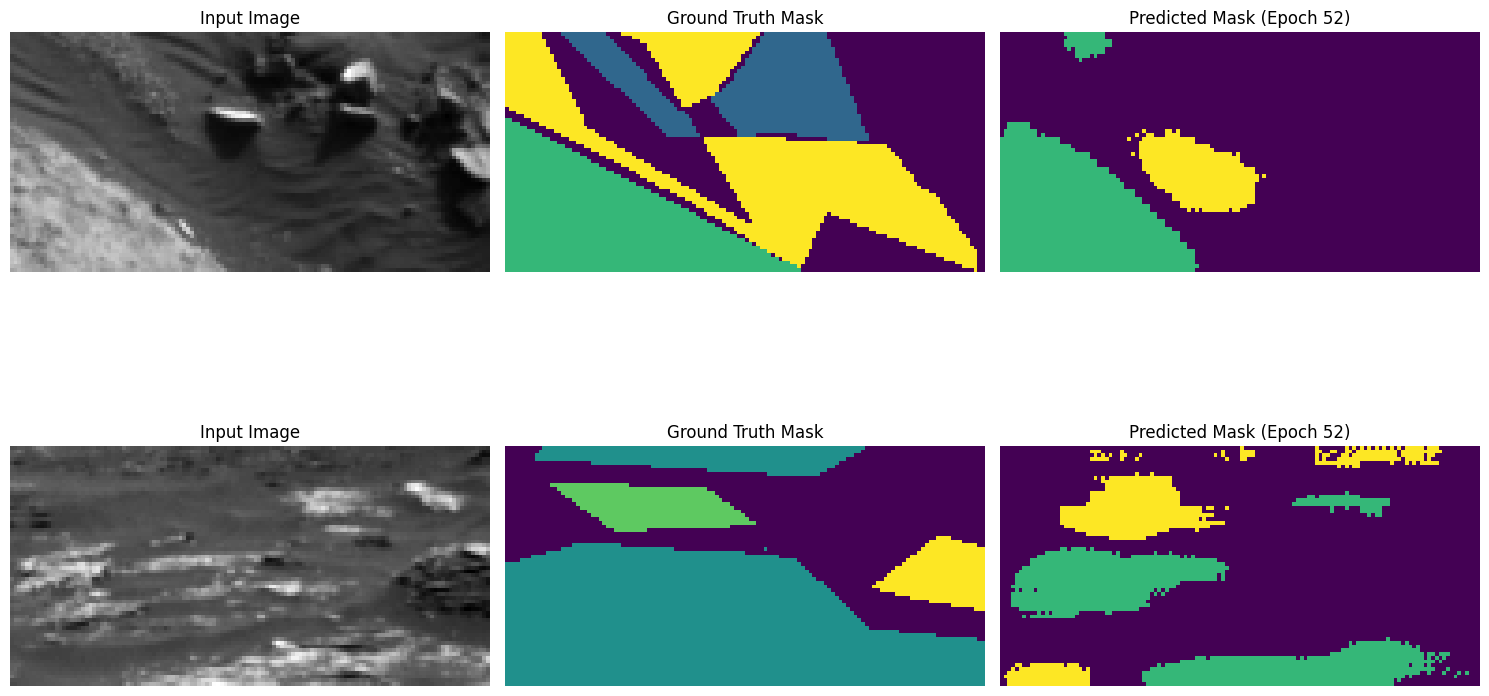

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7752 - loss: 0.5890 - mean_io_u_2: 0.4728 - val_accuracy: 0.7409 - val_loss: 0.7148 - val_mean_io_u_2: 0.4175 - learning_rate: 5.0000e-05
Epoch 53/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7785 - loss: 0.5811 - mean_io_u_2: 0.4761
Epoch 53: val_loss did not improve from 0.70859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


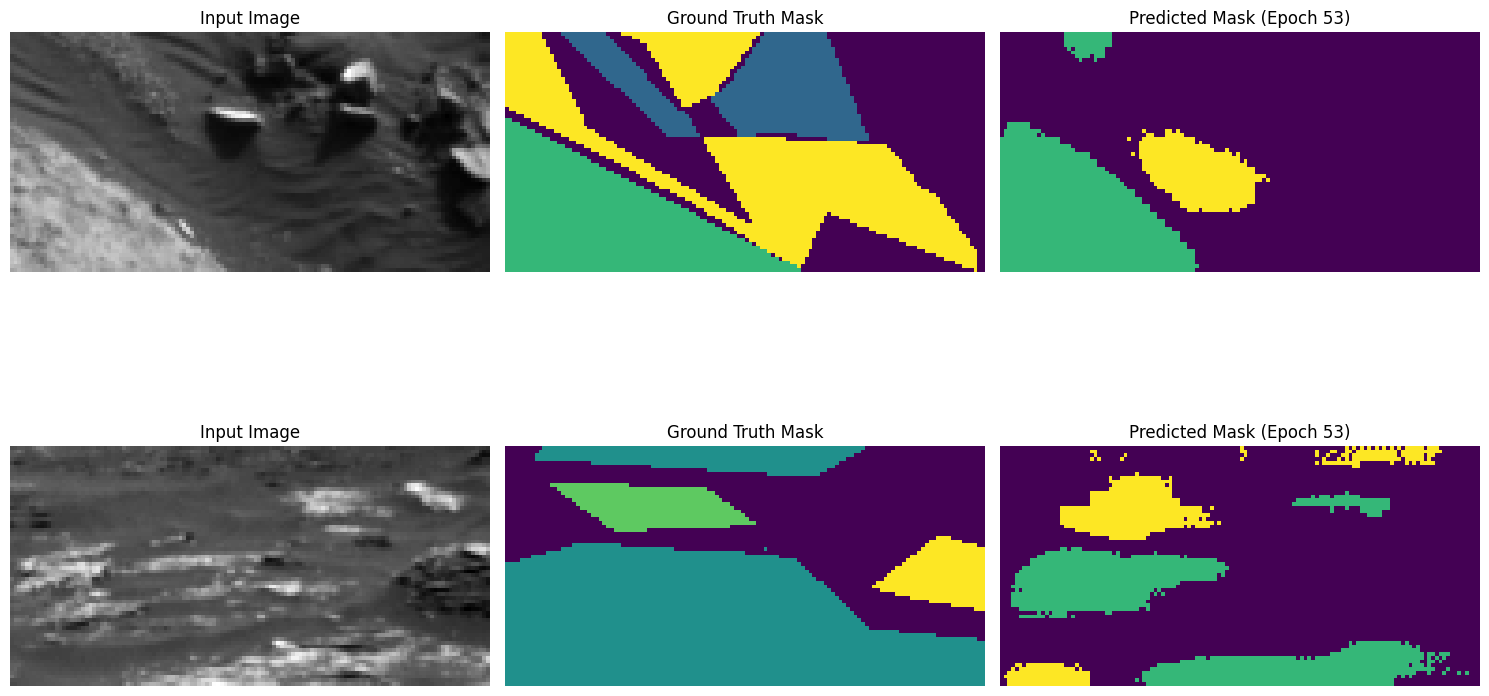

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7787 - loss: 0.5806 - mean_io_u_2: 0.4761 - val_accuracy: 0.7413 - val_loss: 0.7176 - val_mean_io_u_2: 0.4180 - learning_rate: 5.0000e-05
Epoch 54/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7819 - loss: 0.5729 - mean_io_u_2: 0.4788
Epoch 54: val_loss did not improve from 0.70859

Epoch 54: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


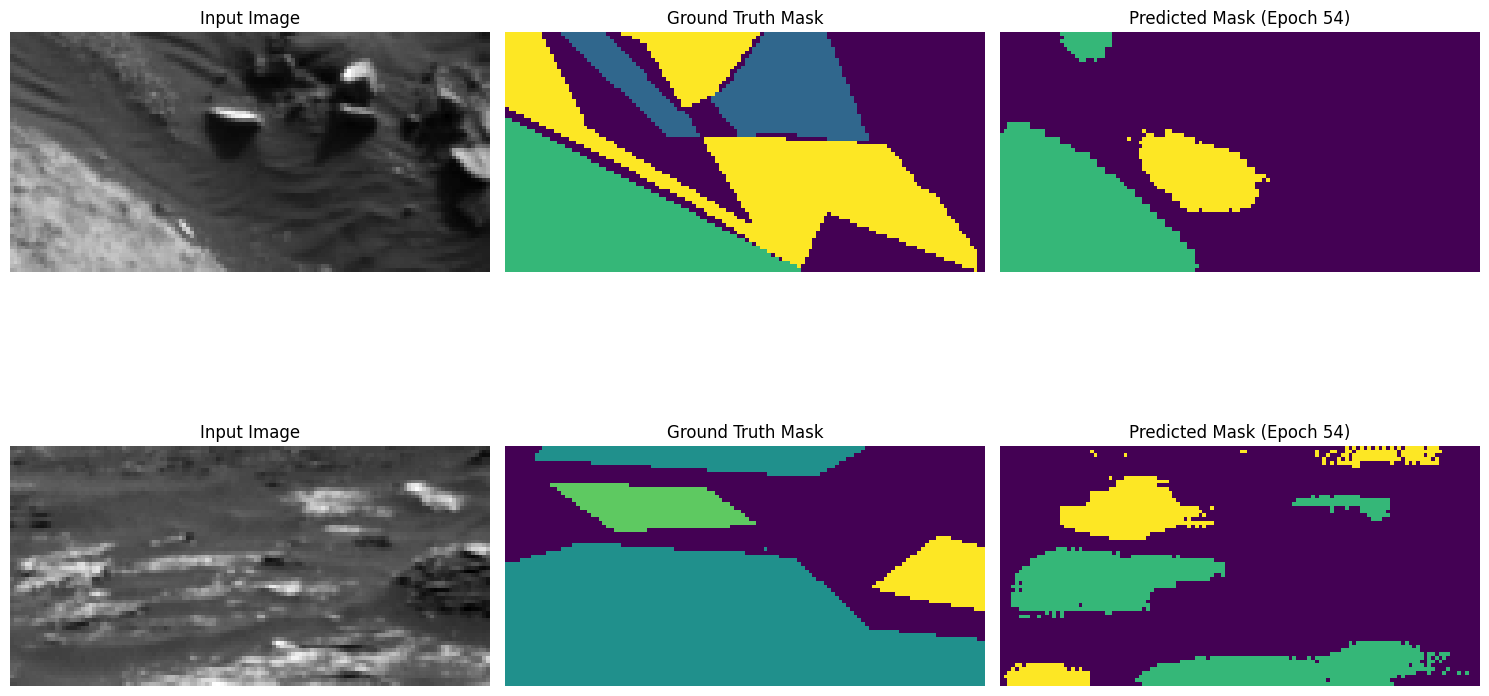

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.7821 - loss: 0.5724 - mean_io_u_2: 0.4789 - val_accuracy: 0.7419 - val_loss: 0.7200 - val_mean_io_u_2: 0.4187 - learning_rate: 5.0000e-05
Epoch 55/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7888 - loss: 0.5529 - mean_io_u_2: 0.4839
Epoch 55: val_loss improved from 0.70859 to 0.66733, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


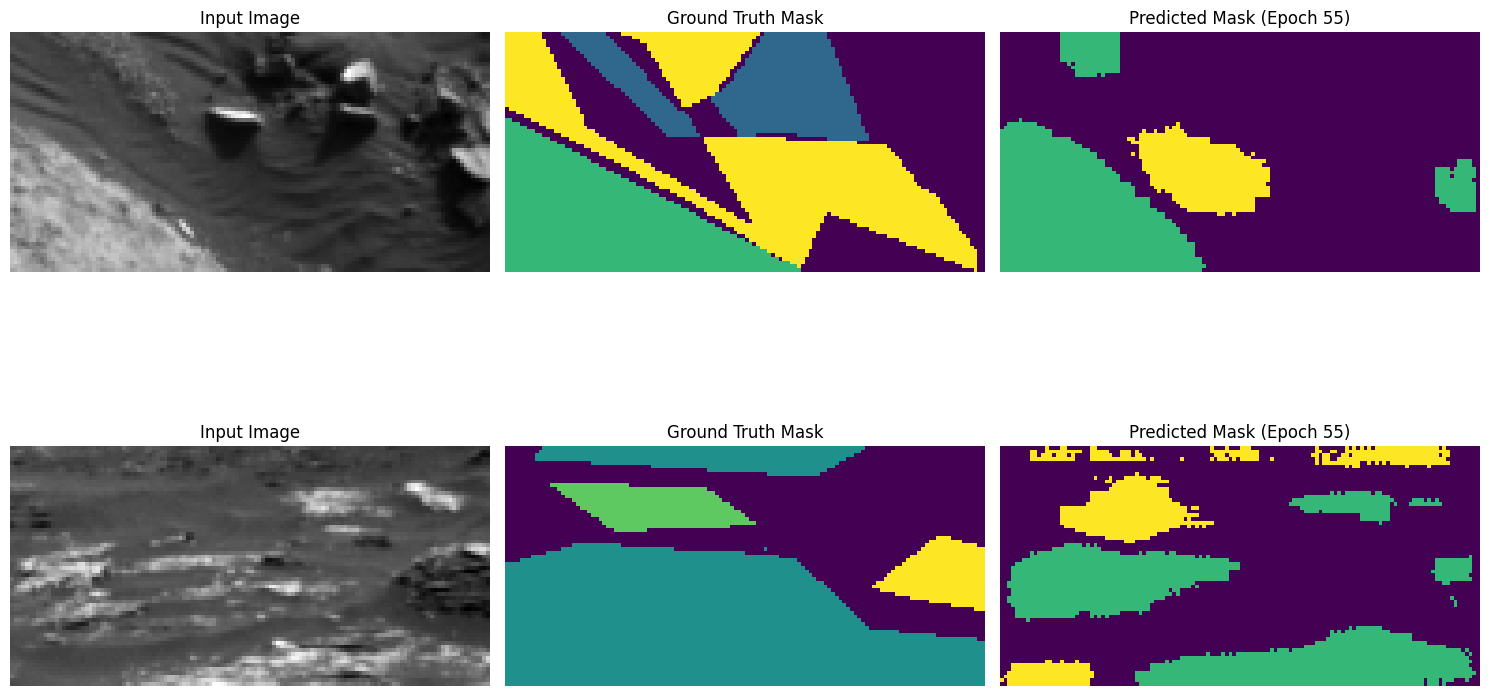

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.7889 - loss: 0.5524 - mean_io_u_2: 0.4840 - val_accuracy: 0.7563 - val_loss: 0.6673 - val_mean_io_u_2: 0.4437 - learning_rate: 2.5000e-05
Epoch 56/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7969 - loss: 0.5290 - mean_io_u_2: 0.4953
Epoch 56: val_loss did not improve from 0.66733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


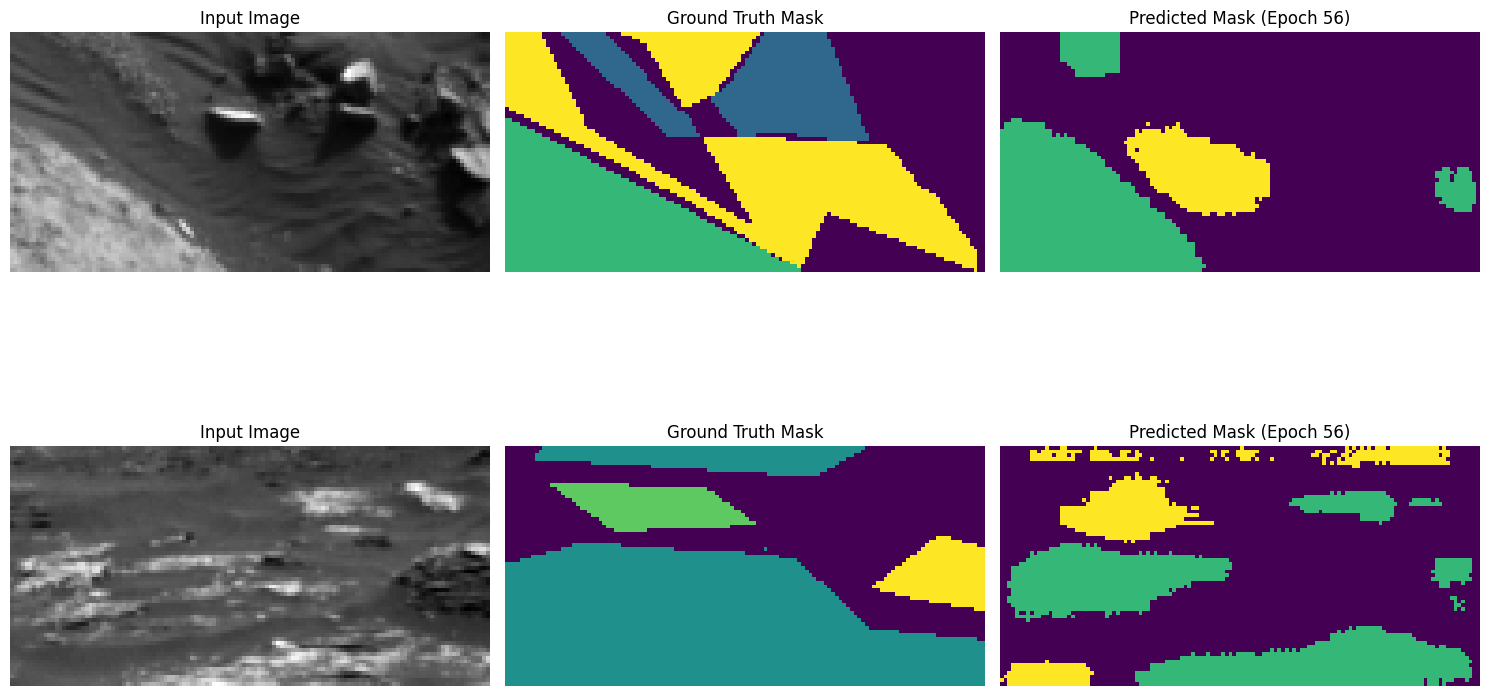

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7971 - loss: 0.5287 - mean_io_u_2: 0.4954 - val_accuracy: 0.7566 - val_loss: 0.6682 - val_mean_io_u_2: 0.4433 - learning_rate: 2.5000e-05
Epoch 57/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7995 - loss: 0.5227 - mean_io_u_2: 0.4982
Epoch 57: val_loss did not improve from 0.66733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


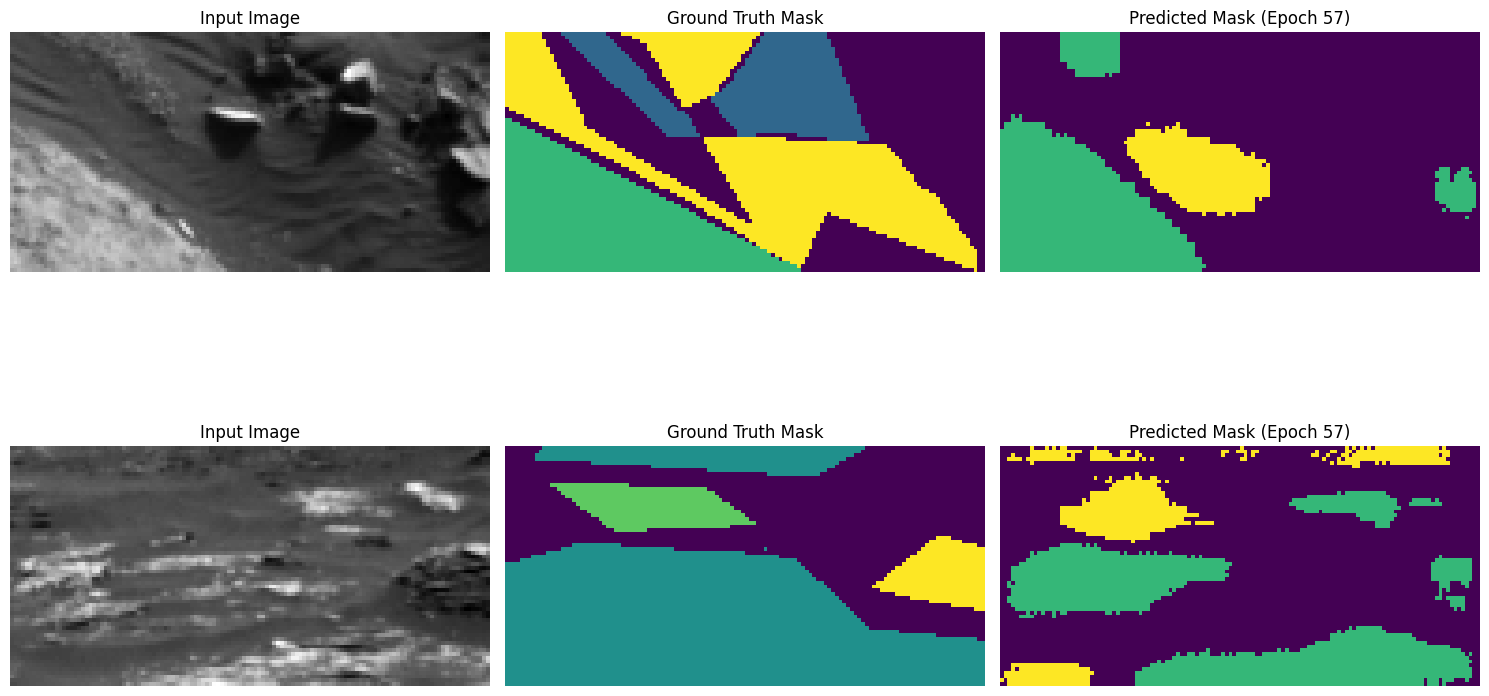

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.7996 - loss: 0.5223 - mean_io_u_2: 0.4982 - val_accuracy: 0.7571 - val_loss: 0.6690 - val_mean_io_u_2: 0.4437 - learning_rate: 2.5000e-05
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8019 - loss: 0.5171 - mean_io_u_2: 0.5011
Epoch 58: val_loss did not improve from 0.66733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


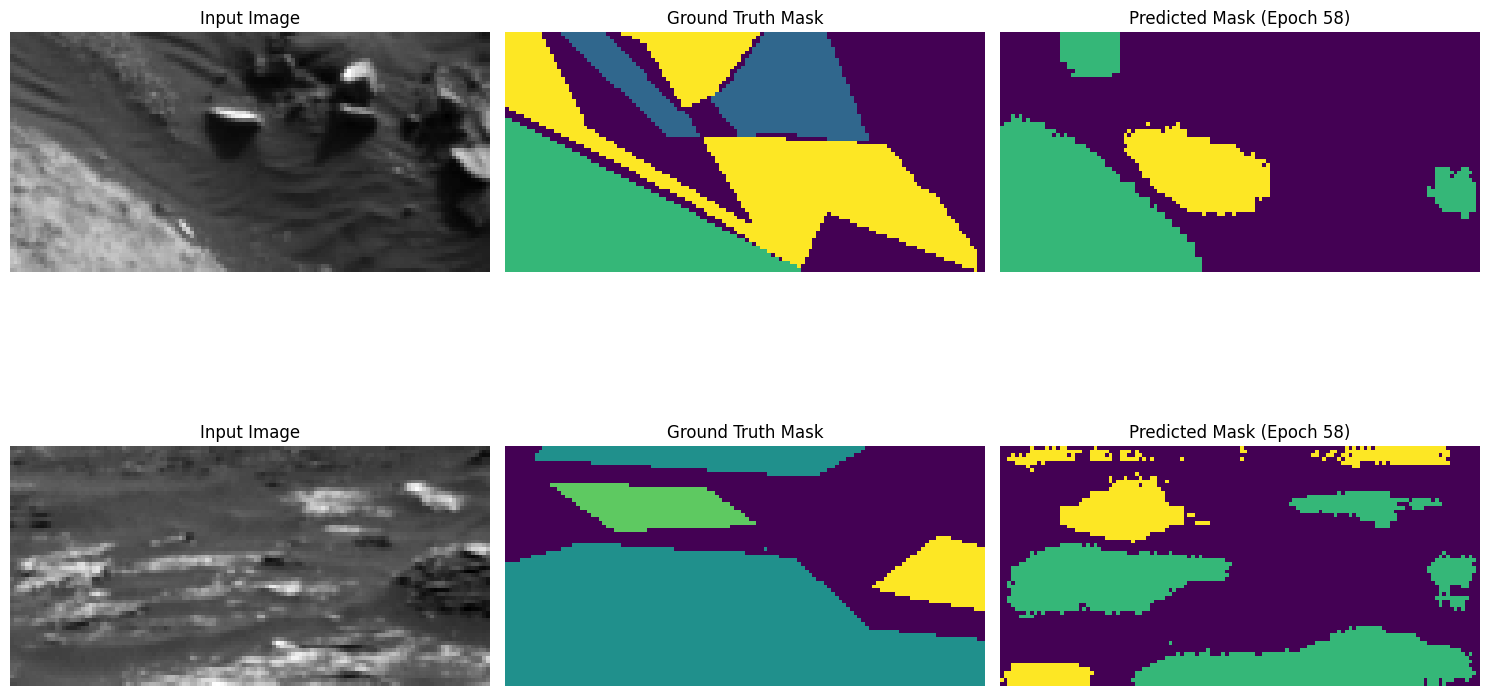

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8021 - loss: 0.5168 - mean_io_u_2: 0.5011 - val_accuracy: 0.7574 - val_loss: 0.6703 - val_mean_io_u_2: 0.4440 - learning_rate: 2.5000e-05
Epoch 59/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8042 - loss: 0.5120 - mean_io_u_2: 0.5036
Epoch 59: val_loss did not improve from 0.66733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


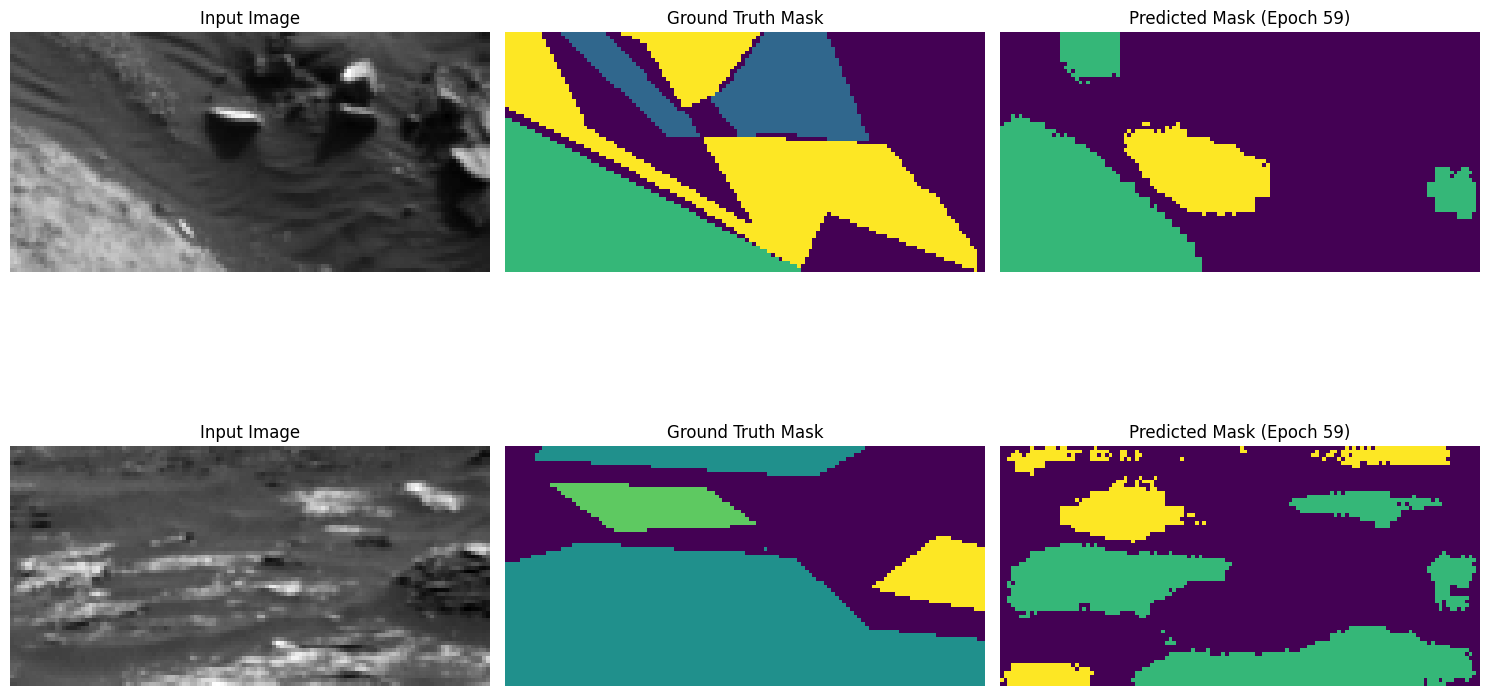

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8043 - loss: 0.5116 - mean_io_u_2: 0.5037 - val_accuracy: 0.7577 - val_loss: 0.6718 - val_mean_io_u_2: 0.4443 - learning_rate: 2.5000e-05
Epoch 60/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8063 - loss: 0.5070 - mean_io_u_2: 0.5061
Epoch 60: val_loss did not improve from 0.66733

Epoch 60: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


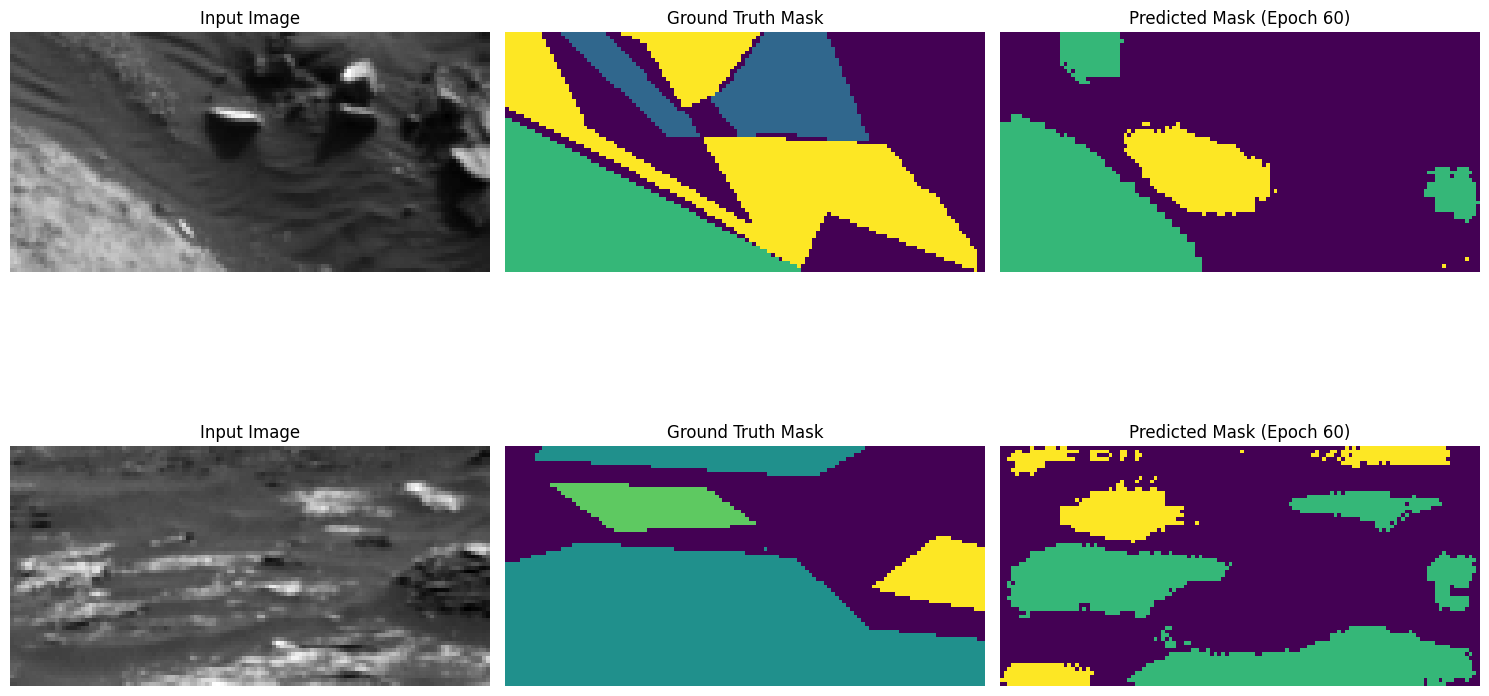

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8064 - loss: 0.5067 - mean_io_u_2: 0.5062 - val_accuracy: 0.7580 - val_loss: 0.6738 - val_mean_io_u_2: 0.4445 - learning_rate: 2.5000e-05
Epoch 61/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8104 - loss: 0.4972 - mean_io_u_2: 0.5063
Epoch 61: val_loss improved from 0.66733 to 0.66217, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


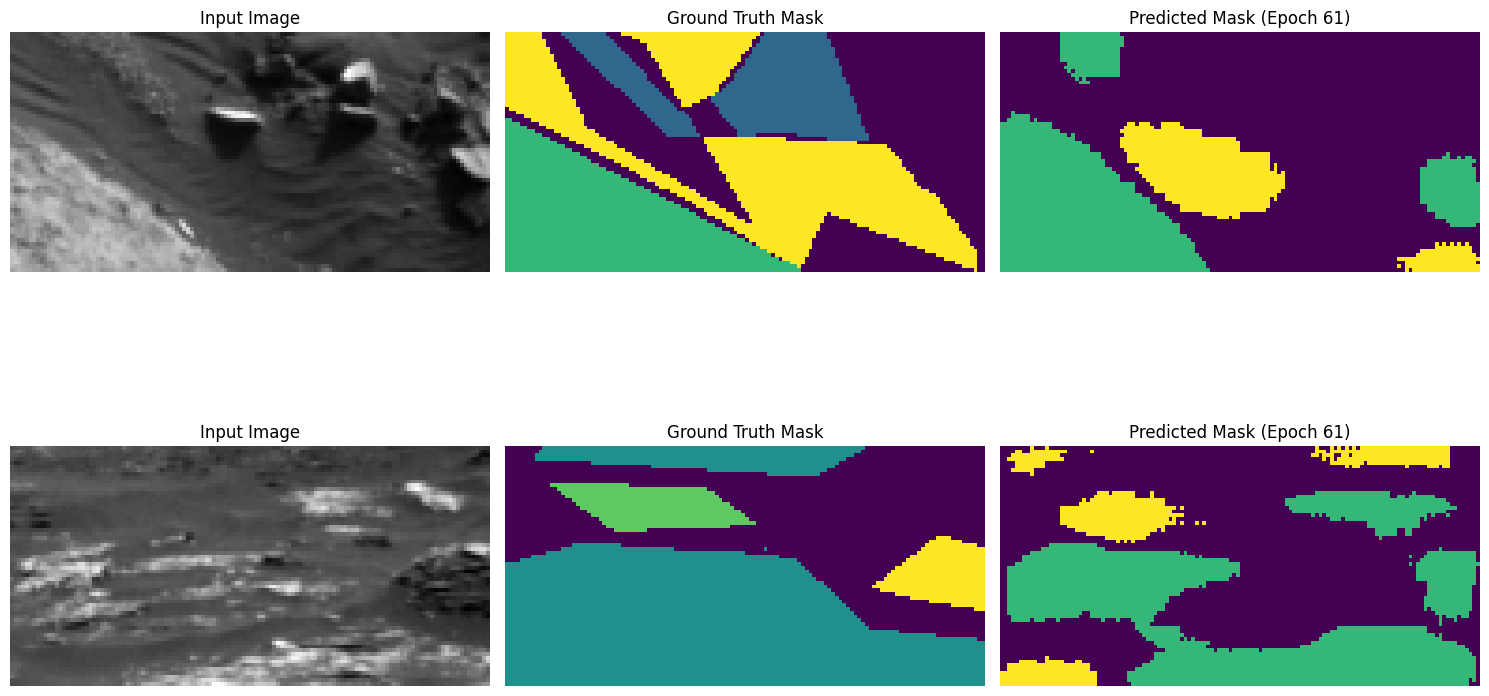

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.8106 - loss: 0.4968 - mean_io_u_2: 0.5064 - val_accuracy: 0.7595 - val_loss: 0.6622 - val_mean_io_u_2: 0.4495 - learning_rate: 1.2500e-05
Epoch 62/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8125 - loss: 0.4900 - mean_io_u_2: 0.5106
Epoch 62: val_loss did not improve from 0.66217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


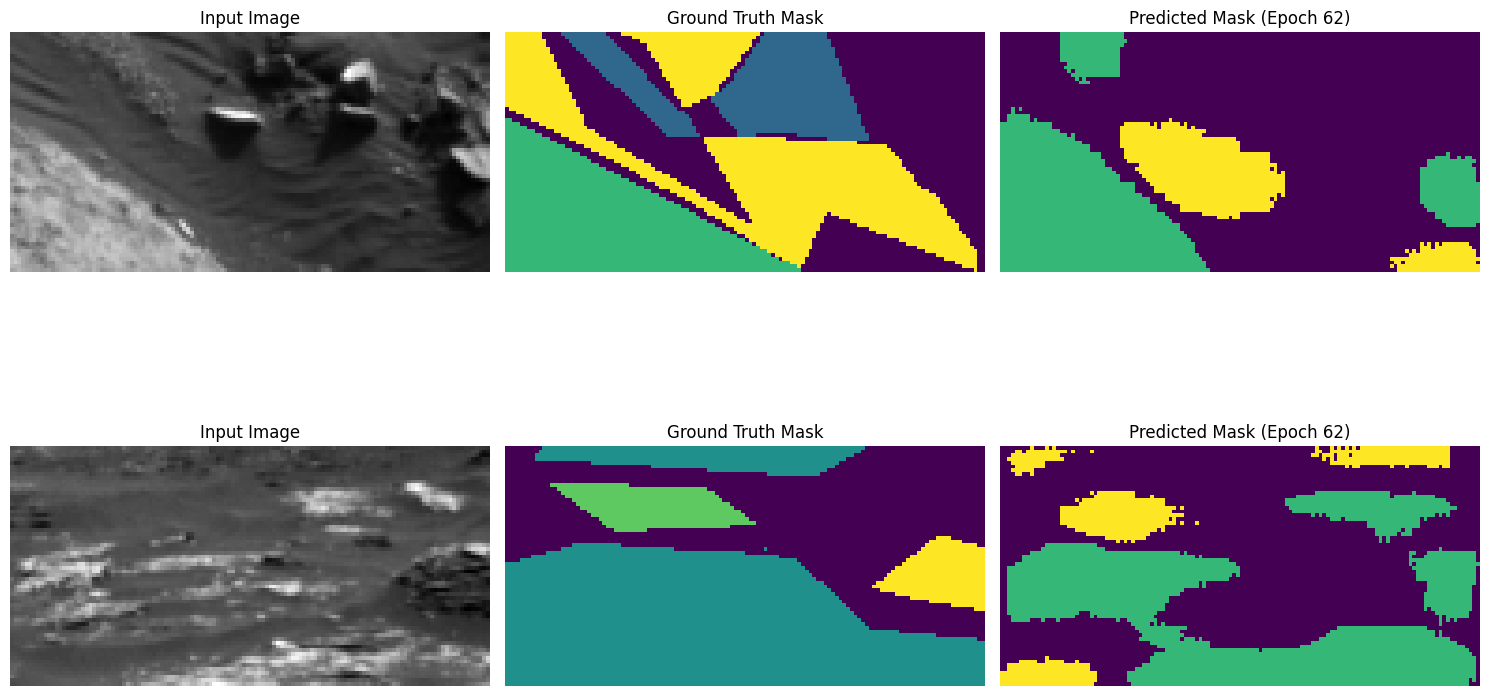

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8127 - loss: 0.4896 - mean_io_u_2: 0.5107 - val_accuracy: 0.7597 - val_loss: 0.6636 - val_mean_io_u_2: 0.4498 - learning_rate: 1.2500e-05
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8137 - loss: 0.4868 - mean_io_u_2: 0.5120
Epoch 63: val_loss did not improve from 0.66217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


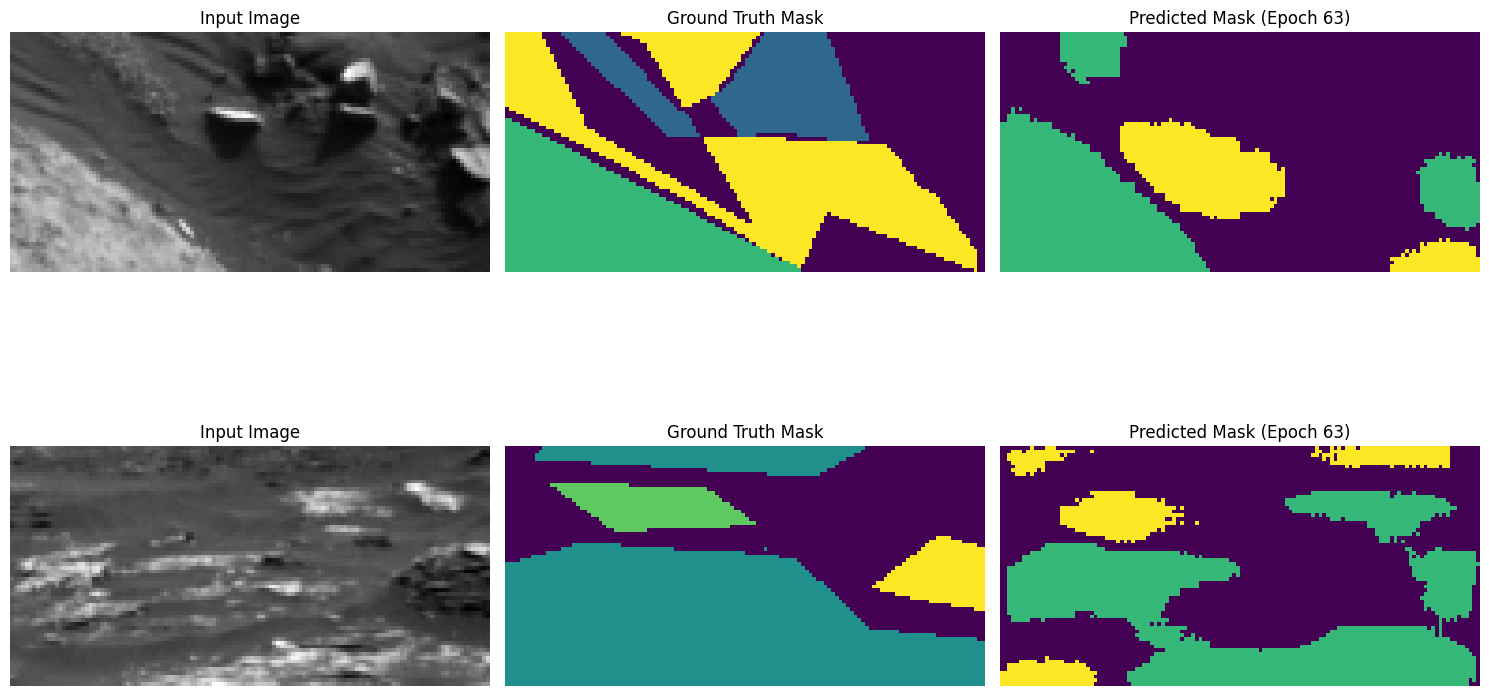

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8139 - loss: 0.4865 - mean_io_u_2: 0.5121 - val_accuracy: 0.7598 - val_loss: 0.6646 - val_mean_io_u_2: 0.4499 - learning_rate: 1.2500e-05
Epoch 64/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8149 - loss: 0.4837 - mean_io_u_2: 0.5134
Epoch 64: val_loss did not improve from 0.66217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


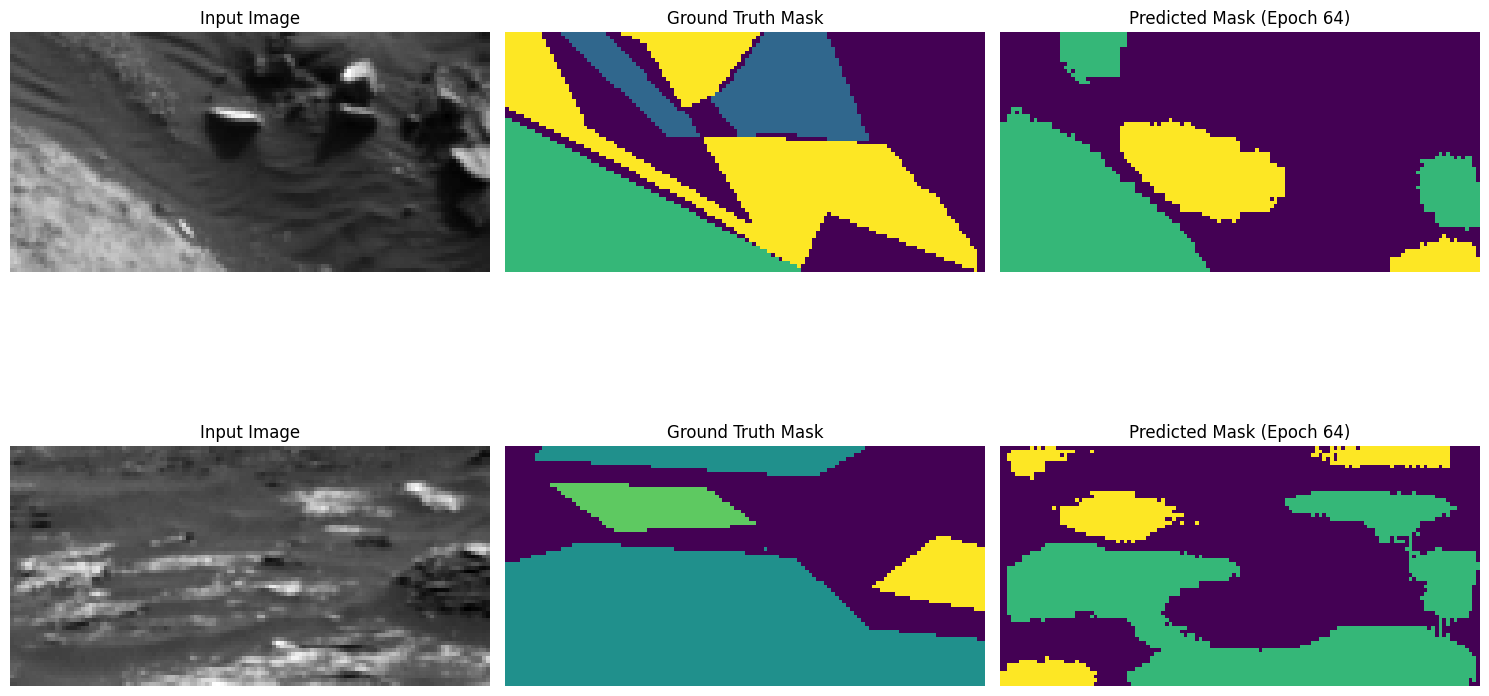

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.8151 - loss: 0.4834 - mean_io_u_2: 0.5135 - val_accuracy: 0.7599 - val_loss: 0.6655 - val_mean_io_u_2: 0.4500 - learning_rate: 1.2500e-05
Epoch 65/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8161 - loss: 0.4808 - mean_io_u_2: 0.5146
Epoch 65: val_loss did not improve from 0.66217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


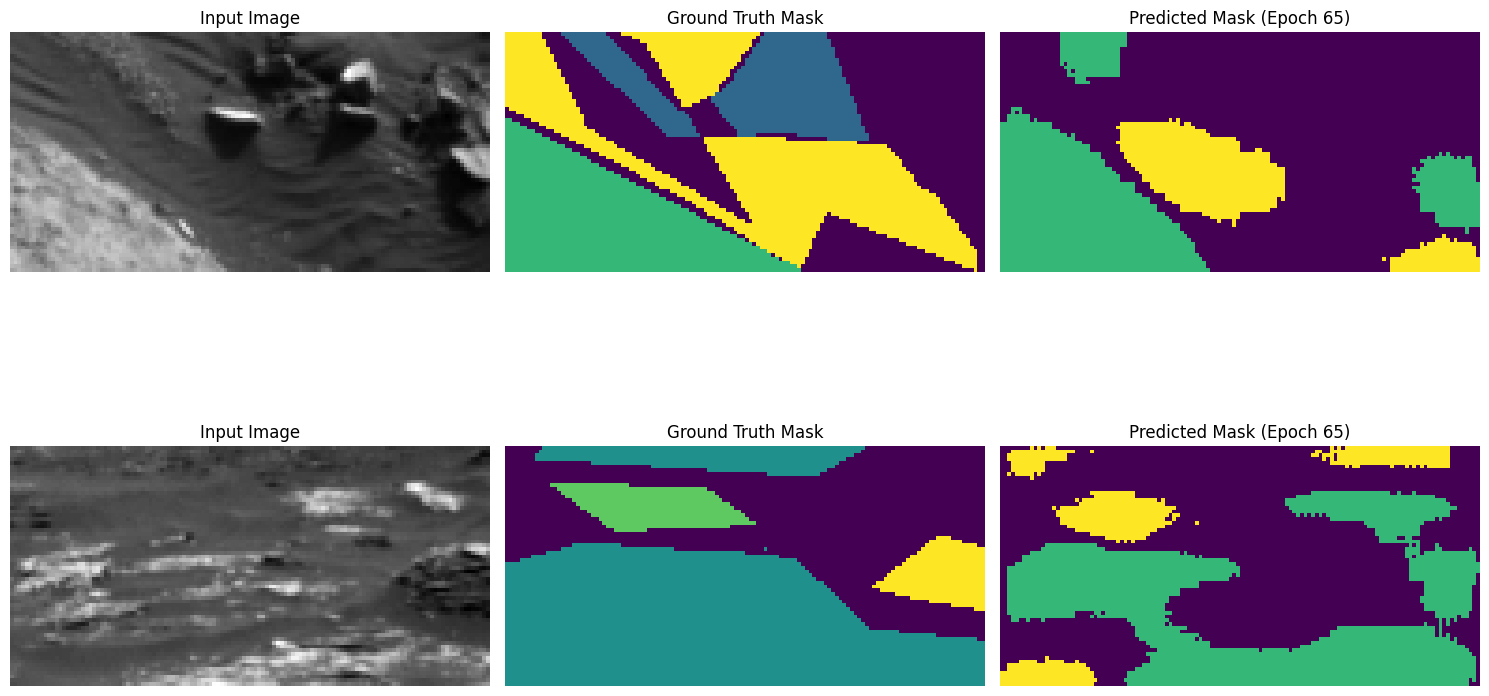

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8162 - loss: 0.4805 - mean_io_u_2: 0.5147 - val_accuracy: 0.7601 - val_loss: 0.6664 - val_mean_io_u_2: 0.4502 - learning_rate: 1.2500e-05
Epoch 66/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8172 - loss: 0.4779 - mean_io_u_2: 0.5158
Epoch 66: val_loss did not improve from 0.66217

Epoch 66: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


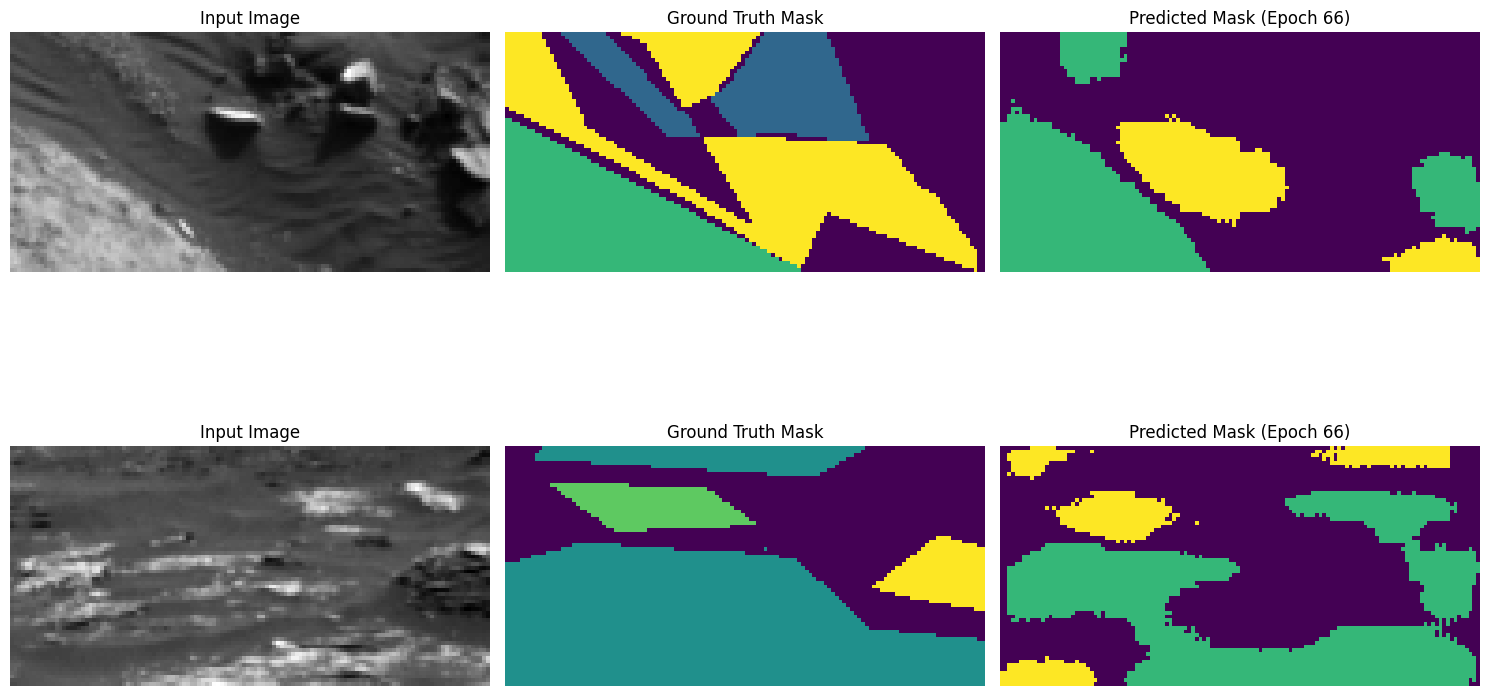

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8174 - loss: 0.4776 - mean_io_u_2: 0.5159 - val_accuracy: 0.7602 - val_loss: 0.6672 - val_mean_io_u_2: 0.4503 - learning_rate: 1.2500e-05
Epoch 67/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8193 - loss: 0.4718 - mean_io_u_2: 0.5159
Epoch 67: val_loss improved from 0.66217 to 0.66139, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


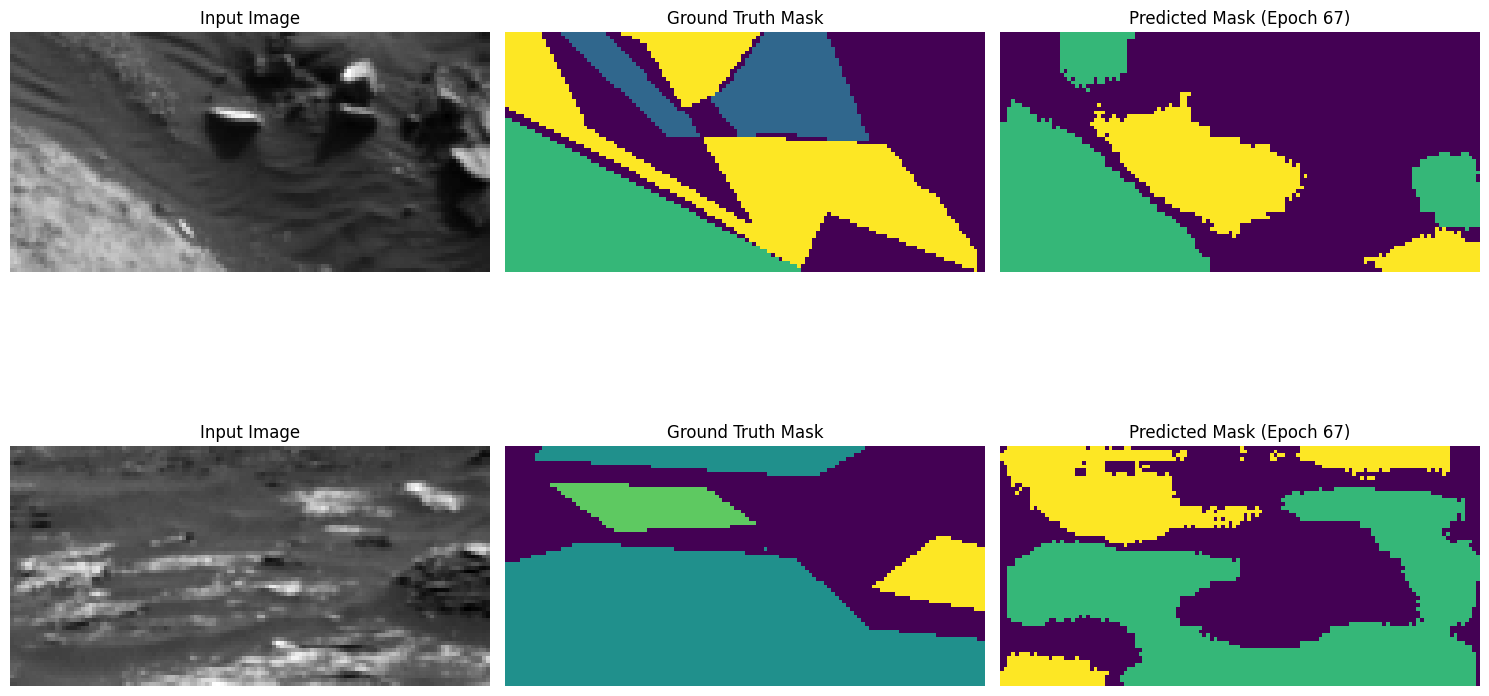

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.8194 - loss: 0.4715 - mean_io_u_2: 0.5160 - val_accuracy: 0.7610 - val_loss: 0.6614 - val_mean_io_u_2: 0.4559 - learning_rate: 6.2500e-06
Epoch 68/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8205 - loss: 0.4674 - mean_io_u_2: 0.5196
Epoch 68: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


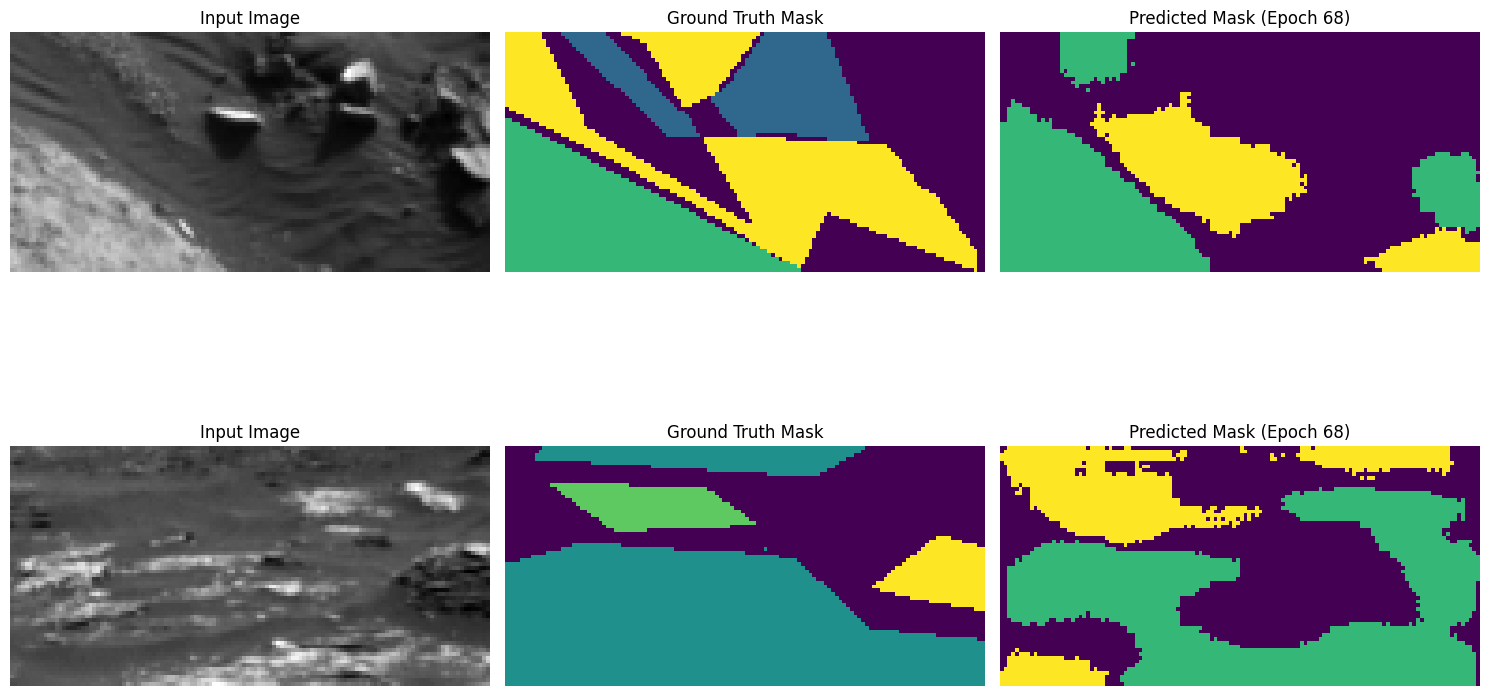

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8206 - loss: 0.4671 - mean_io_u_2: 0.5197 - val_accuracy: 0.7611 - val_loss: 0.6618 - val_mean_io_u_2: 0.4560 - learning_rate: 6.2500e-06
Epoch 69/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8211 - loss: 0.4657 - mean_io_u_2: 0.5203
Epoch 69: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


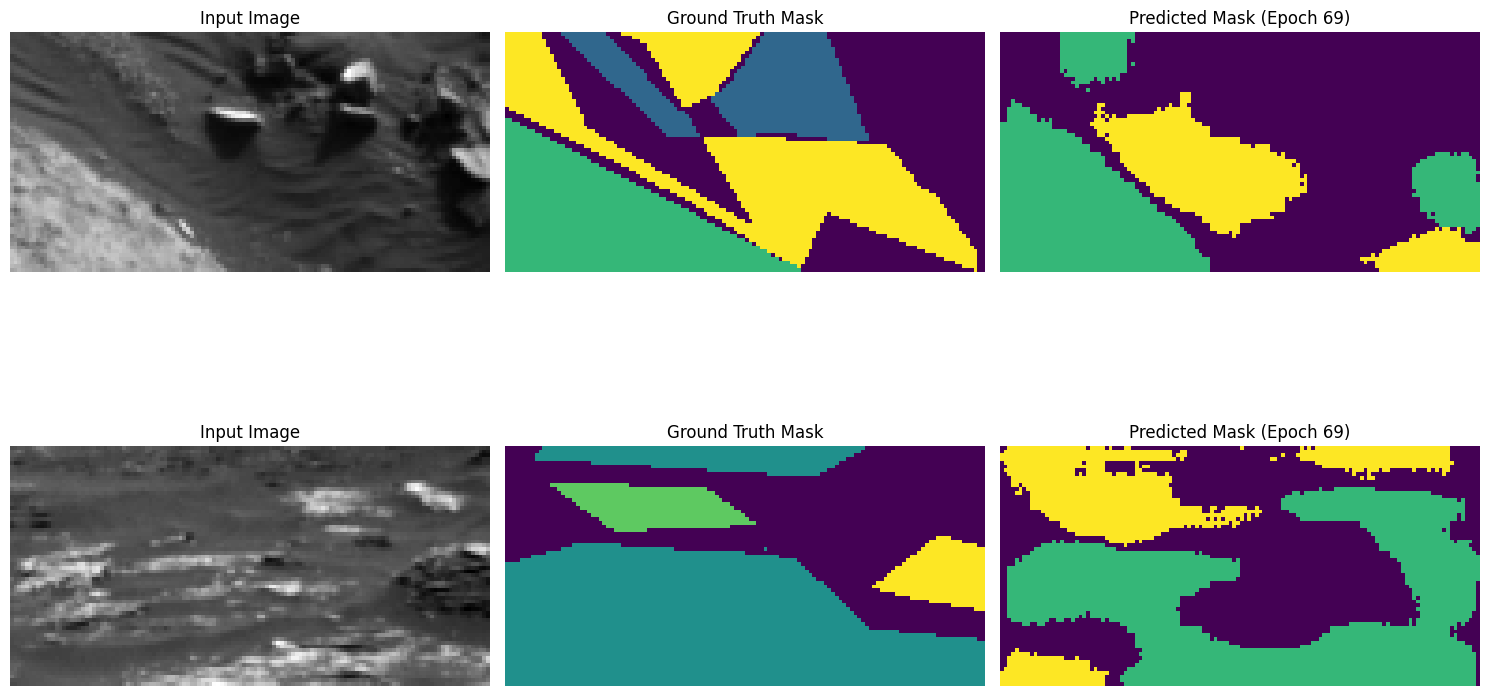

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8212 - loss: 0.4654 - mean_io_u_2: 0.5204 - val_accuracy: 0.7611 - val_loss: 0.6623 - val_mean_io_u_2: 0.4562 - learning_rate: 6.2500e-06
Epoch 70/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8217 - loss: 0.4641 - mean_io_u_2: 0.5209
Epoch 70: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


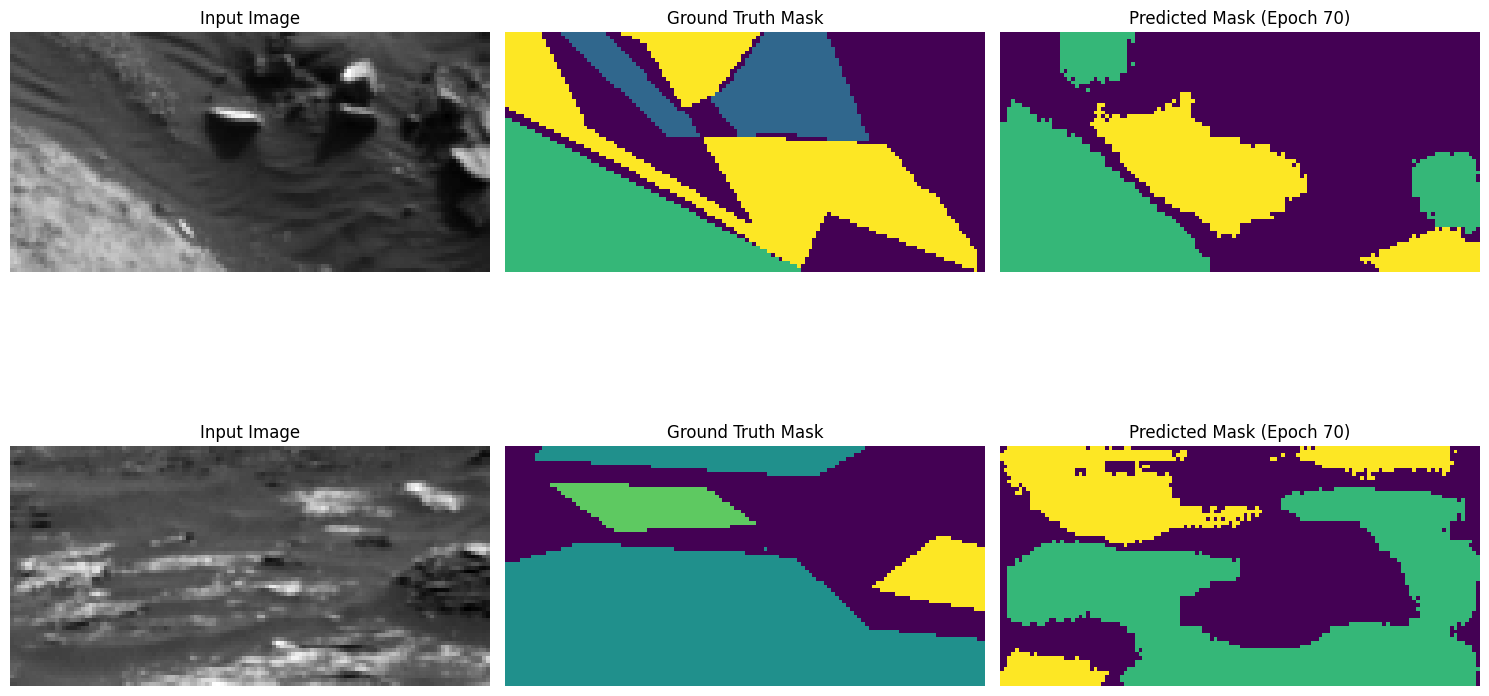

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8218 - loss: 0.4637 - mean_io_u_2: 0.5209 - val_accuracy: 0.7612 - val_loss: 0.6628 - val_mean_io_u_2: 0.4563 - learning_rate: 6.2500e-06
Epoch 71/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8224 - loss: 0.4624 - mean_io_u_2: 0.5215
Epoch 71: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


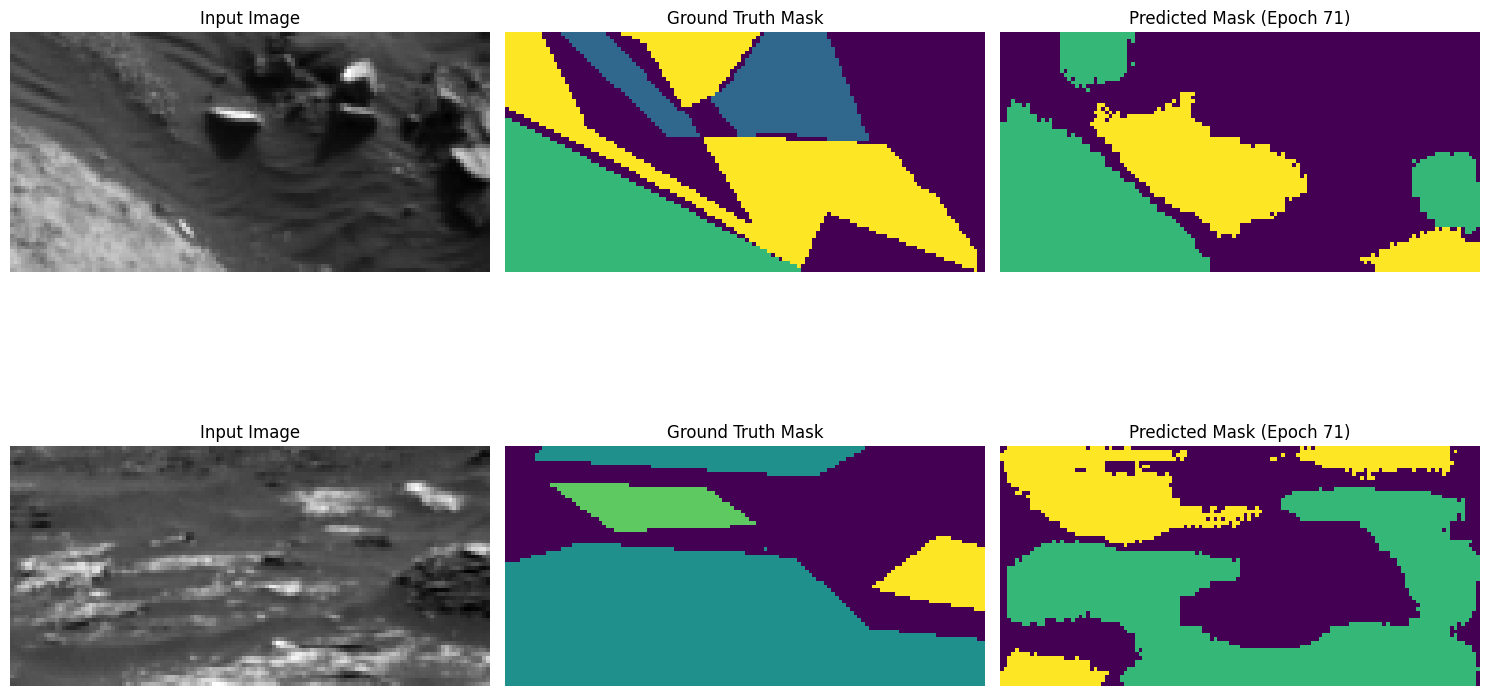

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8225 - loss: 0.4621 - mean_io_u_2: 0.5216 - val_accuracy: 0.7613 - val_loss: 0.6633 - val_mean_io_u_2: 0.4564 - learning_rate: 6.2500e-06
Epoch 72/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8230 - loss: 0.4608 - mean_io_u_2: 0.5221
Epoch 72: val_loss did not improve from 0.66139

Epoch 72: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


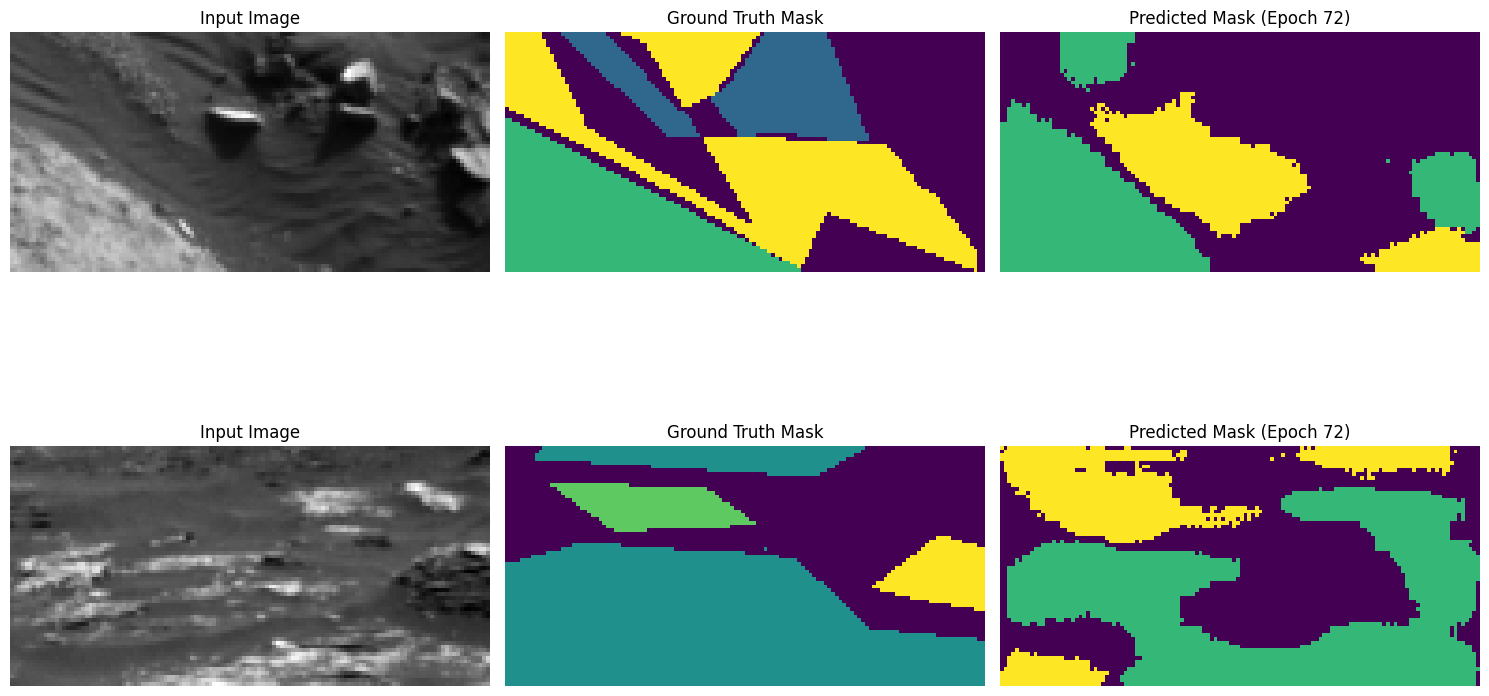

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8231 - loss: 0.4605 - mean_io_u_2: 0.5222 - val_accuracy: 0.7614 - val_loss: 0.6637 - val_mean_io_u_2: 0.4566 - learning_rate: 6.2500e-06
Epoch 73/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8237 - loss: 0.4578 - mean_io_u_2: 0.5232
Epoch 73: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


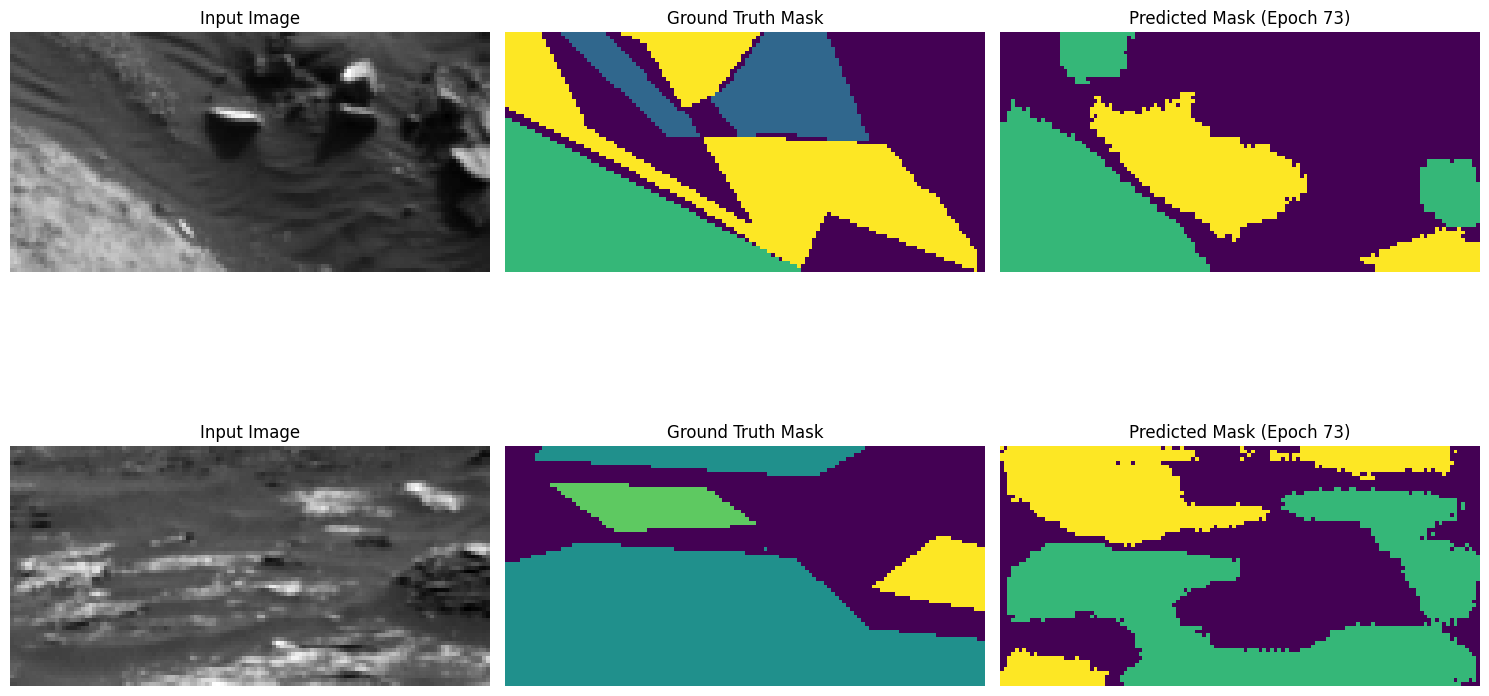

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8238 - loss: 0.4575 - mean_io_u_2: 0.5232 - val_accuracy: 0.7606 - val_loss: 0.6635 - val_mean_io_u_2: 0.4536 - learning_rate: 3.1250e-06
Epoch 74/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8253 - loss: 0.4544 - mean_io_u_2: 0.5248
Epoch 74: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


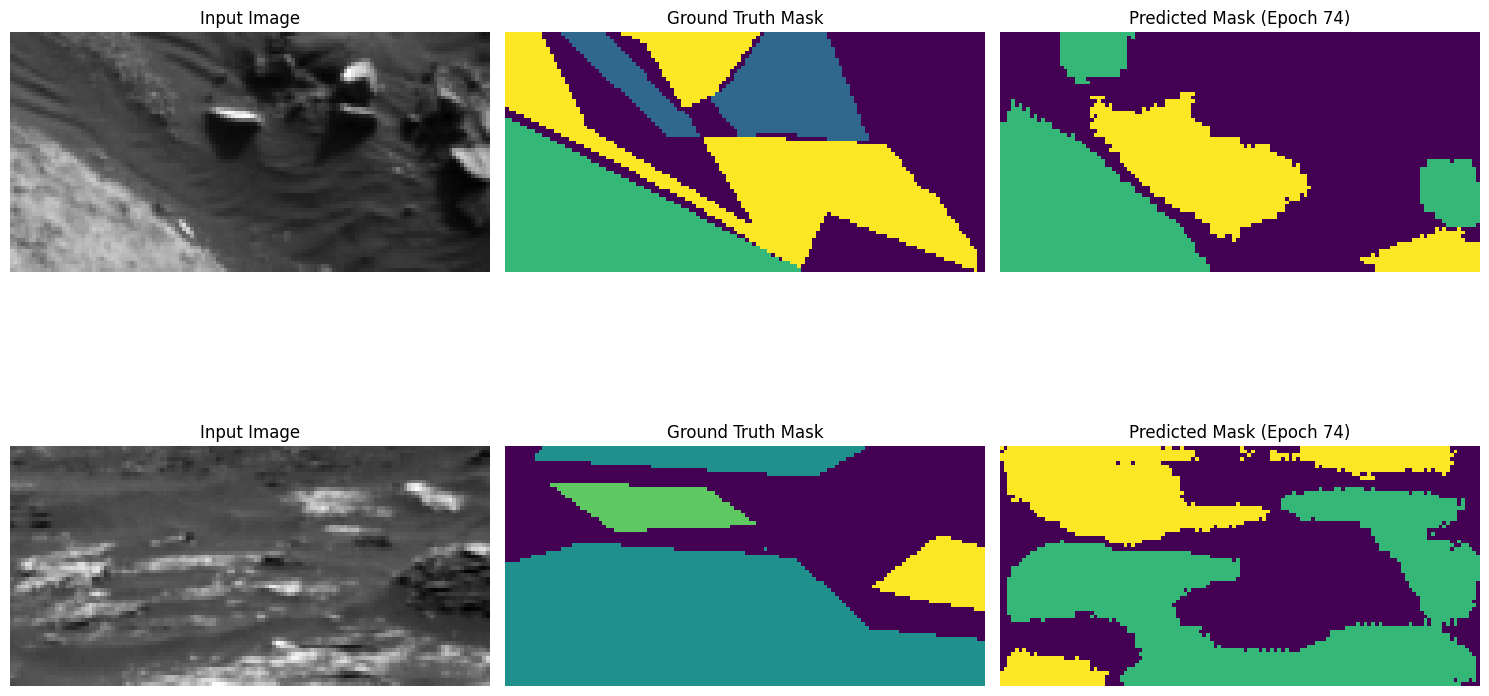

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8255 - loss: 0.4541 - mean_io_u_2: 0.5248 - val_accuracy: 0.7606 - val_loss: 0.6639 - val_mean_io_u_2: 0.4537 - learning_rate: 3.1250e-06
Epoch 75/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8257 - loss: 0.4533 - mean_io_u_2: 0.5251
Epoch 75: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


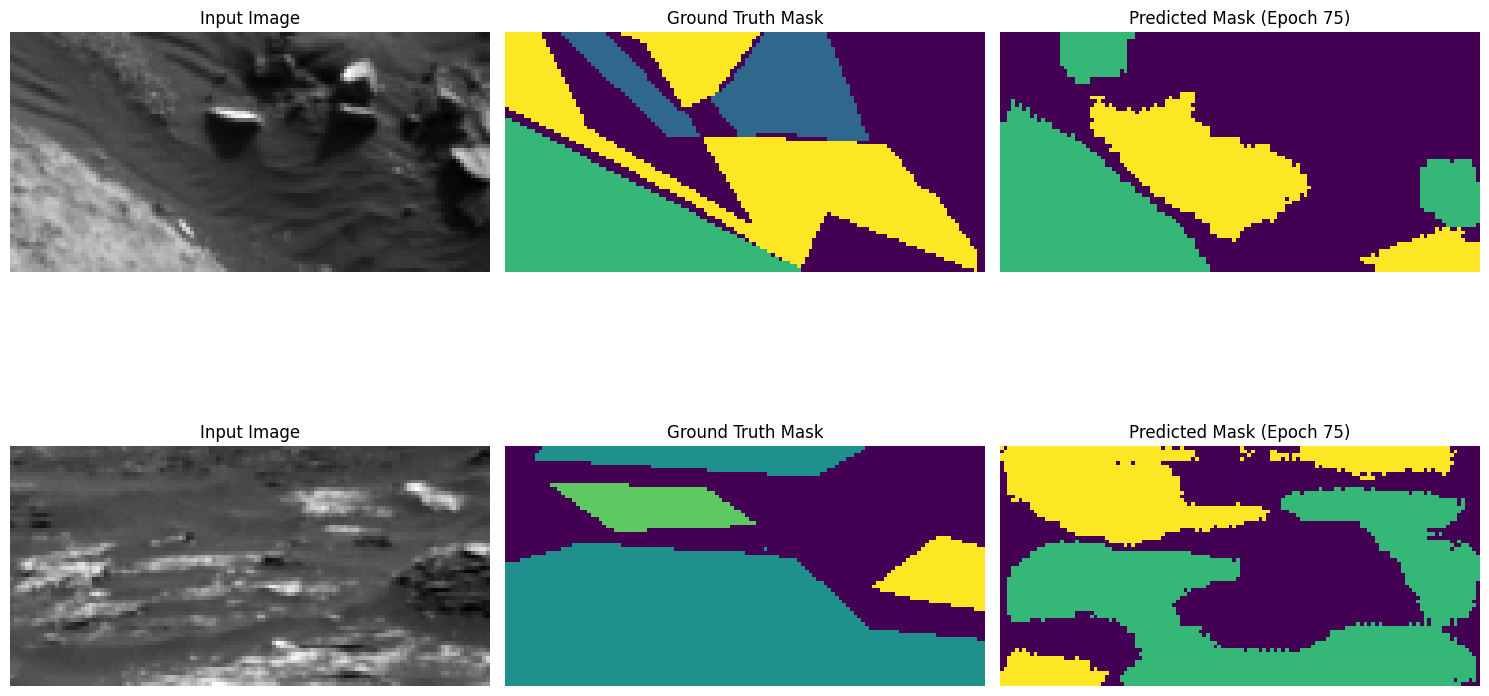

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.8259 - loss: 0.4531 - mean_io_u_2: 0.5252 - val_accuracy: 0.7606 - val_loss: 0.6643 - val_mean_io_u_2: 0.4538 - learning_rate: 3.1250e-06
Epoch 76/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8261 - loss: 0.4525 - mean_io_u_2: 0.5255
Epoch 76: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


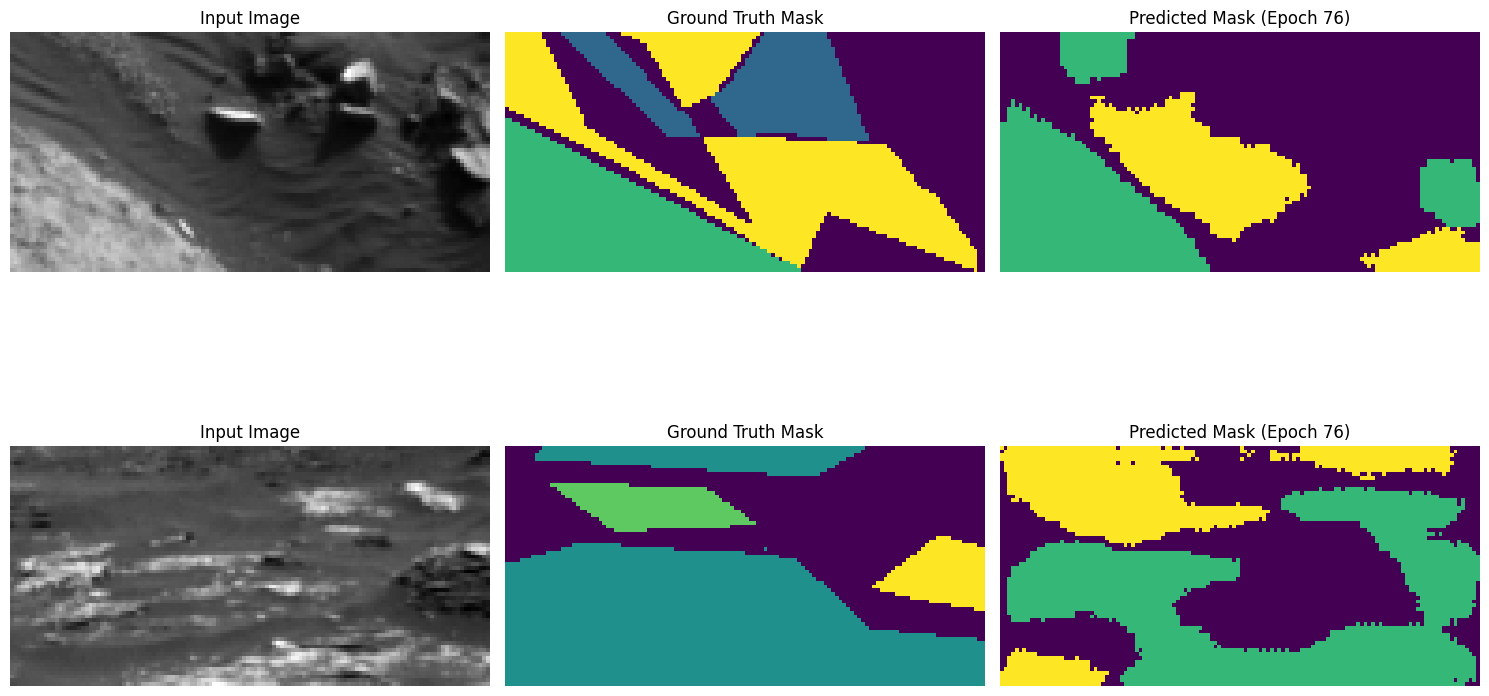

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.8262 - loss: 0.4522 - mean_io_u_2: 0.5255 - val_accuracy: 0.7606 - val_loss: 0.6647 - val_mean_io_u_2: 0.4539 - learning_rate: 3.1250e-06
Epoch 77/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8264 - loss: 0.4516 - mean_io_u_2: 0.5258
Epoch 77: val_loss did not improve from 0.66139

Epoch 77: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


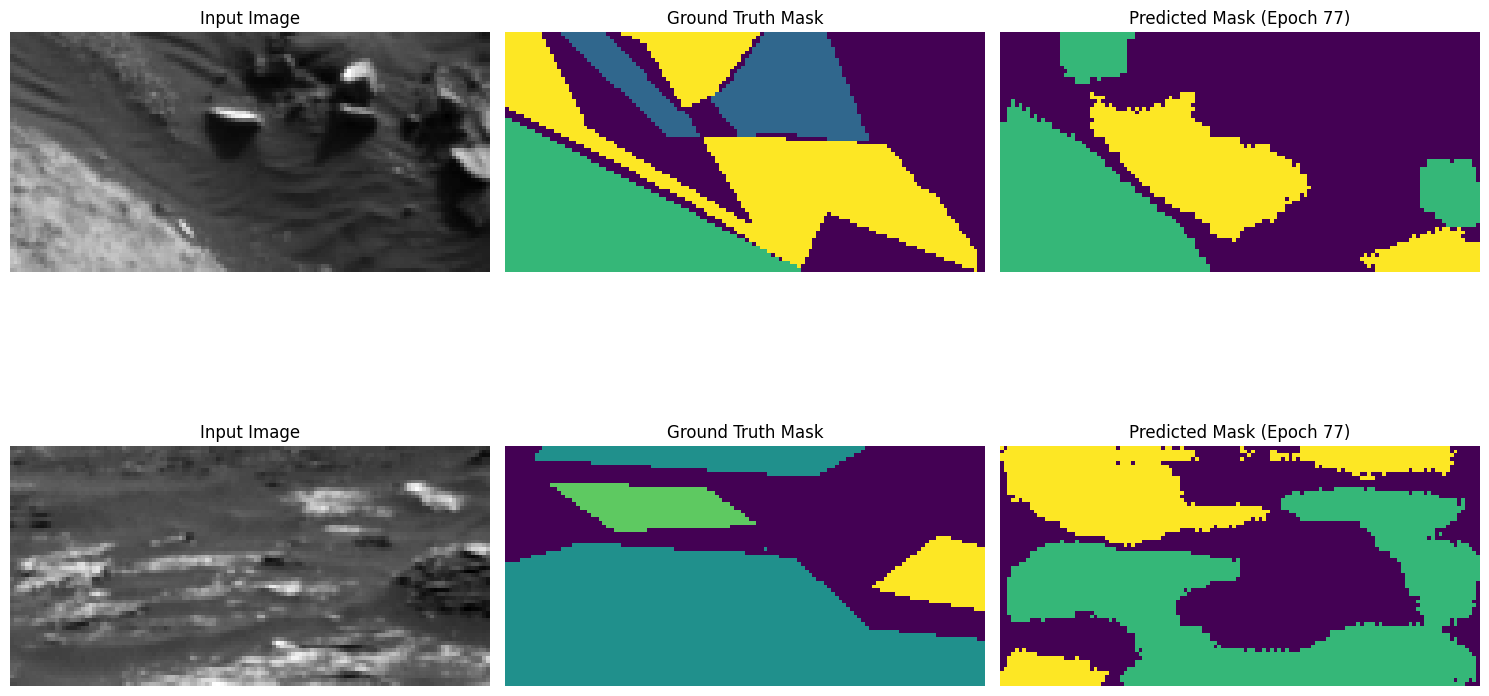

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8265 - loss: 0.4513 - mean_io_u_2: 0.5258 - val_accuracy: 0.7605 - val_loss: 0.6651 - val_mean_io_u_2: 0.4539 - learning_rate: 3.1250e-06
Epoch 78/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8271 - loss: 0.4501 - mean_io_u_2: 0.5269
Epoch 78: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


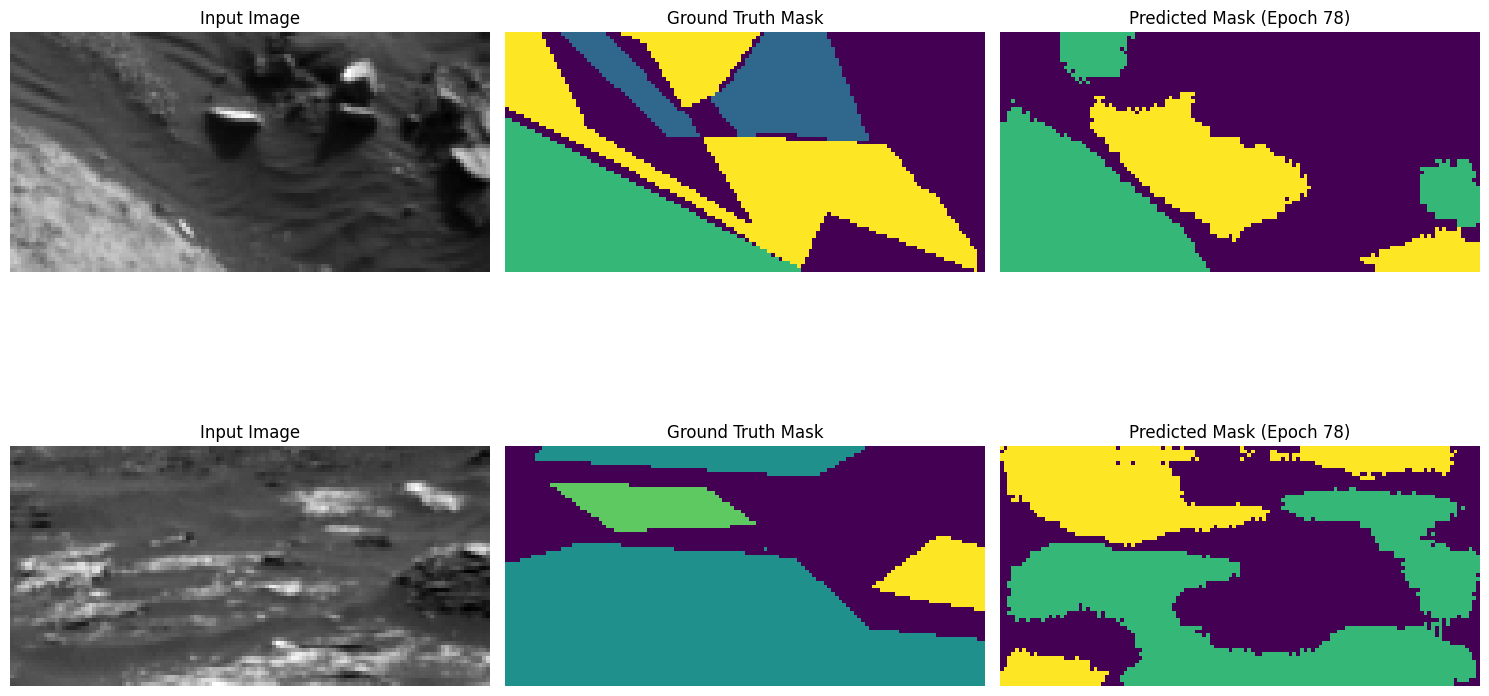

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8272 - loss: 0.4497 - mean_io_u_2: 0.5270 - val_accuracy: 0.7601 - val_loss: 0.6655 - val_mean_io_u_2: 0.4519 - learning_rate: 1.5625e-06
Epoch 79/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8280 - loss: 0.4481 - mean_io_u_2: 0.5266
Epoch 79: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


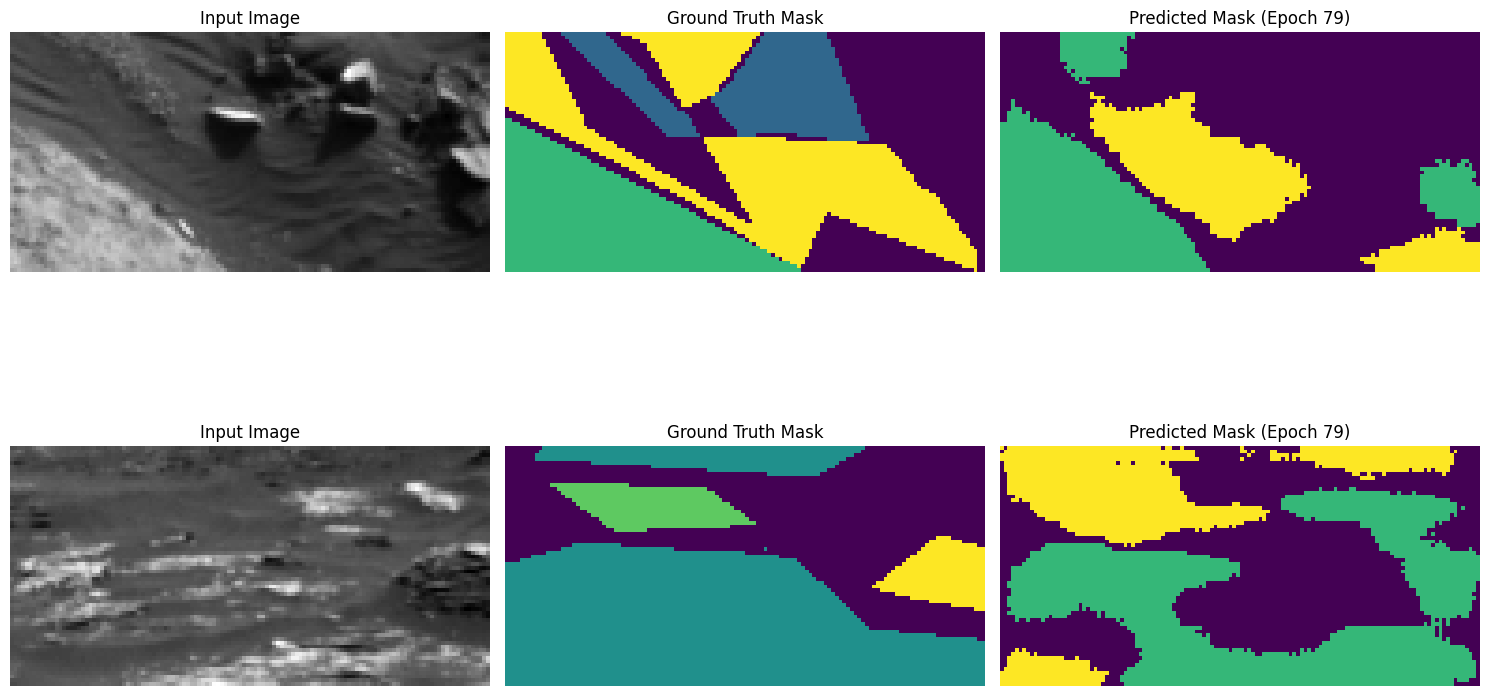

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.8282 - loss: 0.4478 - mean_io_u_2: 0.5267 - val_accuracy: 0.7601 - val_loss: 0.6659 - val_mean_io_u_2: 0.4520 - learning_rate: 1.5625e-06
Epoch 80/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8282 - loss: 0.4476 - mean_io_u_2: 0.5268
Epoch 80: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


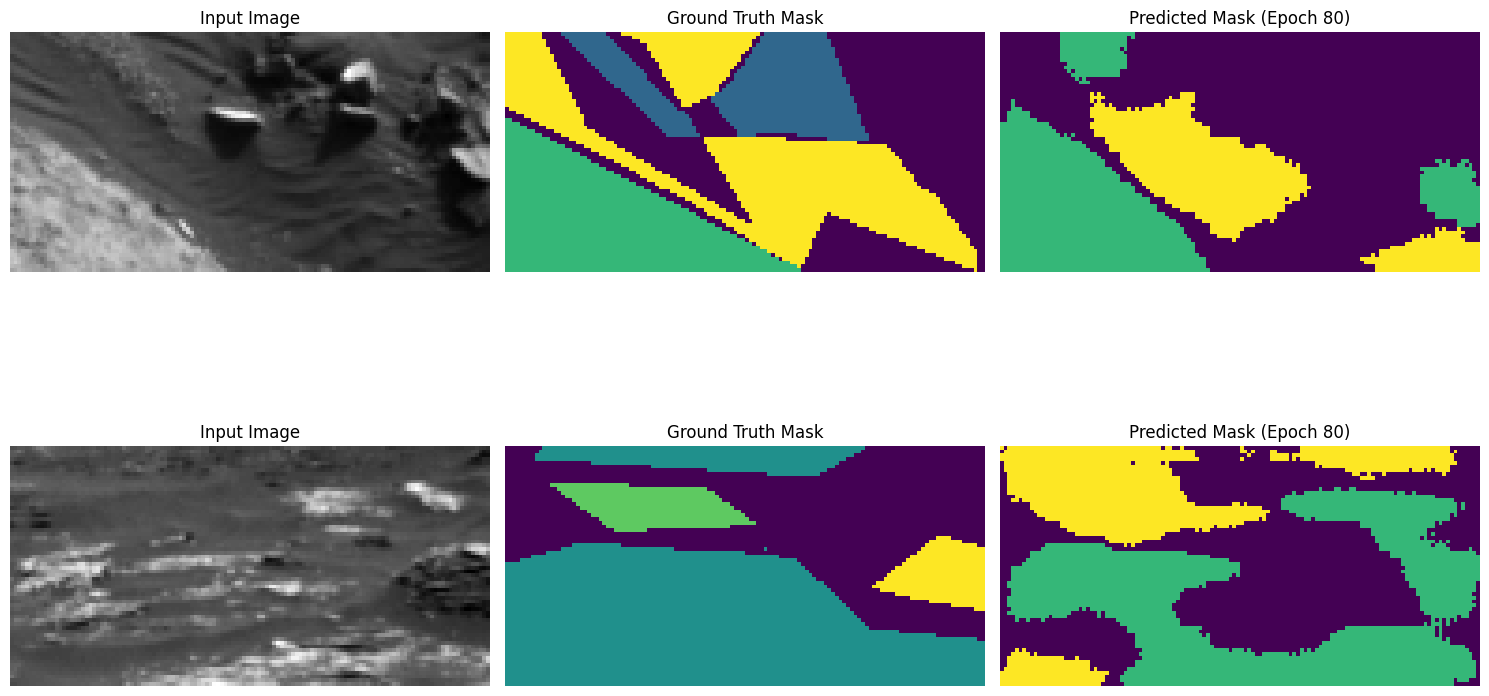

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.8284 - loss: 0.4473 - mean_io_u_2: 0.5268 - val_accuracy: 0.7601 - val_loss: 0.6661 - val_mean_io_u_2: 0.4520 - learning_rate: 1.5625e-06
Epoch 81/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8284 - loss: 0.4471 - mean_io_u_2: 0.5269
Epoch 81: val_loss did not improve from 0.66139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


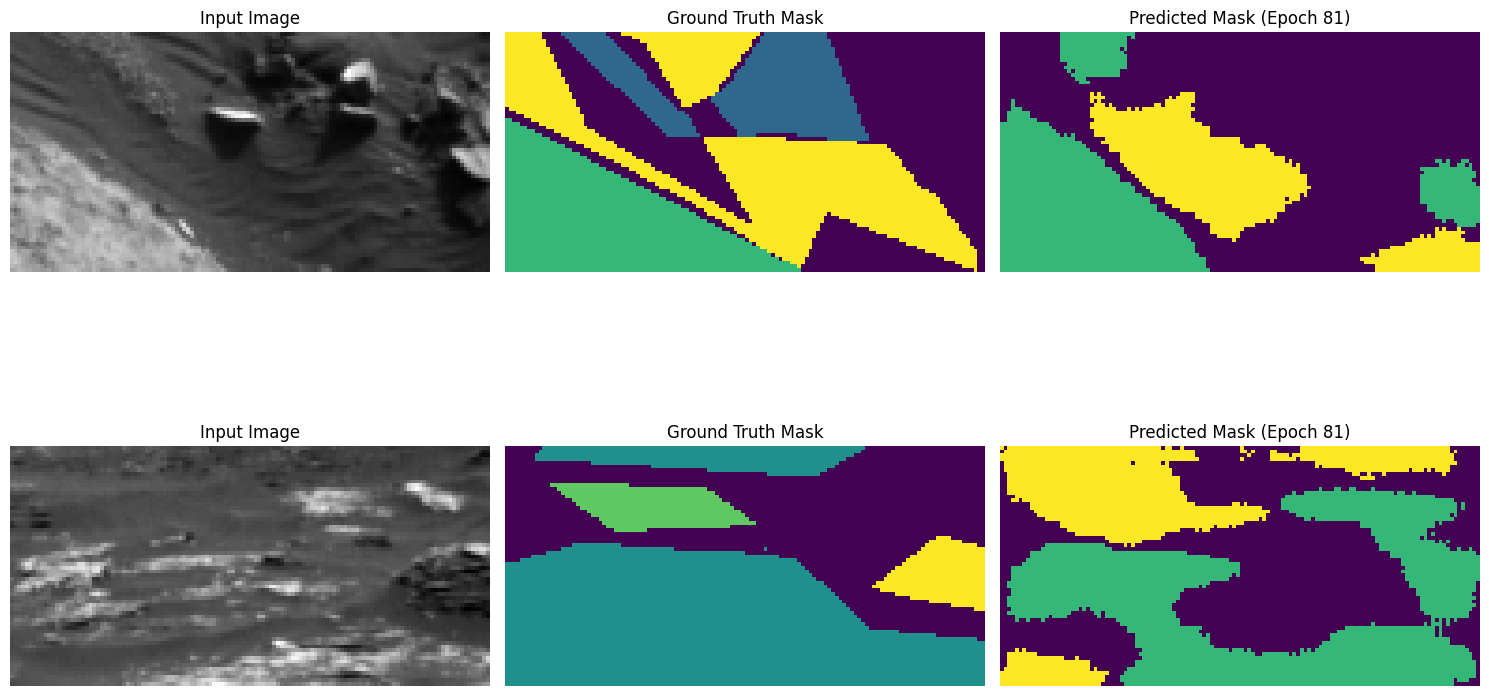

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8285 - loss: 0.4468 - mean_io_u_2: 0.5270 - val_accuracy: 0.7601 - val_loss: 0.6664 - val_mean_io_u_2: 0.4520 - learning_rate: 1.5625e-06
Epoch 82/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8286 - loss: 0.4467 - mean_io_u_2: 0.5271
Epoch 82: val_loss did not improve from 0.66139

Epoch 82: ReduceLROnPlateau reducing learning rate to 1e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


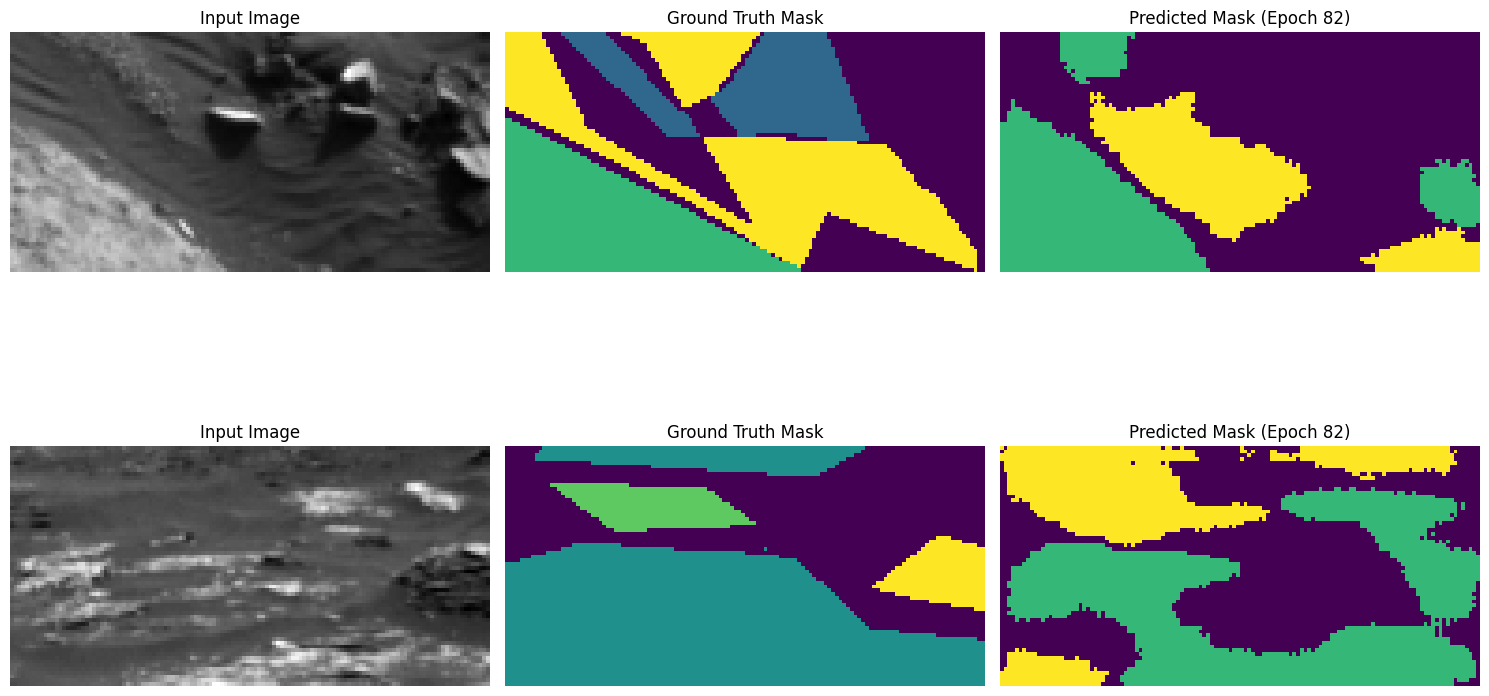

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8287 - loss: 0.4464 - mean_io_u_2: 0.5272 - val_accuracy: 0.7600 - val_loss: 0.6666 - val_mean_io_u_2: 0.4520 - learning_rate: 1.5625e-06


In [44]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

# Residual Block
def residual_block(x, filters):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

# Dice Loss
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return tf.reduce_mean(1 - numerator / (denominator + tf.keras.backend.epsilon()))

# Hybrid Loss Function
def combined_loss(weights):
    ce_loss = weighted_categorical_crossentropy(weights)
    def loss(y_true, y_pred):
        return ce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# U-Net with Residual Connections
def unet_with_residual_blocks(input_shape, num_classes):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = tfkl.concatenate([u1, c3])
    d1 = residual_block(u1, 256)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = tfkl.concatenate([u2, c2])
    d2 = residual_block(u2, 128)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = tfkl.concatenate([u3, c1])
    d3 = residual_block(u3, 64)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the model
input_shape = X_train.shape[1:]
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model = unet_with_residual_blocks(input_shape, num_classes)
# Define the optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", mean_iou])

model.summary()

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # Add validation data
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)

# Save the model
model.save("best_model_resunet.keras")


In [45]:
model_filename = f"model_unet_modified.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_unet_modified.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [46]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [47]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [48]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step
Predictions shape: (10022, 64, 128)


In [49]:
model.save("model_resunet.keras")

Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


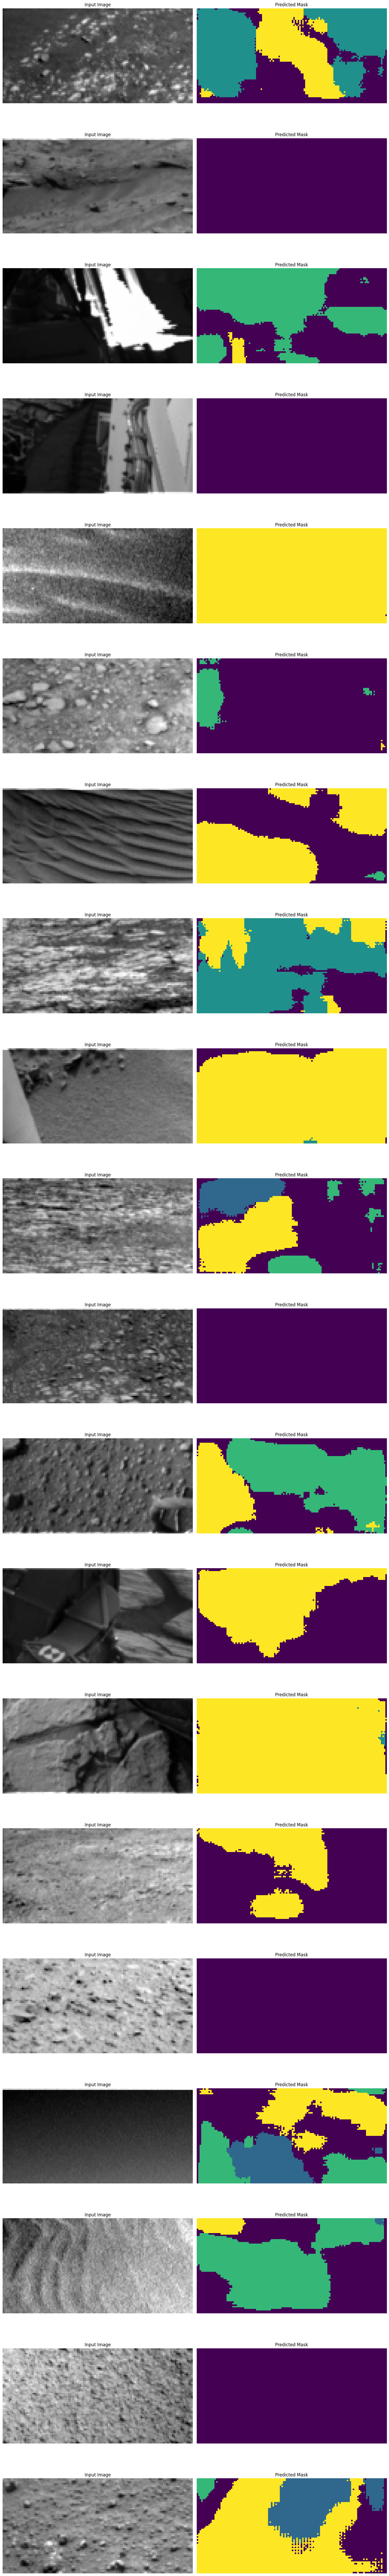

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis")
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [51]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [53]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [54]:
len(submission_df.columns)

8193

In [55]:
len(submission_df)

10022